Student name: David Schenck<br>
Student pace: Flex<br>
Scheduled project review date/time: <br>
Instructor Name: Morgan Jones<br>
Blog post URL: 

# Project Description

Every year, the NFL hosts the NFL Combine which seeks to evaluate prospective players ahead of the Draft. The players who are invited participate in several tests of their athleticism as well as completing some position specific drills. NFL teams use the Combine and other methods to evaluate players and decide who they want to draft or potentially sign after the draft is complete.

In this project, I utilize the results of the NFL combine from 2009 to 2019 to try to answer the following questions:
1. How accurately can one predict whether a player will be drafted based on their NFL Combine performance?
2. Which tests carry more weight in determining which players get drafted?
3. Does the weight given to certain tests depend on the player a position plays?

An NFL team could use the model created below to estimate how likely it is that a given player will be drafted. This could be useful because it can give the team a sense of how much they should prioritize a player in the Draft. If a player is going to be highly coveted by other teams, it will be necessary to select them with an early draft pick. If the player is unlikely to be drafted (but the team still wants them), they can use a later draft pick or even try to sign them as an undrafted player.

# Exploring the Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as st

The main dataset contains information about the performance of players in the NFL Combine from 2009 to 2019.<br>
Source: https://www.kaggle.com/datasets/redlineracer/nfl-combine-performance-data-2009-2019

Columns in the dataset:
Year: Year player attended combine<br>
Player: Name of player and a unique code used by pro-football-reference.com.<br>
Age: Age of player when they attended the combine.<br>
School: College the player last attended.<br>
Height: Height of player in meters.<br>
Weight: Weight of player in kg.<br>
Sprint_40yd: Time in the 40-yard sprint.<br>
Vertical_Jump: Height of vertical jump in cm.<br>
Bench_Press_Reps: Number of times player could bench press 225 pounds consecutively.<br>
Broad_Jump: Distance player could jump from a standing position in cm.<br>
Agility_3cone: Time to complete 3-cone drill in seconds.<br>
Shuttle: Time to complete the 20-yard shuttle drill in seconds.<br>
Drafted..tm.rnd.yr.: If drafted, it gives the team, round, pick, and year.<br>
BMI: Body mass index.<br>
Player_Type: Offense, defense, or special teams.<br>
Position_Type: Puts positions into categories.<br>
Position: The specific position the player plays.<br>
Drafted: Yes or No.

**Fixes to Original Data**<br>
The original data had 550 players whose age was missing. This created a problem because only 2% of those players were drafted, but 77% of players with listed ages got drafted. This was a very strong systematic effect that biased the models.<br>

I went through all of the players with missing ages and searched for them online to get the missing data. I still wasn't able to find the ages for 35 of the players, but that is way better than missing 550. I also found that there were other issues with the data:<br>
1. There were 30 players who were listed as going undrafted, but were actually drafted. The vast majority of these were recent (from 2018 and 2019). I fixed these.<br>
2. Some players had the wrong school listed. These were also fixed.

I also went through the data to make sure it wasn't missing players who were drafted after attending the combine. From 2009-2017, there were about a dozen players like this who were missing. I manually added them to the data. However, in 2018 and 2019, it was clear that whoever compiled the data made some sort of mistake which led to missing players. In 2018, all of the linebackers were missing. In 2019, linebackers, defensive ends, defensive tackles, offensive guards, and centers were missing. I added all of these manually. In all, 98 players were added to the data.

Another issue with the 2018 and 2019 data is that the records now list all safeties as just 'S' rather than separating free safeties and strong safeties. There were 56 of these players. I manually fixed these myself.

There were two players (Minkah Fitzpatrick and Quentin Meeks) whose positions were listed as 'DB' (defensive back). This is a more general terms that encompasses safeties and cornerbacks. I looked them up and assigned their actual positions.

In [2]:
# Read in data
df_combine = pd.read_csv('./Data/NFL.csv')
df_combine

Year                     Player   Age        School    Height  \
0     2009      Beanie Wells\WellCh00  20.0      Ohio St.  1.854200   
1     2009        Will Davis\DaviWi99  22.0      Illinois  1.879600   
2     2009    Herman Johnson\JohnHe23  24.0           LSU  2.006600   
3     2009    Rashad Johnson\JohnRa98  23.0       Alabama  1.803400   
4     2009        Cody Brown\BrowCo96  22.0   Connecticut  1.879600   
...    ...                        ...   ...           ...       ...   
3570  2019       Jalen Jelks\JelkJa00  22.0        Oregon  1.965325   
3571  2019     Chris Slayton\SlayCh00  22.0      Syracuse  1.930400   
3572  2019   Javon Patterson\PattJa00  21.0   Mississippi  1.905000   
3573  2019      Dakota Allen\AlleDa01  23.0    Texas Tech  1.838325   
3574  2019  Jordan Brailford\BraiJo00  23.0  Oklahoma St.  1.905000   

          Weight  Sprint_40yd  Vertical_Jump  Bench_Press_Reps  Broad_Jump  \
0     106.594207         4.38          85.09              25.0      325.12   
1     118.387609         4.84          83.82              27.0      292.10   
2     165.107623         5.50            NaN              21.0         NaN   
3      92.079251         4.49          93.98              15.0      304.80   
4     110.676538         4.76          92.71              26.0      304.80   
...          ...          ...            ...               ...         ...   
3570  116.119647         4.92          82.55              19.0      287.02   
3571  139.252858         5.13          73.66              28.0      256.54   
3572  139.252858         5.13          69.85              27.0      248.92   
3573  105.233430         4.77          80.01              23.0      294.64   
3574  114.305277         4.65          95.25              22.0      320.04   

      Agility_3cone  Shuttle                            Drafted..tm.rnd.yr.  \
0               NaN      NaN     Arizona Cardinals / 1st / 31st pick / 2009   
1              7.38     4.45    Arizona Cardinals / 6th / 204th pick / 2009   
2               NaN      NaN    Arizona Cardinals / 5th / 167th pick / 2009   
3              7.09     4.23     Arizona Cardinals / 3rd / 95th pick / 2009   
4              7.10     4.40     Arizona Cardinals / 2nd / 63rd pick / 2009   
...             ...      ...                                            ...   
3570           7.22     4.59       Dallas Cowboys / 7th / 241st pick / 2019   
3571            NaN     4.73      New York Giants / 7th / 245th pick / 2019   
3572           7.72     4.78   Indianapolis Colts / 7th / 246th pick / 2019   
3573           6.88     4.04     Los Angeles Rams / 7th / 251st pick / 2019   
3574            NaN      NaN  Washington Redskins / 7th / 253rd pick / 2019   

            BMI Player_Type      Position_Type Position Drafted  
0     31.004194     offense    backs_receivers       RB     Yes  
1     33.510073     defense  defensive_lineman       DE     Yes  
2     41.005821     offense  offensive_lineman       OG     Yes  
3     28.312463     defense     defensive_back       FS     Yes  
4     31.327425     defense        line_backer      OLB     Yes  
...         ...         ...                ...      ...     ...  
3570  30.063321     defense  defensive_lineman       DE     Yes  
3571  37.368830     defense  defensive_lineman       DT     Yes  
3572  38.371975     offense  offensive_lineman        C     Yes  
3573  31.139321     defense        line_backer      ILB     Yes  
3574  31.497517     defense        line_backer      OLB     Yes  

[3575 rows x 18 columns]

The data below lists each player that made the Pro Bowl from 2009 to 2022. The Pro Bowl is the NFL All-Star team; the best few players at each position are chosen each year. This is a good measure of whether or not a player is succeeding as an NFL player.<br>

The only column in this data that I actually care about is Player-additional. This is a unique code for each player that is also included in the "Player" column in the Combine data. I can use this column to count how many Pro Bowls each player in the combine data has been in.

In [3]:
# Read in Pro Bowl data
df_probowl = pd.read_excel('./Data/NFLProBowls.xlsx')
df_probowl

Pos           Player Conf   Tm  Age   Yrs Player-additional  Year
0     QB    Lamar Jackson  AFC  BAL   22     1          JackLa00  2019
1     QB   Russell Wilson  NFC  SEA   31     7          WilsRu00  2019
2     QB    Aaron Rodgers  NFC  GNB   36    14          RodgAa00  2019
3     QB   Deshaun Watson  AFC  HOU   24     2          WatsDe00  2019
4     QB  Patrick Mahomes  AFC  KAN   24     2          MahoPa00  2019
...   ..              ...  ...  ...  ...   ...               ...   ...
1625  KR   DeSean Jackson  NFC  PHI   23     1          JackDe00  2009
1626  KR     Percy Harvin  NFC  MIN   21  Rook          HarvPe00  2009
1627  KR      Johnny Knox  NFC  CHI   23  Rook          KnoxJo00  2009
1628  SP    Kassim Osgood  AFC  SDG   29     6          OsgoKa00  2009
1629  SP    Heath Farwell  NFC  MIN   28     4          FarwHe20  2009

[1630 rows x 8 columns]

Below, I split the Player column in the Combine data into the player name and the reference code.<br>
The Player column will now only include the player name. A new column called player_code will hold the reference code.

In [4]:
df_combine['player_code'] = [x[1] if len(x)==2 else None for x in df_combine['Player'].str.split(pat="\\")]
df_combine['Player'] = [x[0] for x in df_combine['Player'].str.split(pat="\\")]
df_combine

Year            Player   Age        School    Height      Weight  \
0     2009      Beanie Wells  20.0      Ohio St.  1.854200  106.594207   
1     2009        Will Davis  22.0      Illinois  1.879600  118.387609   
2     2009    Herman Johnson  24.0           LSU  2.006600  165.107623   
3     2009    Rashad Johnson  23.0       Alabama  1.803400   92.079251   
4     2009        Cody Brown  22.0   Connecticut  1.879600  110.676538   
...    ...               ...   ...           ...       ...         ...   
3570  2019       Jalen Jelks  22.0        Oregon  1.965325  116.119647   
3571  2019     Chris Slayton  22.0      Syracuse  1.930400  139.252858   
3572  2019   Javon Patterson  21.0   Mississippi  1.905000  139.252858   
3573  2019      Dakota Allen  23.0    Texas Tech  1.838325  105.233430   
3574  2019  Jordan Brailford  23.0  Oklahoma St.  1.905000  114.305277   

      Sprint_40yd  Vertical_Jump  Bench_Press_Reps  Broad_Jump  Agility_3cone  \
0            4.38          85.09              25.0      325.12            NaN   
1            4.84          83.82              27.0      292.10           7.38   
2            5.50            NaN              21.0         NaN            NaN   
3            4.49          93.98              15.0      304.80           7.09   
4            4.76          92.71              26.0      304.80           7.10   
...           ...            ...               ...         ...            ...   
3570         4.92          82.55              19.0      287.02           7.22   
3571         5.13          73.66              28.0      256.54            NaN   
3572         5.13          69.85              27.0      248.92           7.72   
3573         4.77          80.01              23.0      294.64           6.88   
3574         4.65          95.25              22.0      320.04            NaN   

      Shuttle                            Drafted..tm.rnd.yr.        BMI  \
0         NaN     Arizona Cardinals / 1st / 31st pick / 2009  31.004194   
1        4.45    Arizona Cardinals / 6th / 204th pick / 2009  33.510073   
2         NaN    Arizona Cardinals / 5th / 167th pick / 2009  41.005821   
3        4.23     Arizona Cardinals / 3rd / 95th pick / 2009  28.312463   
4        4.40     Arizona Cardinals / 2nd / 63rd pick / 2009  31.327425   
...       ...                                            ...        ...   
3570     4.59       Dallas Cowboys / 7th / 241st pick / 2019  30.063321   
3571     4.73      New York Giants / 7th / 245th pick / 2019  37.368830   
3572     4.78   Indianapolis Colts / 7th / 246th pick / 2019  38.371975   
3573     4.04     Los Angeles Rams / 7th / 251st pick / 2019  31.139321   
3574      NaN  Washington Redskins / 7th / 253rd pick / 2019  31.497517   

     Player_Type      Position_Type Position Drafted player_code  
0        offense    backs_receivers       RB     Yes    WellCh00  
1        defense  defensive_lineman       DE     Yes    DaviWi99  
2        offense  offensive_lineman       OG     Yes    JohnHe23  
3        defense     defensive_back       FS     Yes    JohnRa98  
4        defense        line_backer      OLB     Yes    BrowCo96  
...          ...                ...      ...     ...         ...  
3570     defense  defensive_lineman       DE     Yes    JelkJa00  
3571     defense  defensive_lineman       DT     Yes    SlayCh00  
3572     offense  offensive_lineman        C     Yes    PattJa00  
3573     defense        line_backer      ILB     Yes    AlleDa01  
3574     defense        line_backer      OLB     Yes    BraiJo00  

[3575 rows x 19 columns]

Next, I create another column that counts the number of Pro Bowls for each player.

In [5]:
df_combine['pro_bowls'] = df_combine['player_code'].apply(lambda x: sum(df_probowl['Player-additional']==x))
df_combine['pro_bowlYN'] = df_combine['pro_bowls'].apply(lambda x: 0 if x==0 else 1)
df_combine

Year            Player   Age        School    Height      Weight  \
0     2009      Beanie Wells  20.0      Ohio St.  1.854200  106.594207   
1     2009        Will Davis  22.0      Illinois  1.879600  118.387609   
2     2009    Herman Johnson  24.0           LSU  2.006600  165.107623   
3     2009    Rashad Johnson  23.0       Alabama  1.803400   92.079251   
4     2009        Cody Brown  22.0   Connecticut  1.879600  110.676538   
...    ...               ...   ...           ...       ...         ...   
3570  2019       Jalen Jelks  22.0        Oregon  1.965325  116.119647   
3571  2019     Chris Slayton  22.0      Syracuse  1.930400  139.252858   
3572  2019   Javon Patterson  21.0   Mississippi  1.905000  139.252858   
3573  2019      Dakota Allen  23.0    Texas Tech  1.838325  105.233430   
3574  2019  Jordan Brailford  23.0  Oklahoma St.  1.905000  114.305277   

      Sprint_40yd  Vertical_Jump  Bench_Press_Reps  Broad_Jump  ...  Shuttle  \
0            4.38          85.09              25.0      325.12  ...      NaN   
1            4.84          83.82              27.0      292.10  ...     4.45   
2            5.50            NaN              21.0         NaN  ...      NaN   
3            4.49          93.98              15.0      304.80  ...     4.23   
4            4.76          92.71              26.0      304.80  ...     4.40   
...           ...            ...               ...         ...  ...      ...   
3570         4.92          82.55              19.0      287.02  ...     4.59   
3571         5.13          73.66              28.0      256.54  ...     4.73   
3572         5.13          69.85              27.0      248.92  ...     4.78   
3573         4.77          80.01              23.0      294.64  ...     4.04   
3574         4.65          95.25              22.0      320.04  ...      NaN   

                                Drafted..tm.rnd.yr.        BMI  Player_Type  \
0        Arizona Cardinals / 1st / 31st pick / 2009  31.004194      offense   
1       Arizona Cardinals / 6th / 204th pick / 2009  33.510073      defense   
2       Arizona Cardinals / 5th / 167th pick / 2009  41.005821      offense   
3        Arizona Cardinals / 3rd / 95th pick / 2009  28.312463      defense   
4        Arizona Cardinals / 2nd / 63rd pick / 2009  31.327425      defense   
...                                             ...        ...          ...   
3570       Dallas Cowboys / 7th / 241st pick / 2019  30.063321      defense   
3571      New York Giants / 7th / 245th pick / 2019  37.368830      defense   
3572   Indianapolis Colts / 7th / 246th pick / 2019  38.371975      offense   
3573     Los Angeles Rams / 7th / 251st pick / 2019  31.139321      defense   
3574  Washington Redskins / 7th / 253rd pick / 2019  31.497517      defense   

          Position_Type Position Drafted player_code pro_bowls  pro_bowlYN  
0       backs_receivers       RB     Yes    WellCh00         0           0  
1     defensive_lineman       DE     Yes    DaviWi99         0           0  
2     offensive_lineman       OG     Yes    JohnHe23         0           0  
3        defensive_back       FS     Yes    JohnRa98         0           0  
4           line_backer      OLB     Yes    BrowCo96         0           0  
...                 ...      ...     ...         ...       ...         ...  
3570  defensive_lineman       DE     Yes    JelkJa00         0           0  
3571  defensive_lineman       DT     Yes    SlayCh00         0           0  
3572  offensive_lineman        C     Yes    PattJa00         0           0  
3573        line_backer      ILB     Yes    AlleDa01         0           0  
3574        line_backer      OLB     Yes    BraiJo00         0           0  

[3575 rows x 21 columns]

Below, I change the Drafted column from "Yes" and "No" to 1 and 0.

In [6]:
df_combine['Drafted'].replace({'No':0, 'Yes':1}, inplace=True)

I also split up the draft info in Drafted..tm.rnd.yr. into three columns:
1. Team<br>
2. Round<br>
3. Pick

In [7]:
draft_info_split = df_combine['Drafted..tm.rnd.yr.'].str.split('/')
df_combine['Team'] = [x[0] if type(x)==list else x for x in draft_info_split]
df_combine['Round'] = [int(x[1][1]) if type(x)==list else x for x in draft_info_split]
df_combine['Pick'] = [int(x[2][1:-8]) if type(x)==list else x for x in draft_info_split]
df_combine.drop(columns='Drafted..tm.rnd.yr.', inplace=True)
df_combine[['Team','Round','Pick']]

Team  Round   Pick
0       Arizona Cardinals     1.0   31.0
1       Arizona Cardinals     6.0  204.0
2       Arizona Cardinals     5.0  167.0
3       Arizona Cardinals     3.0   95.0
4       Arizona Cardinals     2.0   63.0
...                    ...    ...    ...
3570       Dallas Cowboys     7.0  241.0
3571      New York Giants     7.0  245.0
3572   Indianapolis Colts     7.0  246.0
3573     Los Angeles Rams     7.0  251.0
3574  Washington Redskins     7.0  253.0

[3575 rows x 3 columns]

### DUPLICATES:
Below, I look to see if any players are repeated in the data.

In [8]:
df_combine['player_code'].value_counts()

DixoJo00    1
GeatKw00    1
MillVo00    1
TongMa00    1
DeckTa00    1
           ..
SeumIs00    1
LathDa01    1
StevFr00    1
JenkRa00    1
McFaLe00    1
Name: player_code, Length: 3193, dtype: int64

Each player code appears once, so there are no duplicates in the data.

### Data Info and Basic Stats
Look at the data columns and basic statistics for numerical data.

In [9]:
df_combine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3575 entries, 0 to 3574
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Year              3575 non-null   int64  
 1   Player            3575 non-null   object 
 2   Age               3540 non-null   float64
 3   School            3575 non-null   object 
 4   Height            3575 non-null   float64
 5   Weight            3575 non-null   float64
 6   Sprint_40yd       3380 non-null   float64
 7   Vertical_Jump     2862 non-null   float64
 8   Bench_Press_Reps  2647 non-null   float64
 9   Broad_Jump        2832 non-null   float64
 10  Agility_3cone     2324 non-null   float64
 11  Shuttle           2406 non-null   float64
 12  BMI               3575 non-null   float64
 13  Player_Type       3575 non-null   object 
 14  Position_Type     3575 non-null   object 
 15  Position          3575 non-null   object 
 16  Drafted           3575 non-null   int64  


There are 3575 players listed in the data.<br>
There is some missing data.<br>
35 players do not have an age listed.<br>
195 players do not have a 40-yard sprint time.<br>
713 players do not have a vertical jump recorded.<br>
928 players do not have a number of bench press reps recorded.<br>
743 players do not have a broad jump recorded.<br>
1251 players do not have a time for the 3-cone drill.<br>
1169 players do not have a time for the 20-yard shuttle.<br>
1180 players have NaN for the Drafted..tm.rnd.yr column. This is not actually missing data. It just means they were not drafted.<br>
382 players do not have a player code. This is not surprising because players who never made it to the NFL will not be given a player code by pro-football-reference.com. This also shows that some players (in fact, a significant number of them) made it to the NFL despite not being drafted.<br>

In [10]:
df_combine.describe()

Year          Age       Height       Weight  Sprint_40yd  \
count  3575.000000  3540.000000  3575.000000  3575.000000  3380.000000   
mean   2013.960000    22.022599     1.874916   110.087566     4.769885   
std       3.140671     0.983071     0.067152    20.433895     0.300367   
min    2009.000000    18.000000     1.651000    67.585263     4.220000   
25%    2011.000000    21.000000     1.828800    93.213232     4.530000   
50%    2014.000000    22.000000     1.879600   105.233430     4.690000   
75%    2017.000000    23.000000     1.930400   127.005864     4.960000   
max    2019.000000    28.000000     2.082800   167.375585     6.000000   

       Vertical_Jump  Bench_Press_Reps   Broad_Jump  Agility_3cone  \
count    2862.000000       2647.000000  2832.000000    2324.000000   
mean       83.399773         20.360786   291.676667       7.239436   
std        10.646721          6.485650    23.848599       0.409929   
min        44.450000          2.000000   198.120000       6.280000   
25%        76.200000         16.000000   276.860000       6.940000   
50%        83.820000         20.000000   294.640000       7.140000   
75%        90.170000         25.000000   307.340000       7.490000   
max       114.300000         49.000000   373.380000       9.040000   

           Shuttle          BMI      Drafted    pro_bowls   pro_bowlYN  \
count  2406.000000  3575.000000  3575.000000  3575.000000  3575.000000   
mean      4.404410    31.141828     0.669930     0.236643     0.093706   
std       0.264752     4.435885     0.470304     0.940567     0.291460   
min       3.810000    21.609798     0.000000     0.000000     0.000000   
25%       4.200000    27.515788     0.000000     0.000000     0.000000   
50%       4.360000    30.238277     1.000000     0.000000     0.000000   
75%       4.567500    34.122310     1.000000     0.000000     0.000000   
max       5.560000    44.680097     1.000000    10.000000     1.000000   

             Round         Pick  
count  2395.000000  2395.000000  
mean      3.865136   115.741545  
std       1.929570    70.556444  
min       1.000000     0.000000  
25%       2.000000    55.000000  
50%       4.000000   111.000000  
75%       5.000000   172.000000  
max       7.000000   256.000000

Things I noticed from the table above:<br>
67.0% of players who attend the combine* end up being drafted.<br>
*There may be players who attended who are not in the data for one reason or another

The scale is quite different for different drills. For example, the slowest 40-yard sprint was 6 seconds, but the shortest broad jump was 198.12 cm. For certain types of classification techniques, rescaling will be needed.<br>

The means and medians for the 6 drills do not differ that much. I will look at the actual distributions, but this indicates that the distributions are somewhat symmetric. This could be important if I choose to do a Naive Bayes classifier using a Gaussian probability density.

Ideally, every player in the data would have participated in all 6 drills. However, that is not the case here. Let's see what happens if I cut out all players that have at least one drill missing.<br>
First, I create a column called Missing_Athletic_Tests that lists how many of the 6 drills have NaN.

In [11]:
df_combine['Missing_Athletic_Tests'] = np.sum(df_combine[['Sprint_40yd',
                                                          'Vertical_Jump',
                                                          'Bench_Press_Reps',
                                                          'Broad_Jump',
                                                          'Agility_3cone',
                                                          'Shuttle']].isna(), axis=1)

Next, I look at the basic stats for players who completed all 6 drills.

In [12]:
df_combine[df_combine['Missing_Athletic_Tests'] == 0].describe()

Year          Age       Height       Weight  Sprint_40yd  \
count  1780.000000  1767.000000  1780.000000  1780.000000  1780.000000   
mean   2013.712921    22.013016     1.877140   112.768669     4.777876   
std       3.111413     0.947877     0.068408    21.067575     0.315292   
min    2009.000000    19.000000     1.651000    75.296333     4.260000   
25%    2011.000000    21.000000     1.828800    93.893621     4.530000   
50%    2014.000000    22.000000     1.879600   109.769353     4.680000   
75%    2016.000000    23.000000     1.930400   135.624119     5.010000   
max    2019.000000    26.000000     2.057400   167.375585     6.000000   

       Vertical_Jump  Bench_Press_Reps   Broad_Jump  Agility_3cone  \
count    1780.000000       1780.000000  1780.000000    1780.000000   
mean       83.207831         20.585955   290.383360       7.249281   
std        10.831459          6.495289    24.481319       0.419794   
min        49.530000          2.000000   208.280000       6.280000   
25%        76.200000         16.000000   274.320000       6.940000   
50%        83.820000         20.000000   294.640000       7.150000   
75%        91.440000         25.000000   307.340000       7.520000   
max       114.300000         44.000000   355.600000       9.040000   

           Shuttle          BMI      Drafted    pro_bowls   pro_bowlYN  \
count  1780.000000  1780.000000  1780.000000  1780.000000  1780.000000   
mean      4.411084    31.809609     0.705056     0.267978     0.101124   
std       0.268616     4.521603     0.456146     1.021185     0.301577   
min       3.810000    23.220163     0.000000     0.000000     0.000000   
25%       4.200000    27.961890     0.000000     0.000000     0.000000   
50%       4.370000    30.946009     1.000000     0.000000     0.000000   
75%       4.590000    35.881169     1.000000     0.000000     0.000000   
max       5.560000    44.461334     1.000000    10.000000     1.000000   

             Round         Pick  Missing_Athletic_Tests  
count  1255.000000  1255.000000                  1780.0  
mean      3.882072   116.432669                     0.0  
std       1.907876    69.597063                     0.0  
min       1.000000     1.000000                     0.0  
25%       2.000000    59.000000                     0.0  
50%       4.000000   111.000000                     0.0  
75%       5.000000   171.000000                     0.0  
max       7.000000   256.000000                     0.0

In [13]:
for n in range(7):
    print(f"{sum(df_combine['Missing_Athletic_Tests'] == n)} players missed exactly {n} athletic test(s).")

1780 players missed exactly 0 athletic test(s).
579 players missed exactly 1 athletic test(s).
363 players missed exactly 2 athletic test(s).
171 players missed exactly 3 athletic test(s).
301 players missed exactly 4 athletic test(s).
309 players missed exactly 5 athletic test(s).
72 players missed exactly 6 athletic test(s).


Out of 3575 players, 1780 completed all 6 drills (this is 49.8%). While this sample is still large enough to gain some insights, it feels a bit too strict to cut that much data. There is still information to be gained from those who completed some, but not all of the drills. Also, there are players who did not complete any of the drills who might still be relevant. An example of this is Kyler Murray, currently quarterback for the Arizona Cardinals. He did not participate in the Combine, but was still drafted with the first overall pick. This shows that missing the Combine or missing some tests does not preclude a player from being drafted.<br>

Rather than cutting players who have missing drills, it might be more appropriate to impute values. Rather than imputing values now, I think it would be more appropriate to handle the imputing on a case-by-case basis for each classifier I use. The reason for this is that some classifiers can handle missing data on their own (like XGBoost) while others cannot work if missing data is included (like K Nearest Neighbors).<br>

When I do impute values, I don't just want to use the mean or median for that column. The data includes different football positions with different body types. The average 40-yard sprint time would probably be too slow for the average cornerback, but way too fast for the average offensive lineman. A more accurate way to impute values is to take the mean or median for each position separately.

### School
The last college each player attended is listed in the School column.
Let's look at whether or not players from different schools tend to get drafted.

In [14]:
for i,school in enumerate(df_combine['School'].value_counts().index):
    ydrafted = sum((df_combine['School']==school) & (df_combine['Drafted']==1))
    ndrafted = sum((df_combine['School']==school) & (df_combine['Drafted']==0))
    print(f"{i} \t {ydrafted} \t {ndrafted} \t {np.round(ydrafted / (ydrafted+ndrafted),3)} \t {school}")

0 	 83 	 23 	 0.783 	 Alabama
1 	 66 	 32 	 0.673 	 LSU
2 	 65 	 20 	 0.765 	 Ohio St.
3 	 57 	 24 	 0.704 	 USC
4 	 62 	 16 	 0.795 	 Florida
5 	 53 	 21 	 0.716 	 Florida St.
6 	 56 	 15 	 0.789 	 Georgia
7 	 53 	 17 	 0.757 	 Oklahoma
8 	 54 	 16 	 0.771 	 Clemson
9 	 49 	 17 	 0.742 	 Miami (FL)
10 	 44 	 16 	 0.733 	 Notre Dame
11 	 41 	 17 	 0.707 	 Stanford
12 	 39 	 17 	 0.696 	 Iowa
13 	 38 	 17 	 0.691 	 Wisconsin
14 	 41 	 14 	 0.745 	 Penn St.
15 	 33 	 19 	 0.635 	 Texas A&M
16 	 33 	 18 	 0.647 	 Oregon
17 	 35 	 16 	 0.686 	 North Carolina
18 	 32 	 18 	 0.64 	 Utah
19 	 30 	 20 	 0.6 	 Auburn
20 	 35 	 15 	 0.7 	 South Carolina
21 	 32 	 16 	 0.667 	 Arkansas
22 	 30 	 18 	 0.625 	 Virginia Tech
23 	 26 	 21 	 0.553 	 Michigan St.
24 	 33 	 13 	 0.717 	 UCLA
25 	 36 	 9 	 0.8 	 Michigan
26 	 30 	 15 	 0.667 	 Texas
27 	 31 	 12 	 0.721 	 Nebraska
28 	 26 	 16 	 0.619 	 Missouri
29 	 28 	 14 	 0.667 	 West Virginia
30 	 32 	 10 	 0.762 	 Washington
31 	 28 	 12 	 0.7 	 M

There are 255 unique schools listed. I do not think it is wise to actually treat each one of these as a separate category when fitting classifiers. Instead, it would make more sense to divide the schools into groups depending on how big their football program is. The easiest way to define these groups is to simply see how many players they send to the combine. The heavy-hitters in college football like Alabama, Ohio State, Georgia, and Notre Dame send lots of players. Let's see if the more well-represented schools have a higher rate of being drafted compared to the less-well represented schools.<br>

I define three groups:<br>
Group 1: The top 21 most represented schools. Includes 1387 players. Each school has at least 50 players.<br>
Group 2: The next 30 most represented schools. Includes 1099 players. Each school has at least 25 players.<br>
Group 3: The rest of the schools (204 total). Includes 1089 players. Each school has at least 1 player.

In [15]:
ydrafted = [sum((df_combine['School']==sch) & (df_combine['Drafted']==1))
            for sch in df_combine['School'].value_counts().index]
ndrafted = [sum((df_combine['School']==sch) & (df_combine['Drafted']==0))
            for sch in df_combine['School'].value_counts().index]

print('Group 1:',sum(ydrafted[0:21])/(sum(ydrafted[0:21])+sum(ndrafted[0:21])))
print('Group 2:',sum(ydrafted[21:51])/(sum(ydrafted[21:51])+sum(ndrafted[21:51])))
print('Group 3:',sum(ydrafted[51:])/(sum(ydrafted[50:])+sum(ndrafted[51:])))

Group 1: 0.7202595529920692
Group 2: 0.6642402183803457
Group 3: 0.6049046321525886


It does look like the bigger college football programs have a higher conversion rate for getting their players drafted.<br>
72.0% of the players from Group 1 schools got drafted.<br>
66.4% of the players from Group 2 schools got drafted.<br>
60.3% of the players from Group 3 schools got drafted.<br>

Below, I create a new column to indicate the group the player's school is in. These can be used as categories for a classifier.

In [16]:
df_combine['school_group'] = [1 if df_combine['School'].value_counts()[x] > 49
                              else 2 if df_combine['School'].value_counts()[x] > 24
                              else 3 for x in df_combine['School']]

### Trends in the data

Below, I look at how the different columns in the data relate to whether a player was drafted.

C:\Users\david\anaconda3\envs\learn-env\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\david\anaconda3\envs\learn-env\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
C:\Users\david\anaconda3\envs\learn-env\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\david\anaconda3\envs\learn-env\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
C:\Users\david\anaconda3\envs\learn-env\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\david\anaconda3\envs\learn-env\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value enco

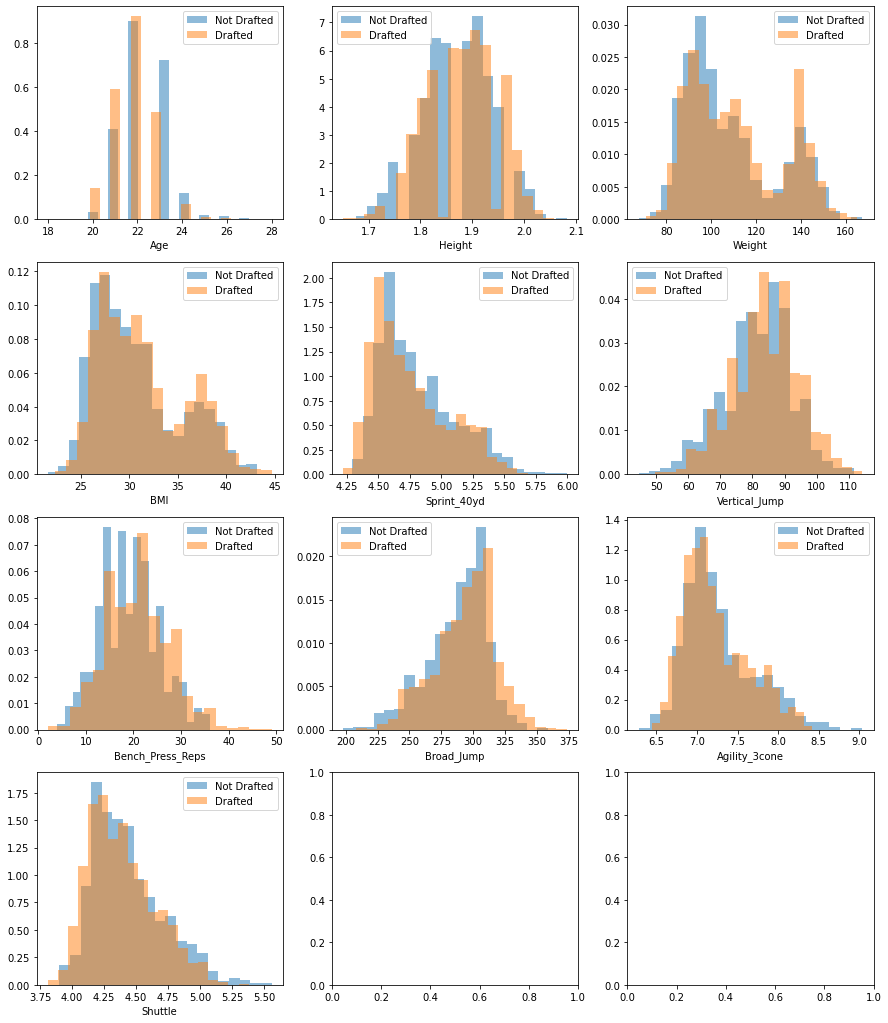

In [17]:
# Histograms of numerical data
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(15,18))

cols = ['Age','Height','Weight','BMI','Sprint_40yd','Vertical_Jump','Bench_Press_Reps','Broad_Jump','Agility_3cone','Shuttle']

for i, col in enumerate(cols):
    r = i//3
    c = i%3
    
    ax[r,c].hist(df_combine[df_combine['Drafted']==0][col],bins=20,alpha=0.5,density=True,label='Not Drafted')
    ax[r,c].hist(df_combine[df_combine['Drafted']==1][col],bins=20,alpha=0.5,density=True,label='Drafted')
    ax[r,c].set_xlabel(col)
    ax[r,c].legend();

The distributions above show some very subtle differences, but it can be hard to see. Part of the reason for this might be that all the different positions are being mixed together. It might be easier to see differences if we separate the players by position.

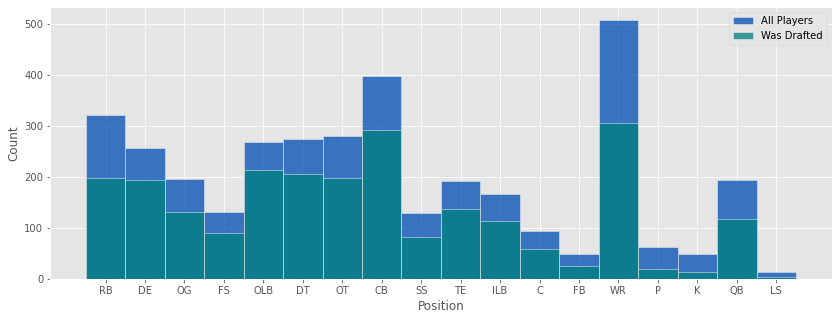

In [18]:
# Number of players at each position
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(14,5))

sns.histplot(data=df_combine, x='Position', ax=ax, color=(0.0,0.3,0.7,1.0), label='All Players')
sns.histplot(data=df_combine[df_combine['Drafted']==1], x='Position', ax=ax, color=(0.0,0.5,0.5,0.5), label='Was Drafted')
ax.legend()

Below is a histogram of players by age. It appears that the youngest players (19 and 20 years old), get drafted at a very high rate.

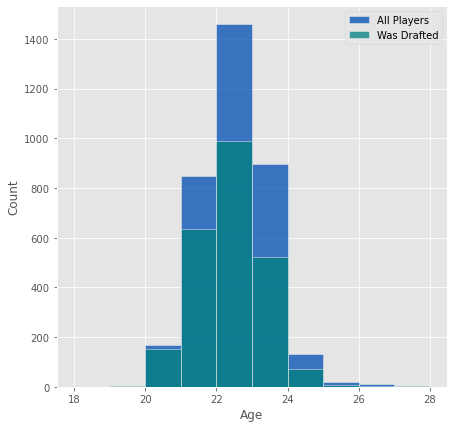

In [19]:
fig, ax = plt.subplots(figsize=(7,7))

sns.histplot(data=df_combine, x='Age', ax=ax, color=(0.0,0.3,0.7,1.0), binwidth=1, label='All Players')
sns.histplot(data=df_combine[df_combine['Drafted']==1], x='Age', ax=ax, color=(0.0,0.5,0.5,0.5), binwidth=1, label='Was Drafted')
ax.legend()

Below, I plot split violin plots for each numerical column separated by position. The violins are split so that the distribution of undrafted players is on the left and the distribution of drafted players is on the right. I also obtain the p-value for a Kolmogorov-Smirnov test to help determine which distributions are different.

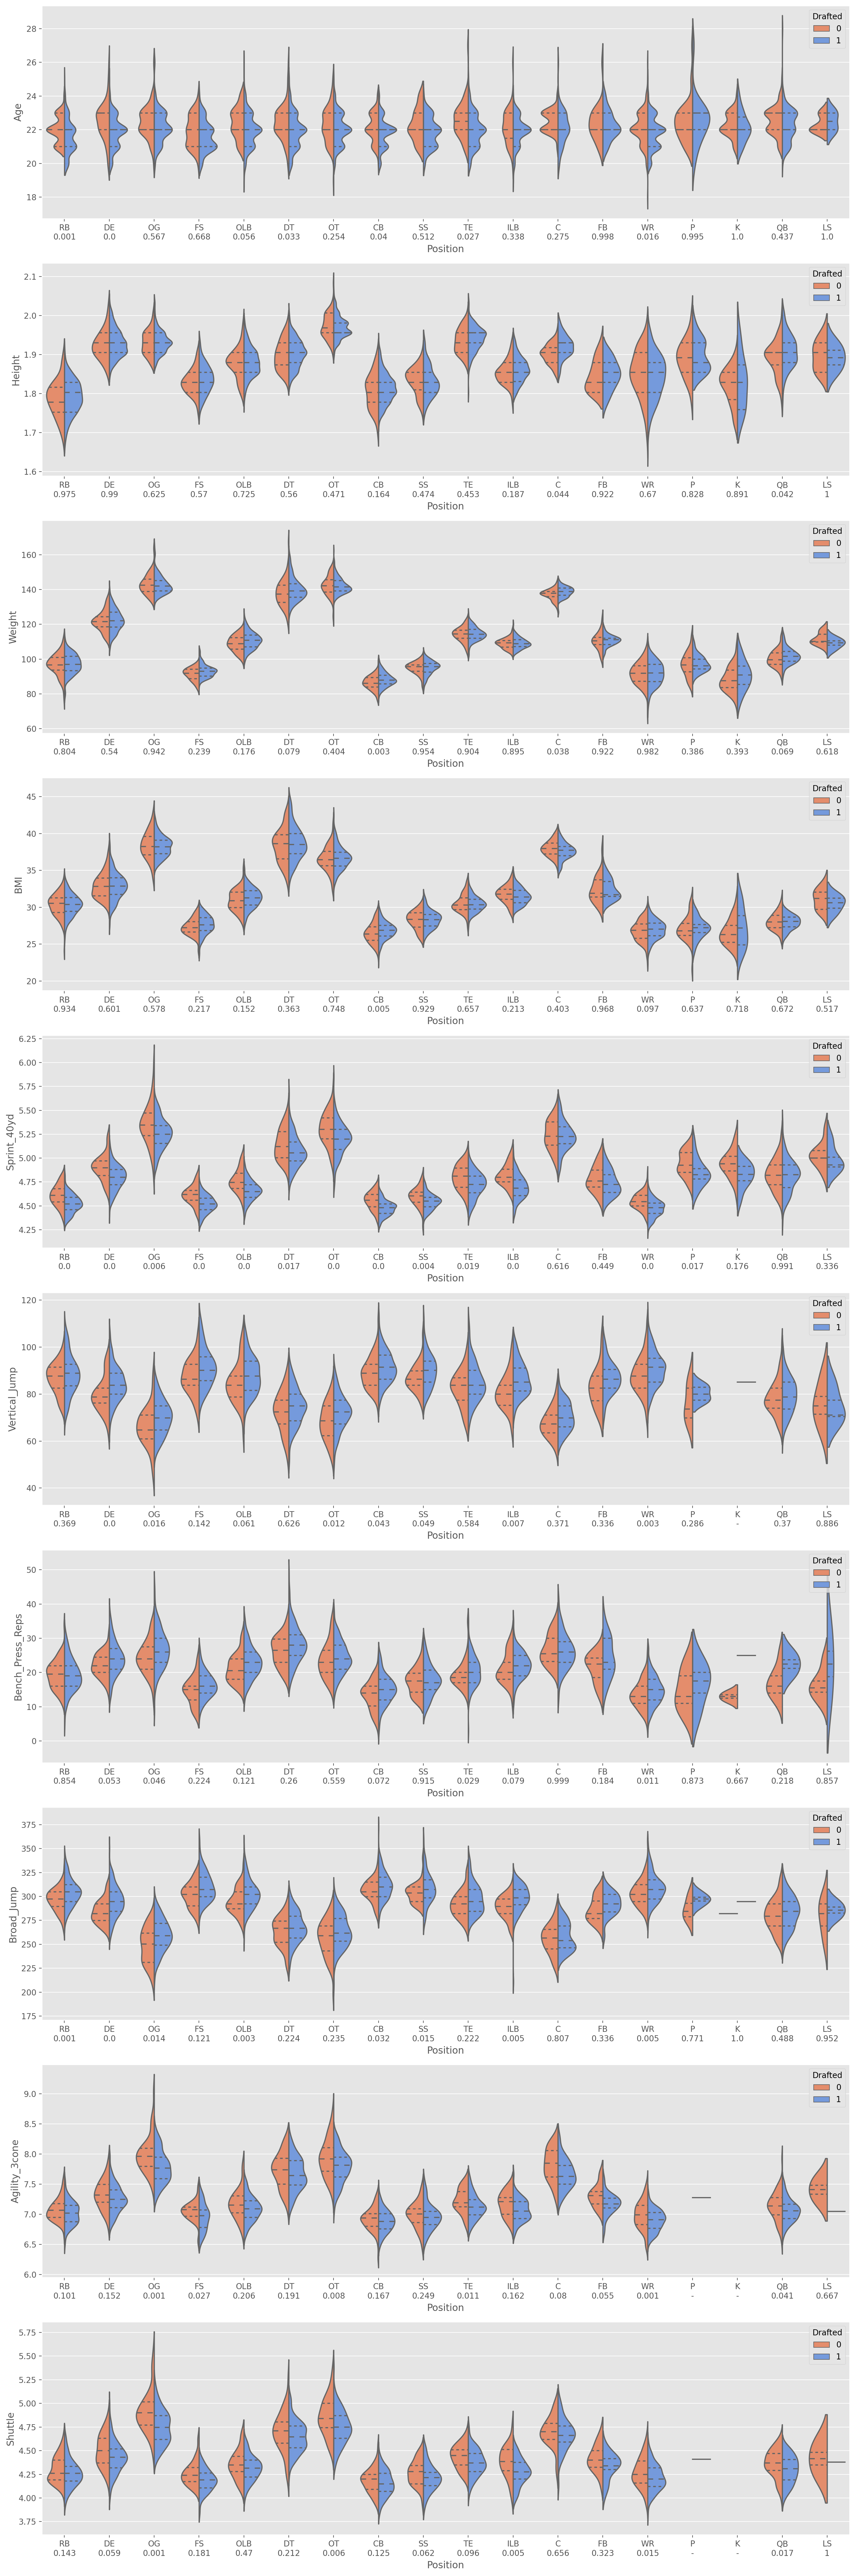

In [20]:
# Violin plots for each athletic test and each position
fig, ax = plt.subplots(nrows=10, figsize=(15,45), dpi=200)
plt.style.use('ggplot')

cols = ['Age','Height','Weight','BMI','Sprint_40yd','Vertical_Jump','Bench_Press_Reps','Broad_Jump','Agility_3cone','Shuttle']

for i, col in enumerate(cols):
    sns.violinplot(data=df_combine, x='Position', y=col, hue='Drafted', split=True, inner='quartile',
                   palette=['#f88458', '#6495ed'], ax=ax[i])
    ks_results = []
    for j, pos in enumerate(df_combine['Position'].unique()):
        try:
            ks_result = st.ks_2samp(df_combine[(df_combine['Drafted']==1) &
                                               (df_combine[col].isna()==False) &
                                               (df_combine['Position']==pos)][col],
                                    df_combine[(df_combine['Drafted']==0) &
                                               (df_combine[col].isna()==False) &
                                               (df_combine['Position']==pos)][col])
            ks_results.append(ks_result[1])
        except:
            ks_results.append("-")
    ax[i].set_xticklabels([f"{pos}\n{ks}" if ks=="-" else f"{pos}\n{round(ks,3)}" for pos, ks in zip(df_combine['Position'].unique(),ks_results)])
            
fig.tight_layout()

First, plotting the distributions for each position separately shows the drastic differences in performance on certain tests.
The classifiers will be much more accurate if the positions are taken into account.<br>

Second, there are visible differences between the drafted and undrafted players in many cases. For example, for positions where speed is considered important (wide receiver, running back, safety, cornerback), the drafted players ran the 40-yard sprint about a tenth of a second faster, a significant difference given the spread in the values is on the order of a tenth of a second.<br>

KS tests:<br>
Height: The only positions for which the KS-test p-value was below 0.05 were center (C) and quarterback (QB). In both cases, taller players were more likely to get drafted.<br>

Weight: Significant p-values are seen for cornerbacks (CB) and centers (C). In both cases, heavier players were more likely to get drafted.<br>

BMI: The only position with a significant p-value is cornerbacks (CB). Larger BMIs were more likely to be drafted.<br>

Sprint_40yd: Now we are talking. Most players do the 40-yard sprint, regardless of position. The only positions that do NOT have significant p-values from the KS-test centers (C), fullbacks (FB), kickers (K), quarterbacks (QB), and long snappers (LS). These are mostly not a surprise as most of these positions do not put great emphasis on speed (I guess the age of the running quarterback is over).

Vertical_Jump: Significant KS-test results: defensive ends (DE), offensive guards (OG), offensive tackle (OT), strong safeties (SS), inside linebackers (ILB), and wide receivers (WR). In every case, players with larger vertical jumps had a better chance of being drafted.<br>

Bench_Press_Reps: Significant KS-test results: offensive guards (OG), tight ends (TE), and wide receivers (WR). More reps (stronger) means a better chance of being drafted.

Broad_Jump: Significant KS-test results: running backs (RB), defensive ends (DE), offensive guards (OG), outside linebackers (OLB), cornerbacks (CB), strong safeties (SS), inside linebackers (ILB), and wide receivers (WR). Larger broad jumps lead to a better chance of being drafted.

Agility_3cone: Significant KS-test results: offensive guards (OG), free safeties (FS), offensive tackles (OT), tight ends (TE), wide receivers (WR), and quarterbacks (QB). Several other positions had low, but not significant p-values. Faster times lead to higher chances of being drafted.

Shuttle: Significant KS-test results: offensive guards (OG), offensive tackles (OT), inside linebackers (ILB), wide receivers (WR), and quarterbacks (QB). Faster shuttle times lead to higher chances of being drafted.

There weren't any columns that led to a significant p-value for kickers, punters, or long snappers. This is not particularly surprising; those positions have a very specific set of skills needed that are not really tested by the drills at the combine. Fullbacks also didn't have any p-values below 0.05. This is probably just because of small sample sizes (who still uses fullbacks?)

The plots and KS tests indicate that the results of the combine are going to have predictive power when trying to tell who will get drafted.

Below are more violin plots, but with the players separated by whether or not they ever made a Pro Bowl.

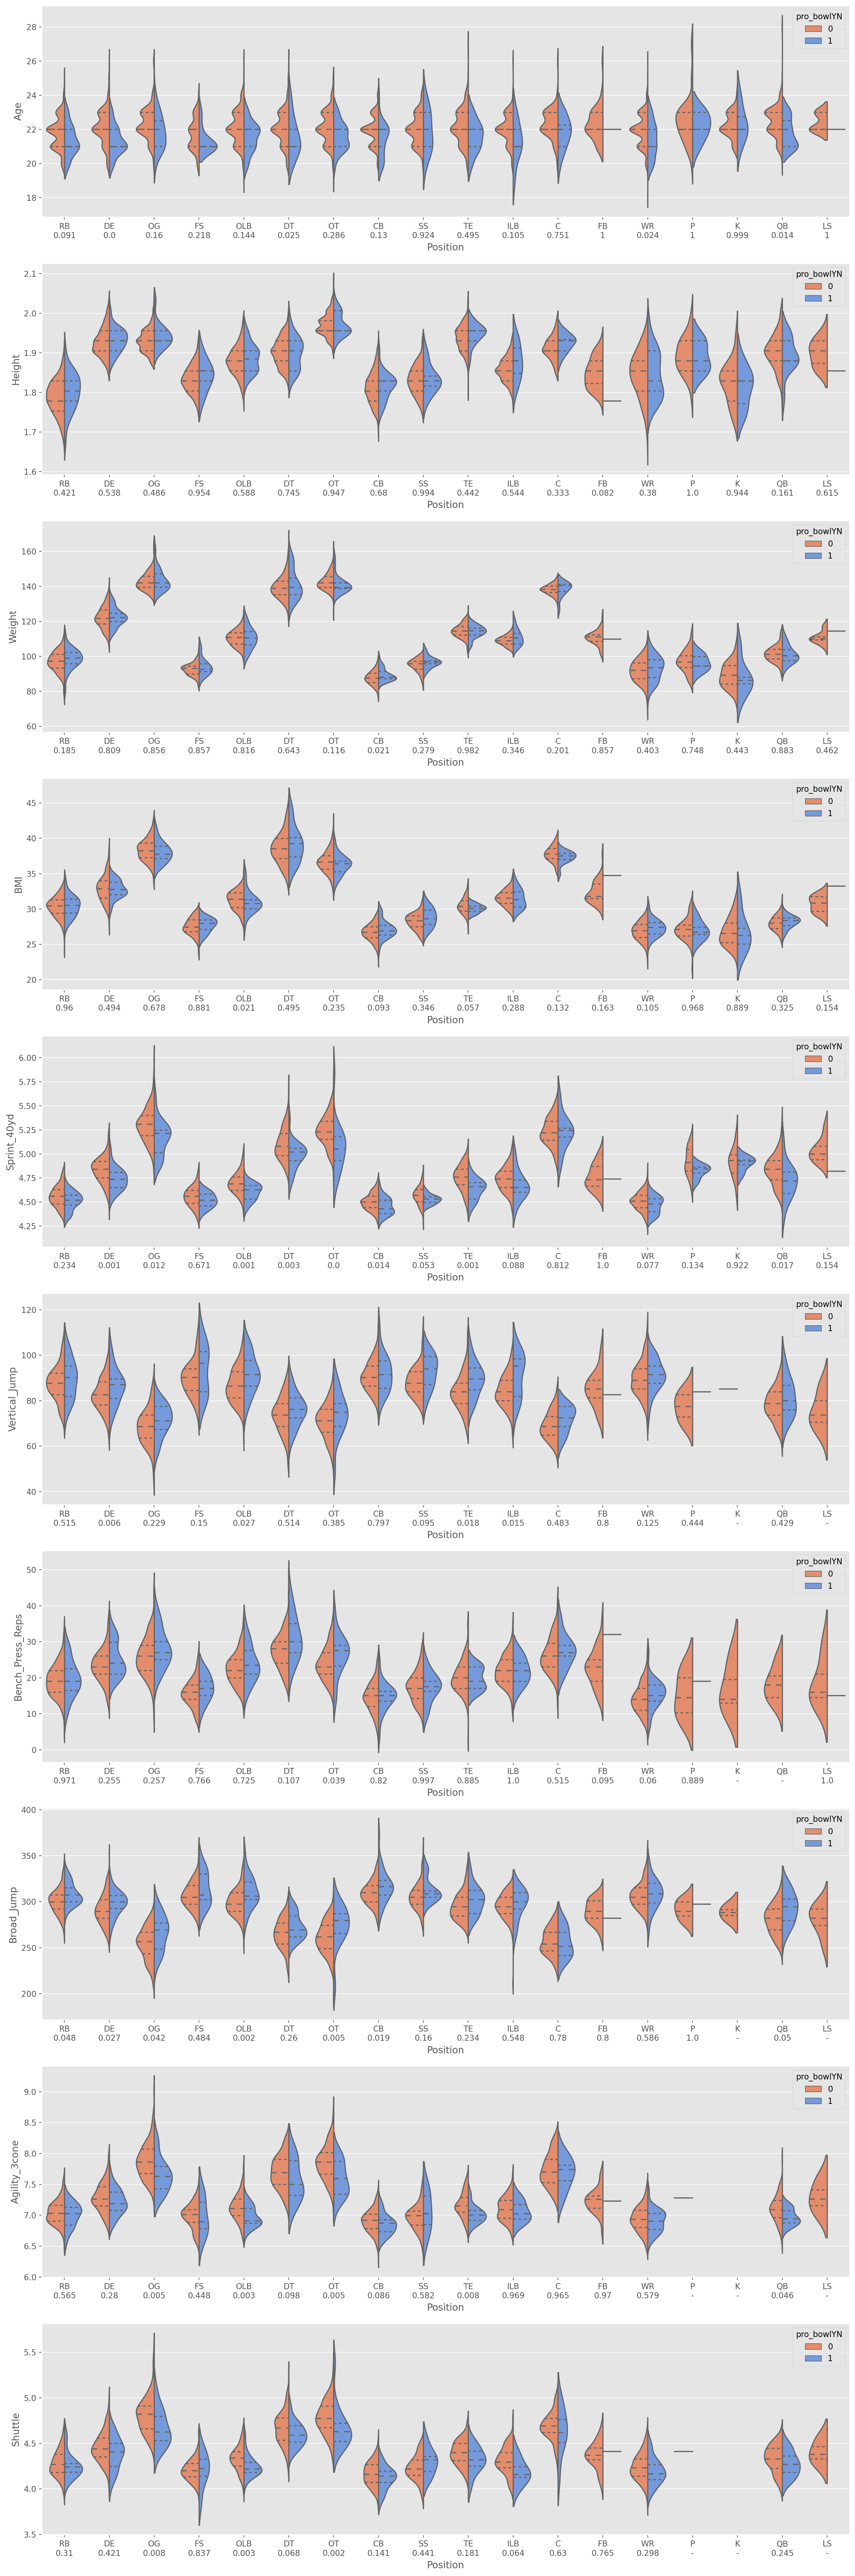

In [21]:
# Violin plots for each athletic test and each position
fig, ax = plt.subplots(nrows=10, figsize=(15,45), dpi=200)
plt.style.use('ggplot')

cols = ['Age','Height','Weight','BMI','Sprint_40yd','Vertical_Jump','Bench_Press_Reps','Broad_Jump','Agility_3cone','Shuttle']

for i, col in enumerate(cols):
    sns.violinplot(data=df_combine, x='Position', y=col, hue='pro_bowlYN', split=True, inner='quartile',
                   palette=['#f88458', '#6495ed'], ax=ax[i])
    ks_results = []
    for j, pos in enumerate(df_combine['Position'].unique()):
        try:
            ks_result = st.ks_2samp(df_combine[(df_combine['pro_bowlYN']==1) &
                                               (df_combine[col].isna()==False) &
                                               (df_combine['Position']==pos)][col],
                                    df_combine[(df_combine['pro_bowlYN']==0) &
                                               (df_combine[col].isna()==False) &
                                               (df_combine['Position']==pos)][col])
            ks_results.append(ks_result[1])
        except:
            ks_results.append("-")
    ax[i].set_xticklabels([f"{pos}\n{ks}" if ks=="-" else f"{pos}\n{round(ks,3)}" for pos, ks in zip(df_combine['Position'].unique(),ks_results)])
            
fig.tight_layout()

Similar to the previous violin plots, it looks like certain drills have some ability to predict whether somoene will make a Pro Bowl, but it also depends on the position they play.

There were not enough players at fullback, punter, or kicker who have made a Pro Bowl to calculate anything.

### Missing Values

For certain classifiers, it is important to fill missing values. As discussed before, it would not make much sense to just take the mean or median of a given column since different football positions have such different peformance on the drills. Instead, I should impute using just players of the same position.<br>

Below, I wrote a function for imputing missing values for each separate position. The function is also able to standardize the data, again treating each position separately. Some classifiers need different columns to have similar scales while others do not, hence why I made standardizing optional.

I wrote a function to do this because I eventually want to use GridSearchCV to tune hyperparameters and I need a pipeline that will process and fit the data so there is no data leakage. I do not actually think the data leakage would be significant here; the leakage would be caused by taking means of both training and validation data together when imputing rather than separately, but these means should be very close anyway. It is just good practice to write a custom function for my pipeline.

In [22]:
def ImputeAndScaleByPosition(X, split_by_position = 'default', fill_missing=True, standardize=True):
    """
    This function is a custom imputer and standard scaler that handles each
    football position separately.
    
    Input: 
    X: pandas DataFrame
    It can't just be a numpy array because the column names are needed.
    
    split_by_position: Determines which columns to split by position.
    The default is to do everything but age. Other options are 'all' or None.
    
    fill_missing: True if missing values should be replaced (default is True).
    
    standardize: True if data should be transformed to standard scale (default is True).
    
    Output: pandas DataFrame of transformed data.
    Even columns that were not transformed are passed through the function.
    """
    if split_by_position == 'default':
        # Columns where position IS NOT taken into account
        cols1 = ['Age']
    
        # Columns where position IS taken into account
        cols2 = ['Height','Weight','Sprint_40yd','Vertical_Jump','Bench_Press_Reps','Broad_Jump','Agility_3cone',
                 'Shuttle','BMI']
        
    if split_by_position == 'all':
        # Columns where position IS NOT taken into account
        cols1 = []
    
        # Columns where position IS taken into account
        cols2 = ['Age','Height','Weight','Sprint_40yd','Vertical_Jump','Bench_Press_Reps','Broad_Jump','Agility_3cone',
                 'Shuttle','BMI']

    if split_by_position == None:
        # Columns where position IS NOT taken into account
        cols1 = ['Age','Height','Weight','Sprint_40yd','Vertical_Jump','Bench_Press_Reps','Broad_Jump','Agility_3cone',
                 'Shuttle','BMI']
    
        # Columns where position IS taken into account
        cols2 = []

    Xcopy = X.copy()

    for col in cols1:
        if fill_missing:
            Xcopy.loc[Xcopy[col].isna()==True,col] = X.loc[X[col].isna()==False,col].mean()
        
        if standardize:
            Xcopy[col] -= X.loc[X[col].isna()==False,col].mean()
            Xcopy[col] /= X.loc[X[col].isna()==False,col].std()

    for col in cols2:
        for pos in Xcopy['Position'].unique():
            if sum((X[col].isna()==False) & (X['Position']==pos)) > 2:
                # Impute mean
                if fill_missing:
                    Xcopy.loc[(Xcopy[col].isna()==True) & (Xcopy['Position']==pos),col] = \
                    X.loc[(X[col].isna()==False) & (X['Position']==pos),col].mean()
                
                if standardize:
                    # Subtract mean
                    Xcopy.loc[Xcopy['Position']==pos,col] -= X.loc[(X[col].isna()==False) & (X['Position']==pos),col].mean()
                    # Divide by standard deviation
                    Xcopy.loc[Xcopy['Position']==pos,col] /= X.loc[(X[col].isna()==False) & (X['Position']==pos),col].std()
                    
            # Depending on the split, there might not have been any data to make a mean or std from.
            # Just use whole dataset in this case.
            else:
                # Impute mean
                if fill_missing:
                    Xcopy.loc[(Xcopy[col].isna()==True) & (Xcopy['Position']==pos),col] = \
                    X.loc[X[col].isna()==False,col].mean()
                
                if standardize:
                    # Subtract mean
                    Xcopy.loc[Xcopy['Position']==pos,col] -= X.loc[X[col].isna()==False,col].mean()
                    # Divide by standard deviation
                    Xcopy.loc[Xcopy['Position']==pos,col] /= X.loc[X[col].isna()==False,col].std()

    return Xcopy

In [23]:
# Try out function
df_fill = ImputeAndScaleByPosition(df_combine)
df_fill

Year            Player       Age        School    Height    Weight  \
0     2009      Beanie Wells -2.057429      Ohio St.  1.462241  1.589628   
1     2009        Will Davis -0.022988      Illinois -1.372217 -0.604464   
2     2009    Herman Johnson  2.011453           LSU  2.519135  4.064537   
3     2009    Rashad Johnson  0.994232       Alabama -0.900537 -0.156677   
4     2009        Cody Brown -0.022988   Connecticut -0.045629  0.056673   
...    ...               ...       ...           ...       ...       ...   
3570  2019       Jalen Jelks -0.022988        Oregon  1.037763 -0.969300   
3571  2019     Chris Slayton -0.022988      Syracuse  0.782574 -0.046170   
3572  2019   Javon Patterson -1.040208   Mississippi -0.299587  0.361851   
3573  2019      Dakota Allen  0.994232    Texas Tech -0.675117 -1.299107   
3574  2019  Jordan Brailford  0.994232  Oklahoma St.  0.633663  0.797571   

      Sprint_40yd  Vertical_Jump  Bench_Press_Reps  Broad_Jump  ...  Position  \
0       -1.585033      -0.349712          1.239326    1.722030  ...        RB   
1        0.127388       0.065980          0.722462   -0.026856  ...        DE   
2        1.148935       0.000000         -0.902263    0.000000  ...        OG   
3       -0.584485       0.471376         -0.231025   -0.196718  ...        FS   
4        0.661650       0.663379          0.724782    0.265810  ...       OLB   
...           ...            ...               ...         ...  ...       ...   
3570     0.709398      -0.100910         -0.999512   -0.341665  ...        DE   
3571     0.221823      -0.060600          0.031218   -0.616411  ...        DT   
3572    -0.676696       0.071673          0.125524   -0.545525  ...         C   
3573     0.269931      -0.647072          0.267538   -0.040001  ...       ILB   
3574    -0.288813       0.977159         -0.150822    1.256622  ...       OLB   

      Drafted  player_code pro_bowls pro_bowlYN                  Team  Round  \
0           1     WellCh00         0          0    Arizona Cardinals     1.0   
1           1     DaviWi99         0          0    Arizona Cardinals     6.0   
2           1     JohnHe23         0          0    Arizona Cardinals     5.0   
3           1     JohnRa98         0          0    Arizona Cardinals     3.0   
4           1     BrowCo96         0          0    Arizona Cardinals     2.0   
...       ...          ...       ...        ...                   ...    ...   
3570        1     JelkJa00         0          0       Dallas Cowboys     7.0   
3571        1     SlayCh00         0          0      New York Giants     7.0   
3572        1     PattJa00         0          0   Indianapolis Colts     7.0   
3573        1     AlleDa01         0          0     Los Angeles Rams     7.0   
3574        1     BraiJo00         0          0  Washington Redskins     7.0   

       Pick  Missing_Athletic_Tests  school_group  
0      31.0                       2             1  
1     204.0                       0             2  
2     167.0                       4             1  
3      95.0                       0             1  
4      63.0                       0             2  
...     ...                     ...           ...  
3570  241.0                       0             1  
3571  245.0                       1             3  
3572  246.0                       0             2  
3573  251.0                       0             3  
3574  253.0                       2             2  

[3575 rows x 25 columns]

After running the function, any player that did not complete a test at the Combine should now have a 0.0 in its place (to indicate a z-score of 0) if standardize was left as True. If standardize was set to False, then each missing test should be equal to the mean for all of the players of the same position.

Below, we can see that out of 48 kickers, none did the Agility_3cone or Shuttle drills, and 3 or fewer did Vertical_Jump, Bench_Press_Reps, and Broad_Jump. A similar story is seen with punters. I am going to cut both from the dataset because both positions put great emphasis on a specific skill (kicking) and that skill is not captured in the Combine.

I am going to cut long snappers from the dataset because there are so few of them.

There will still be 3451 players in the dataset.

In [24]:
df_combine[df_combine['Position']=='K'].describe()

Year        Age     Height      Weight  Sprint_40yd  \
count    48.00000  47.000000  48.000000   48.000000    35.000000   
mean   2013.87500  22.234043   1.822979   88.979703     4.910000   
std       3.07789   0.757937   0.051933    7.379699     0.146348   
min    2009.00000  21.000000   1.727200   74.389149     4.570000   
25%    2011.00000  22.000000   1.778000   83.914588     4.805000   
50%    2014.00000  22.000000   1.828800   87.770124     4.930000   
75%    2016.00000  23.000000   1.854200   94.460611     4.960000   
max    2019.00000  24.000000   1.955800  107.047799     5.250000   

       Vertical_Jump  Bench_Press_Reps  Broad_Jump  Agility_3cone  Shuttle  \
count           1.00               3.0    2.000000            0.0      0.0   
mean           85.09              17.0  288.290000            NaN      NaN   
std              NaN               7.0    8.980256            NaN      NaN   
min            85.09              12.0  281.940000            NaN      NaN   
25%            85.09              13.0  285.115000            NaN      NaN   
50%            85.09              14.0  288.290000            NaN      NaN   
75%            85.09              19.5  291.465000            NaN      NaN   
max            85.09              25.0  294.640000            NaN      NaN   

             BMI    Drafted  pro_bowls  pro_bowlYN      Round        Pick  \
count  48.000000  48.000000  48.000000   48.000000  14.000000   14.000000   
mean   26.782084   0.291667   0.125000    0.125000   5.285714  167.857143   
std     2.049076   0.459340   0.334219    0.334219   1.325987   44.810468   
min    23.352095   0.000000   0.000000    0.000000   2.000000   59.000000   
25%    25.219195   0.000000   0.000000    0.000000   5.000000  155.000000   
50%    26.355920   0.000000   0.000000    0.000000   5.000000  168.500000   
75%    27.896846   1.000000   0.000000    0.000000   6.000000  176.500000   
max    31.464534   1.000000   1.000000    1.000000   7.000000  233.000000   

       Missing_Athletic_Tests  school_group  
count               48.000000     48.000000  
mean                 5.145833      1.770833  
std                  0.618495      0.805291  
min                  3.000000      1.000000  
25%                  5.000000      1.000000  
50%                  5.000000      2.000000  
75%                  5.250000      2.000000  
max                  6.000000      3.000000

In [25]:
# Cut kickers, punters, and long snappers
df_combine.drop(df_combine[df_combine['Position'].isin(['K','P','LS'])].index, inplace=True)
df_combine

Year            Player   Age        School    Height      Weight  \
0     2009      Beanie Wells  20.0      Ohio St.  1.854200  106.594207   
1     2009        Will Davis  22.0      Illinois  1.879600  118.387609   
2     2009    Herman Johnson  24.0           LSU  2.006600  165.107623   
3     2009    Rashad Johnson  23.0       Alabama  1.803400   92.079251   
4     2009        Cody Brown  22.0   Connecticut  1.879600  110.676538   
...    ...               ...   ...           ...       ...         ...   
3570  2019       Jalen Jelks  22.0        Oregon  1.965325  116.119647   
3571  2019     Chris Slayton  22.0      Syracuse  1.930400  139.252858   
3572  2019   Javon Patterson  21.0   Mississippi  1.905000  139.252858   
3573  2019      Dakota Allen  23.0    Texas Tech  1.838325  105.233430   
3574  2019  Jordan Brailford  23.0  Oklahoma St.  1.905000  114.305277   

      Sprint_40yd  Vertical_Jump  Bench_Press_Reps  Broad_Jump  ...  Position  \
0            4.38          85.09              25.0      325.12  ...        RB   
1            4.84          83.82              27.0      292.10  ...        DE   
2            5.50            NaN              21.0         NaN  ...        OG   
3            4.49          93.98              15.0      304.80  ...        FS   
4            4.76          92.71              26.0      304.80  ...       OLB   
...           ...            ...               ...         ...  ...       ...   
3570         4.92          82.55              19.0      287.02  ...        DE   
3571         5.13          73.66              28.0      256.54  ...        DT   
3572         5.13          69.85              27.0      248.92  ...         C   
3573         4.77          80.01              23.0      294.64  ...       ILB   
3574         4.65          95.25              22.0      320.04  ...       OLB   

      Drafted  player_code pro_bowls pro_bowlYN                  Team  Round  \
0           1     WellCh00         0          0    Arizona Cardinals     1.0   
1           1     DaviWi99         0          0    Arizona Cardinals     6.0   
2           1     JohnHe23         0          0    Arizona Cardinals     5.0   
3           1     JohnRa98         0          0    Arizona Cardinals     3.0   
4           1     BrowCo96         0          0    Arizona Cardinals     2.0   
...       ...          ...       ...        ...                   ...    ...   
3570        1     JelkJa00         0          0       Dallas Cowboys     7.0   
3571        1     SlayCh00         0          0      New York Giants     7.0   
3572        1     PattJa00         0          0   Indianapolis Colts     7.0   
3573        1     AlleDa01         0          0     Los Angeles Rams     7.0   
3574        1     BraiJo00         0          0  Washington Redskins     7.0   

       Pick  Missing_Athletic_Tests  school_group  
0      31.0                       2             1  
1     204.0                       0             2  
2     167.0                       4             1  
3      95.0                       0             1  
4      63.0                       0             2  
...     ...                     ...           ...  
3570  241.0                       0             1  
3571  245.0                       1             3  
3572  246.0                       0             2  
3573  251.0                       0             3  
3574  253.0                       2             2  

[3451 rows x 25 columns]

Before I actually start fitting any models, I want to see how much each individual attribute does at separating drafted and undrafted players at each position. To do this, I consider each combination of attribute and position, I loop through different cutoff values of the attribute, and I calculate which cutoff gives the highest accuracy.<br>

This should give me a sense of which attributes matter the most, which attributes are more important for each position, and for which positions I should expect to make more accurate predictions.

In [26]:
cols = ['Height','Weight','BMI','Sprint_40yd','Vertical_Jump','Bench_Press_Reps','Broad_Jump','Agility_3cone','Shuttle']

n_vals = 100

cutoffs = np.zeros((len(cols),len(df_combine['Position'].unique())))
accuracy = np.zeros((len(cols),len(df_combine['Position'].unique())))
recall0 = np.zeros((len(cols),len(df_combine['Position'].unique())))
recall1 = np.zeros((len(cols),len(df_combine['Position'].unique())))
precision0 = np.zeros((len(cols),len(df_combine['Position'].unique())))
precision1 = np.zeros((len(cols),len(df_combine['Position'].unique())))

for i, col in enumerate(cols):
    for j, pos in enumerate(df_combine['Position'].unique()):
        min_val = np.min(df_combine[df_combine['Position']==pos][col])
        max_val = np.max(df_combine[df_combine['Position']==pos][col])
        delta = (max_val - min_val) / n_vals
        val = min_val
        mean0 = np.mean(df_combine[(df_combine['Position']==pos) & (df_combine['Drafted']==0)][col])
        mean1 = np.mean(df_combine[(df_combine['Position']==pos) & (df_combine['Drafted']==1)][col])
        best_val = min_val
        best_acc = 0.0
        best_recall_precision = [0.0, 0.0, 0.0, 0.0]
        while val <= max_val:
            if mean1 > mean0:
                TN = sum(df_combine[(df_combine['Position']==pos) & (df_combine['Drafted']==0)][col]<val)
                FP = sum(df_combine[(df_combine['Position']==pos) & (df_combine['Drafted']==0)][col]>val)
                FN = sum(df_combine[(df_combine['Position']==pos) & (df_combine['Drafted']==1)][col]<val)
                TP = sum(df_combine[(df_combine['Position']==pos) & (df_combine['Drafted']==1)][col]>val)
                # If on the cutoff, split it evenly
                TN += sum(df_combine[(df_combine['Position']==pos) & (df_combine['Drafted']==0)][col]==val)/2
                FP += sum(df_combine[(df_combine['Position']==pos) & (df_combine['Drafted']==0)][col]==val)/2
                FN += sum(df_combine[(df_combine['Position']==pos) & (df_combine['Drafted']==1)][col]==val)/2
                TP += sum(df_combine[(df_combine['Position']==pos) & (df_combine['Drafted']==1)][col]==val)/2
                
            else:
                TN = sum(df_combine[(df_combine['Position']==pos) & (df_combine['Drafted']==0)][col]>val)
                FP = sum(df_combine[(df_combine['Position']==pos) & (df_combine['Drafted']==0)][col]<=val)
                FN = sum(df_combine[(df_combine['Position']==pos) & (df_combine['Drafted']==1)][col]>val)
                TP = sum(df_combine[(df_combine['Position']==pos) & (df_combine['Drafted']==1)][col]<=val)
                # If on the cutoff, split it evenly
                TN += sum(df_combine[(df_combine['Position']==pos) & (df_combine['Drafted']==0)][col]==val)/2
                FP += sum(df_combine[(df_combine['Position']==pos) & (df_combine['Drafted']==0)][col]==val)/2
                FN += sum(df_combine[(df_combine['Position']==pos) & (df_combine['Drafted']==1)][col]==val)/2
                TP += sum(df_combine[(df_combine['Position']==pos) & (df_combine['Drafted']==1)][col]==val)/2
                
            # Normal accuracy
            acc = (TN + TP) / (TN + FP + FN + TP)
            # Balanced accuracy
            #acc = TN / (TN + FP) / 2 + TP / (TP + FN) / 2
            
            if acc > best_acc:
                best_acc = acc
                best_val = val
                best_recall_precision = [TN/(TN+FP), TP/(TP+FN), TN/(TN+FN), TP/(TP+FP)]

            val += delta
            
        cutoffs[i,j] = best_val
        accuracy[i,j] = best_acc
        recall0[i,j] = best_recall_precision[0]
        recall1[i,j] = best_recall_precision[1]
        precision0[i,j] = best_recall_precision[2]
        precision1[i,j] = best_recall_precision[3]        

The figure below represents the accuracy I would achieve just by using one attribute for each position.<br>

For example, The pixel corresponding to Sprint_40yd and RB is equal to 70.3. This means that if I only used Sprint_40yd to predict which running backs were drafted, I would expect an accuracy of about 70.3%.<br>

One caveat is that these numbers do not take into account missing data. I could potentially achieve lower accuracy just because the model struggles to make predictions for players who did not complete all of the athletic drills.

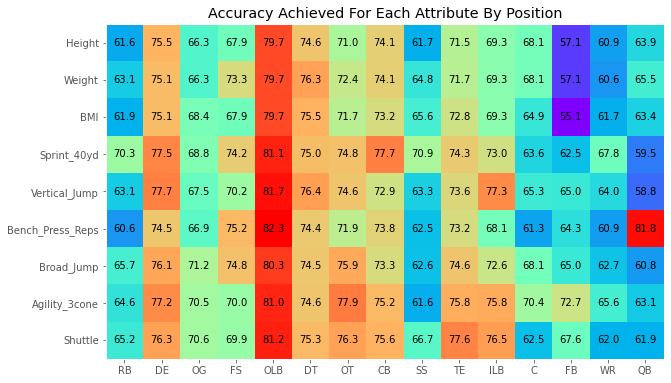

In [27]:
fig, ax = plt.subplots(figsize=(10,10))

ax.grid(False)
ax.imshow(accuracy, cmap='rainbow')
ax.set_yticks(np.arange(len(cols)))
ax.set_yticklabels(cols)
ax.set_xticks(np.arange(len(df_combine['Position'].unique())))
ax.set_xticklabels(df_combine['Position'].unique())
ax.set_title('Accuracy Achieved For Each Attribute By Position')
for i in np.arange(len(cols)):
    for j in np.arange(len(df_combine['Position'].unique())):
        ax.text(j,i,round(100*accuracy[i,j],1), horizontalalignment='center', verticalalignment='center');

The figure indicates that it will be easier to make predictions for certain positions. For example, all of the attributes achieved an accuracy above 79% for outside linebackers (OLB), so I should expect at least that level of accuracy for that position. However, wide receivers had accuracies between 60% and 68%, much lower than for most of the other positions. Hypothetically, it might still be possible to achieve an accuracy higher than 68% by combining the attributes together, which the models will do, but it is still reasonable to think that it will be difficult to make accurate predictions for wide receivers.<br>

Overall, the positions that are considered "skill positions" appear to have lower accuracies. These include RB, WR, and QB. This is not really a surprise. These positions are called "skill positions" because there are specific skills like throwing and catching that are not reflected in the Combine data. This means that there is other information that scouts use to evaluate these players other than how fast and athletic they are.

The plot below is similar to the one above, except that the numbers represent the cutoffs that achieve the highest accuracy. The pixels are still color-coded based on accuracy.

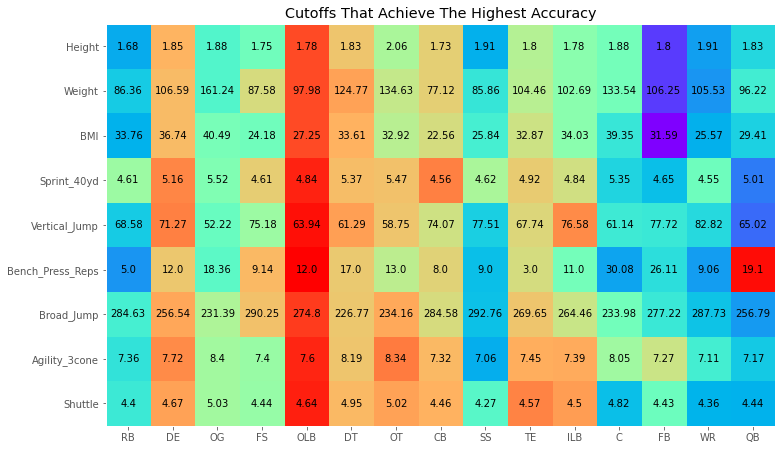

In [28]:
fig, ax = plt.subplots(figsize=(12,12))

ax.grid(False)
ax.imshow(accuracy, cmap='rainbow')
ax.set_yticks(np.arange(len(cols)))
ax.set_yticklabels(cols)
ax.set_xticks(np.arange(len(df_combine['Position'].unique())))
ax.set_xticklabels(df_combine['Position'].unique())
ax.set_title('Cutoffs That Achieve The Highest Accuracy')
for i in np.arange(len(cols)):
    for j in np.arange(len(df_combine['Position'].unique())):
        ax.text(j,i,round(cutoffs[i,j],2), horizontalalignment='center', verticalalignment='center');

Some of the numbers above actually correspond to the maximum or minimum value recorded for that combination. This means that the highest acccuracy was achived by simply assuming all players were drafted.

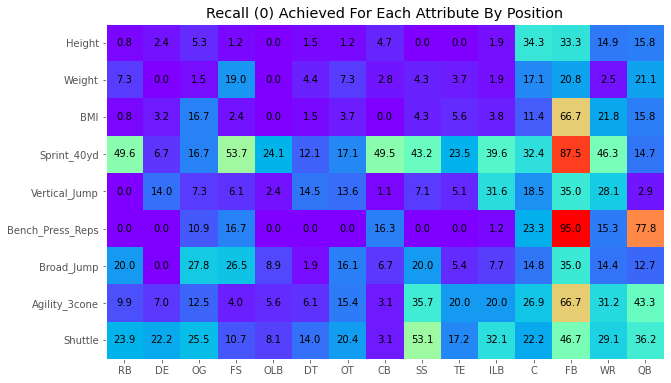

In [29]:
fig, ax = plt.subplots(figsize=(10,10))

ax.grid(False)
ax.imshow(recall0, cmap='rainbow')
ax.set_yticks(np.arange(len(cols)))
ax.set_yticklabels(cols)
ax.set_xticks(np.arange(len(df_combine['Position'].unique())))
ax.set_xticklabels(df_combine['Position'].unique())
ax.set_title('Recall (0) Achieved For Each Attribute By Position')
for i in np.arange(len(cols)):
    for j in np.arange(len(df_combine['Position'].unique())):
        ax.text(j,i,round(100*recall0[i,j],1), horizontalalignment='center', verticalalignment='center');

# Classification Models

Below, I iteratively create models using each of the following types of classifiers:<br>
1. Logistic Regression
2. Decision Tree
3. K Nearest Neighbors
4. Naive Bayes
5. Random Forest
6. XGBoost

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, RocCurveDisplay
from xgboost import XGBClassifier
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as Pipe

Below, I set a random seed that will be used for the train_test_split for every model

In [31]:
rand_seed = 23

I am going to be iteratively fitting models. Each time I fit a model, I want to look at the classification report for both the training and test data, the confusion matrix, and the accuracy for each position (for the test data). I write a function below to do that.

In [32]:
# Function for displaying results of a model
def display_model_results(y_train, y_train_pred, y_test, y_test_pred, df):
    """
    Function for displaying the results of fitting a model.
    The function will display the following:
    1. Classification report for both training and test data.
    2. Confusion matrix for the test data.
    3. Accuracy for each position for the test data.
    
    Input: 
    y_train: Actual class for training data
    y_train_pred: Predicted class for training data
    y_test: Actual class for test data
    y_test_pred: Predicted class for test data
    df: Original dataframe
    """
    print('Training:')
    print(classification_report(y_train, y_train_pred))
    print('Test:')
    print(classification_report(y_test, y_test_pred))

    df_test = df.loc[y_test.index]
    accuracy_by_pos = np.zeros(len(df['Position'].unique()))
    for i, pos in enumerate(df['Position'].unique()):
        accuracy_by_pos[i] = sum(df_test[df_test['Position']==pos]['Drafted']==y_test_pred[df_test['Position']==pos])/\
        sum(df_test['Position']==pos)

    fig, ax = plt.subplots(ncols=2, figsize=(15,5))
    ax[0].grid(False)
    cf = confusion_matrix(y_test, y_test_pred)
    ConfusionMatrixDisplay(cf, display_labels=['Not Drafted', 'Drafted']).plot(ax=ax[0])

    ax[1].bar(np.arange(len(df['Position'].unique())),accuracy_by_pos)
    ax[1].set_xticks(np.arange(len(df['Position'].unique())))
    ax[1].set_xticklabels(df['Position'].unique())
    ax[1].set_ylabel('Accuracy');

## Logistic Regression

A logistic regression model cannot handle missing values, therefore, I will use the ImputeAndScaleByPosition function that I wrote to fill missing values. Technically, a logistic regression model does not require rescaling (if all the values in a column doubled, then you could compensate for that by halving the corresponding coefficient). However, if the logistic regression uses regularization to punish large parameter values, then scaling values to a common scale becomes important. Therefore, I also rescale the numerical values.

**Model 1: Baseline Logistic Regression**<br>

Below, I fit a logistic regression model WITHOUT treating the positions separately when imputing and scaling.<br>
The model still takes into account position by one-hot-encoding the positions.

In [128]:
# Define X and y
X = df_combine[['Age','Height','Weight','Sprint_40yd','Vertical_Jump','Bench_Press_Reps','Broad_Jump','Agility_3cone',
             'Shuttle','BMI','Position','school_group']]
y = df_combine['Drafted']

# Split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=rand_seed, test_size=0.25)

# Apply imputer and scaler (not taking into account position)
X_train = ImputeAndScaleByPosition(X_train, split_by_position=None)
X_test = ImputeAndScaleByPosition(X_test, split_by_position=None)

# Apply get_dummies to separate categorical data into columns
X_train = pd.get_dummies(X_train, columns=['Position','school_group'])
X_test = pd.get_dummies(X_test, columns=['Position','school_group'])

Training:
              precision    recall  f1-score   support

           0       0.62      0.31      0.41       808
           1       0.74      0.91      0.82      1780

    accuracy                           0.72      2588
   macro avg       0.68      0.61      0.62      2588
weighted avg       0.71      0.72      0.69      2588

Test:
              precision    recall  f1-score   support

           0       0.69      0.32      0.43       285
           1       0.73      0.93      0.82       578

    accuracy                           0.73       863
   macro avg       0.71      0.62      0.63       863
weighted avg       0.72      0.73      0.69       863



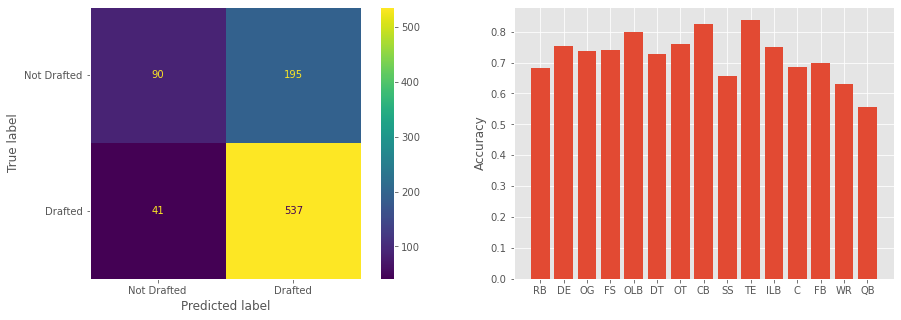

In [129]:
# Instantiate LogisticRegressionModel
logreg = LogisticRegression(C=1e12, random_state=42, solver='lbfgs', max_iter=5000)

# Fit model
logreg.fit(X_train, y_train)

# Get predictions
y_train_pred = logreg.predict(X_train)
y_test_pred = logreg.predict(X_test)

display_model_results(y_train, y_train_pred, y_test, y_test_pred, df_combine)

First, the model does not appear to be overfitting since the test data had a very similar accuracy as the training data.<br>

The model is good at identifying players who will be drafted (93% recall), but struggles with players who will not be drafted (32% recall).<br>

The model performed the worst on quarterbacks (55% accuracy). I am not surprised by this; I expect skill positions to be harder to predict based solely on Combine performance.

I am going to look at the ROC curve and AUC score for each model I make. I will use these to help evaluate whether the models are getting better as I iterate.

AUC: 0.7293996236265403


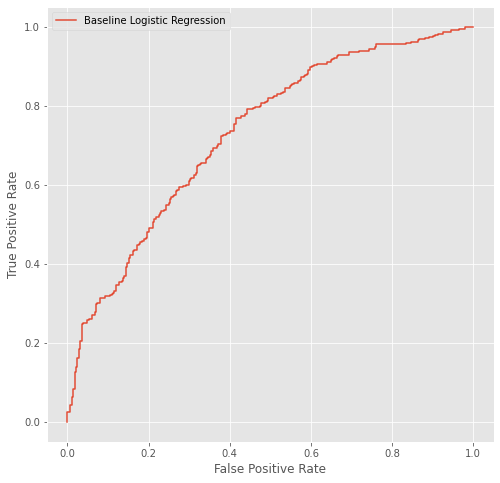

In [131]:
# Plot ROC curve
y_test_pred_prob = logreg.predict_proba(X_test)
fig_roc, ax_roc = plt.subplots(figsize=(8,8))

fpr, tpr, thresh = roc_curve(y_test, y_test_pred_prob[:,1])
print('AUC:',auc(fpr, tpr))

ax_roc.plot(fpr, tpr, label='Baseline Logistic Regression')

ax_roc.set_xlabel('False Positive Rate')
ax_roc.set_ylabel('True Positive Rate')
ax_roc.legend()

**Model 2: Impute and Scale Each Position Separately**

Next, I run the same model, but with imputing and scaling done separately for each column taking into account position.<br>
Note: The Age column still does not take into account position, but Height, Weight, and BMI will since I expect those to be different for different positions.

The logistic regression model will not fit an intercept now since each position effectively has its own intercept.

In [132]:
# Define X and y
X = df_combine[['Age','Height','Weight','Sprint_40yd','Vertical_Jump','Bench_Press_Reps','Broad_Jump','Agility_3cone',
             'Shuttle','BMI','Position','school_group']]
y = df_combine['Drafted']

# Split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=rand_seed, test_size=0.25)

# Apply imputer and scaler
X_train = ImputeAndScaleByPosition(X_train)
X_test = ImputeAndScaleByPosition(X_test)

# Apply get_dummies to separate categorical data into columns
X_train = pd.get_dummies(X_train, columns=['Position','school_group'])
X_test = pd.get_dummies(X_test, columns=['Position','school_group'])

Training:
              precision    recall  f1-score   support

           0       0.63      0.36      0.46       808
           1       0.76      0.90      0.82      1780

    accuracy                           0.73      2588
   macro avg       0.69      0.63      0.64      2588
weighted avg       0.72      0.73      0.71      2588

Test:
              precision    recall  f1-score   support

           0       0.72      0.33      0.46       285
           1       0.74      0.94      0.83       578

    accuracy                           0.74       863
   macro avg       0.73      0.63      0.64       863
weighted avg       0.73      0.74      0.70       863



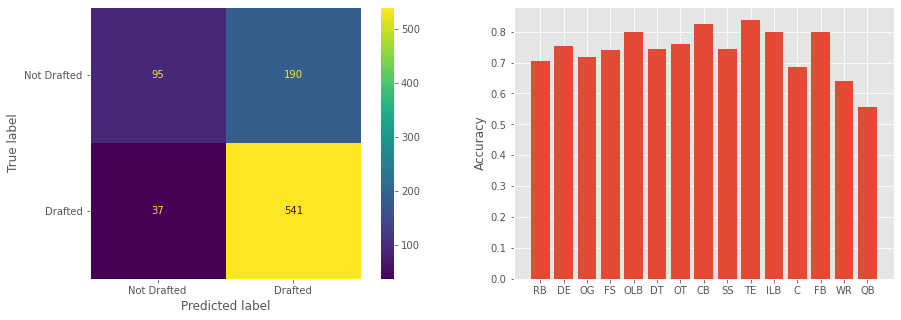

In [133]:
# Instantiate LogisticRegressionModel
logreg = LogisticRegression(C=1e12, random_state=42, solver='lbfgs', max_iter=5000, fit_intercept=False)

# Fit model
logreg.fit(X_train, y_train)

# Get predictions
y_train_pred = logreg.predict(X_train)
y_test_pred = logreg.predict(X_test)

display_model_results(y_train, y_train_pred, y_test, y_test_pred, df_combine)

The fit got slightly better as both the training and test data achieved 1% higher accuracy. The overall performance is not that much better, though.<br>

The model had similar performance on quarterbacks.

Below, I look at the coefficients for the model. The positive coefficients are in blue while negative coefficients are in red.

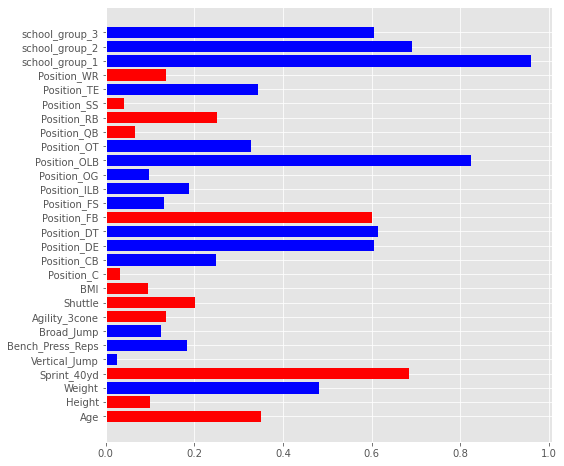

In [134]:
# Look at the coefficients for the model
fig, ax = plt.subplots(figsize=(8,8))

ax.barh(np.arange(len(X_train.columns)), np.abs(logreg.coef_[0]), color=['blue' if x>0 else 'red' for x in logreg.coef_[0]])
ax.set_yticks(np.arange(len(X_train.columns)))
ax.set_yticklabels(X_train.columns);

The largest coefficients are school_group_1, Position_OLB, Position_FB, and Sprint_40yd.<br>

The large value of school_group_1 indicates that players from the group 1 schools (the 21 schools that send the most players to the Combine) tend to get drafted more often than other players.

The other large coefficients indicate that OLB get drafted at a higher rate than other positions, FB get drafed the least often, and the test that carries the most weight is the 40-yard sprint.

AUC: 0.7414557154131003


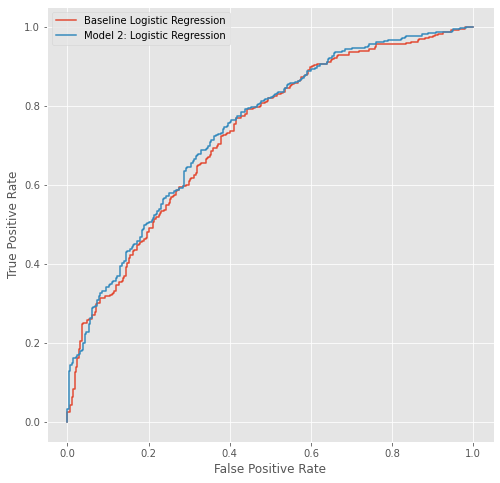

In [135]:
# Update ROC curve
y_test_pred_prob = logreg.predict_proba(X_test)

fpr, tpr, thresh = roc_curve(y_test, y_test_pred_prob[:,1])
print('AUC:',auc(fpr, tpr))

ax_roc.plot(fpr, tpr, label='Model 2: Logistic Regression')
ax_roc.legend()

fig_roc

Below, I look at histograms of the probability calculated from the model. This will help give me a sense of how well the model is separating drafted and undrafted players.

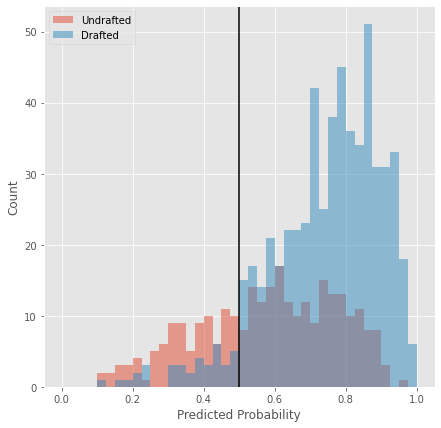

In [136]:
y_test_pred_prob = logreg.predict_proba(X_test)

fig, ax = plt.subplots(figsize=(7,7))

keep = y_test==0

ax.hist(np.sort(y_test_pred_prob[keep][:,1]),bins=np.arange(41)/40,alpha=0.5,label='Undrafted',density=False)

keep = y_test==1

ax.hist(np.sort(y_test_pred_prob[keep][:,1]),bins=np.arange(41)/40,alpha=0.5,label='Drafted',density=False)

ax.axvline(0.5, color='black')

ax.set_xlabel('Predicted Probability')
ax.set_ylabel('Count')

ax.legend()

The black vertical line indicates where the model sees the cutoff between drafted and undrafted players.<br>

The precision could be improved by moving the cutoff to the right.

In [137]:
df_combine.loc[y_test[y_test_pred_prob[:,1] >= 0.85].index]

Year              Player   Age     School  Height      Weight  \
1190  2014       Greg Robinson  21.0     Auburn  1.9558  150.592667   
438   2011         Jimmy Smith  22.0   Colorado  1.8796   95.707990   
1261  2014        Ryan Shazier  21.0   Ohio St.  1.8542  107.501392   
688   2012        George Iloka  21.0  Boise St.  1.9304  102.058283   
854   2012         Adam Gettis  23.0       Iowa  1.8796  132.902564   
...    ...                 ...   ...        ...     ...         ...   
909   2013    Barkevious Mingo  22.0        LSU  1.9304  109.315761   
3447  2019        Emanuel Hall  21.0   Missouri  1.8796   91.172066   
2835  2014  Antonio Richardson  22.0  Tennessee  1.9812  152.407036   
1331  2015      Cedric Ogbuehi  22.0  Texas A&M  1.9558  138.799265   
799   2012      Brandon Mosley  23.0     Auburn  1.9812  142.428004   

      Sprint_40yd  Vertical_Jump  Bench_Press_Reps  Broad_Jump  ...  Position  \
1190         4.92          72.39              32.0      287.02  ...        OT   
438          4.42          91.44              24.0      312.42  ...        CB   
1261         4.58         106.68              25.0      330.20  ...       OLB   
688          4.60          87.63              20.0      314.96  ...        FS   
854          4.90          80.01               NaN      284.48  ...        OG   
...           ...            ...               ...         ...  ...       ...   
909          4.58          93.98               NaN      325.12  ...       OLB   
3447         4.39         110.49              15.0      358.14  ...        WR   
2835         5.30          62.23              36.0         NaN  ...        OT   
1331         4.98            NaN              23.0         NaN  ...        OT   
799          5.14          68.58              30.0      261.62  ...        OT   

      Drafted  player_code pro_bowls pro_bowlYN                  Team  Round  \
1190        1     RobiGr01         0          0       St. Louis Rams     1.0   
438         1     SmitJi03         0          0     Baltimore Ravens     1.0   
1261        1     ShazRy00         2          1  Pittsburgh Steelers     1.0   
688         1     IlokGe00         0          0   Cincinnati Bengals     5.0   
854         1     GettAd00         0          0  Washington Redskins     5.0   
...       ...          ...       ...        ...                   ...    ...   
909         1     MingBa00         0          0     Cleveland Browns     1.0   
3447        0     HallEm00         0          0                   NaN    NaN   
2835        0     RichAn02         0          0                   NaN    NaN   
1331        1     OgbuCe00         0          0   Cincinnati Bengals     1.0   
799         1     MoslBr00         0          0      New York Giants     4.0   

       Pick  Missing_Athletic_Tests  school_group  
1190    2.0                       0             1  
438    27.0                       0             3  
1261   15.0                       0             1  
688   167.0                       0             2  
854   141.0                       1             1  
...     ...                     ...           ...  
909     6.0                       1             1  
3447    NaN                       2             2  
2835    NaN                       3             2  
1331   21.0                       4             1  
799   131.0                       0             1  

[190 rows x 25 columns]

In [138]:
df_combine.loc[y_test[y_test_pred_prob[:,1] >= 0.85].index]['Position'].value_counts(normalize=False)

CB     31
OLB    30
DT     28
DE     20
OT     18
WR     15
RB     10
OG      9
TE      8
SS      6
FS      5
ILB     5
QB      3
C       2
Name: Position, dtype: int64

In [139]:
# All the drafted players by position
df_combine.loc[df_combine['Drafted']==1,'Position'].value_counts(normalize=False)

WR     305
CB     291
OLB    214
DT     206
RB     197
OT     197
DE     194
TE     137
OG     130
QB     118
ILB    114
FS      89
SS      82
C       59
FB      25
Name: Position, dtype: int64

In [140]:
# High probability breakdown of school group
df_combine.loc[y_test[y_test_pred_prob[:,1] > 0.85].index]['school_group'].value_counts(normalize=True)

1    0.521053
2    0.289474
3    0.189474
Name: school_group, dtype: float64

In [141]:
# Total breakdown of school group
df_combine['school_group'].value_counts(normalize=True)

1    0.388583
2    0.306868
3    0.304549
Name: school_group, dtype: float64

In [142]:
df_combine.loc[y_test[y_test_pred_prob[:,1] >= 0.85].index].groupby(['Position']).mean()

Year        Age    Height      Weight  Sprint_40yd  \
Position                                                              
C         2013.500000  22.000000  1.930400  139.479654     5.075000   
CB        2014.258065  21.129032  1.827161   90.220986     4.408710   
DE        2014.550000  21.200000  1.931670  123.173008     4.730500   
DT        2013.785714  21.750000  1.891733  140.597435     5.010000   
FS        2013.600000  20.800000  1.884680   98.248107     4.445000   
ILB       2017.200000  21.800000  1.874520  109.860072     4.636000   
OG        2013.777778  21.888889  1.915583  140.462437     5.067778   
OLB       2014.666667  21.551724  1.883730  110.616075     4.607857   
OT        2013.833333  21.611111  1.974144  143.536786     5.084706   
QB        2014.333333  21.666667  1.921933  104.931035     4.680000   
RB        2013.400000  21.600000  1.785620   99.155292     4.463000   
SS        2012.000000  22.166667  1.837267   96.766372     4.430000   
TE        2013.875000  21.000000  1.924050  113.568190     4.557500   
WR        2014.533333  21.066667  1.849120   92.321167     4.389333   

          Vertical_Jump  Bench_Press_Reps  Broad_Jump  Agility_3cone  \
Position                                                               
C             79.375000         28.500000  264.160000       7.625000   
CB            94.403333         16.576923  318.407143       6.829600   
DE            87.630000         25.866667  300.317647       7.250625   
DT            76.133158         30.842105  267.903158       7.617059   
FS            96.202500         18.500000  325.120000       7.010000   
ILB           87.630000         24.800000  306.832000       6.887500   
OG            71.543333         32.000000  269.804444       7.632222   
OLB           89.535000         21.909091  309.196154       6.980526   
OT            72.315294         28.000000  271.145000       7.629333   
QB            87.206667               NaN  303.106667       6.876667   
RB            92.202000         21.700000  309.315556       6.928889   
SS            91.863333         22.500000  313.266667       6.956000   
TE            95.431429         22.250000  314.234286       7.042500   
WR            96.520000         15.818182  321.016923       6.742857   

           Shuttle        BMI   Drafted  pro_bowls  pro_bowlYN     Round  \
Position                                                                   
C         4.590000  37.429691  0.500000   1.500000    0.500000  1.000000   
CB        4.106250  27.040043  0.935484   1.000000    0.258065  2.068966   
DE        4.369375  33.028099  0.950000   0.500000    0.200000  2.736842   
DT        4.605000  39.334319  0.821429   0.321429    0.142857  3.347826   
FS        4.125000  27.649774  1.000000   0.200000    0.200000  2.200000   
ILB       4.187500  31.267340  1.000000   0.000000    0.000000  4.800000   
OG        4.625556  38.312952  1.000000   0.666667    0.333333  2.777778   
OLB       4.263889  31.181126  0.900000   0.800000    0.200000  2.888889   
OT        4.655000  36.836449  0.888889   0.222222    0.111111  2.312500   
QB        4.196667  28.411443  1.000000   0.000000    0.000000  2.333333   
RB        4.220000  31.097234  0.800000   0.700000    0.300000  1.875000   
SS        4.192000  28.681684  0.666667   0.000000    0.000000  4.250000   
TE        4.366000  30.678608  0.875000   0.875000    0.250000  3.285714   
WR        4.157143  26.992284  0.933333   0.733333    0.333333  2.428571   

                Pick  Missing_Athletic_Tests  school_group  
Position                                                    
C          18.000000                0.000000      1.000000  
CB         49.862069                0.806452      1.645161  
DE         74.736842                0.950000      1.650000  
DT         99.391304                1.714286      1.571429  
FS         61.200000                2.000000      1.200000  
ILB       140.000000                0.400000      2.000000  
OG         73.888889  

In [143]:
df_combine.loc[y_test[y_test_pred_prob[:,1] < 0.85].index].groupby(['Position']).mean()

Year        Age    Height      Weight  Sprint_40yd  \
Position                                                              
C         2013.294118  22.294118  1.916953  138.585810     5.304375   
CB        2014.012987  22.090909  1.811977   87.702379     4.515135   
DE        2013.422222  22.466667  1.929906  121.280520     4.885814   
DT        2014.523810  22.238095  1.903715  138.788465     5.167436   
FB        2012.300000  22.400000  1.851660  107.864266     4.757000   
FS        2015.000000  21.583333  1.820985   91.992022     4.548696   
ILB       2013.171429  22.235294  1.862727  109.212083     4.788000   
OG        2013.645833  22.354167  1.935758  143.174542     5.333830   
OLB       2013.125000  22.375000  1.880236  110.268299     4.746750   
OT        2014.714286  22.311111  1.974461  142.603887     5.327209   
QB        2014.515152  22.757576  1.901152  100.546309     4.876333   
RB        2014.426667  21.837838  1.791885   96.681702     4.577042   
SS        2013.758621  22.172414  1.826172   94.957216     4.571111   
TE        2014.827586  22.103448  1.933903  114.868357     4.813478   
WR        2014.508475  22.033898  1.848603   91.460367     4.530000   

          Vertical_Jump  Bench_Press_Reps  Broad_Jump  Agility_3cone  \
Position                                                               
C             66.463333         24.307692  252.632308       7.817692   
CB            89.412097         13.982759  307.714754       6.954717   
DE            79.864857         22.970588  283.492222       7.223333   
DT            71.273939         25.600000  259.602941       7.768929   
FB            85.936667         22.714286  293.370000       7.198000   
FS            90.932000         16.181818  308.102000       6.978000   
ILB           84.636429         21.222222  290.500741       7.166471   
OG            66.992500         24.184211  254.467895       7.866286   
OLB           84.762258         21.516129  294.243125       7.230385   
OT            69.487143         24.205128  255.763889       7.956897   
QB            76.341111               NaN  275.785385       7.160833   
RB            87.514545         17.285714  300.486032       7.028947   
SS            87.687727         17.800000  300.990000       7.092857   
TE            81.824286         18.708333  289.827368       7.222353   
WR            88.098544         13.804348  304.302474       6.940380   

           Shuttle        BMI   Drafted  pro_bowls  pro_bowlYN     Round  \
Position                                                                   
C         4.730769  37.735732  0.588235   0.705882    0.117647  3.600000   
CB        4.200545  26.726570  0.753247   0.116883    0.038961  4.155172   
DE        4.454516  32.568590  0.644444   0.177778    0.088889  3.758621   
DT        4.708276  38.331740  0.642857   0.047619    0.023810  4.666667   
FB        4.366000  31.460117  0.500000   0.000000    0.000000  6.800000   
FS        4.208824  27.755824  0.576923   0.076923    0.076923  3.866667   
ILB       4.316500  31.490760  0.628571   0.171429    0.057143  4.045455   
OG        4.845263  38.222855  0.604167   0.166667    0.020833  4.586207   
OLB       4.400000  31.201706  0.750000   0.100000    0.050000  4.333333   
OT        4.846250  36.602271  0.612245   0.000000    0.000000  4.100000   
QB        4.368400  27.826005  0.575758   0.060606    0.030303  4.421053   
RB        4.285250  30.101607  0.546667   0.133333    0.080000  4.121951   
SS        4.325333  28.477093  0.586207   0.103448    0.068966  4.705882   
TE        4.430588  30.720628  0.724138   0.034483    0.034483  4.904762   
WR        4.248272  26.745807  0.466102   0.152542    0.033898  4.345455   

                Pick  Missing_Athletic_Tests  school_group  
Position                                                    
C         110.400000                1.294118      1.823529  
CB        124.879310                1.285714      2.090909  
DE        112.517241                1.355556   

In [144]:
df_combine.loc[y_test[y_test_pred_prob[:,1] >= 0.85].index].describe()

Year         Age      Height      Weight  Sprint_40yd  \
count   190.000000  189.000000  190.000000  190.000000   186.000000   
mean   2014.163158   21.449735    1.884012  115.069225     4.684355   
std       3.111629    0.889575    0.059998   20.608360     0.274982   
min    2009.000000   20.000000    1.727200   83.460996     4.220000   
25%    2012.000000   21.000000    1.842294   96.728573     4.450000   
50%    2014.000000   21.000000    1.879600  112.490908     4.620000   
75%    2017.000000   22.000000    1.930400  136.871498     4.927500   
max    2019.000000   23.000000    2.006600  157.850145     5.310000   

       Vertical_Jump  Bench_Press_Reps  Broad_Jump  Agility_3cone     Shuttle  \
count     166.000000        150.000000  164.000000     137.000000  138.000000   
mean       86.880241         23.266667  300.153659       7.167591    4.353986   
std        10.950935          7.118052   24.371936       0.383455    0.250706   
min        60.960000          7.000000  243.840000       6.550000    3.940000   
25%        78.740000         18.250000  286.385000       6.890000    4.140000   
50%        86.360000         23.000000  307.340000       7.070000    4.310000   
75%        95.250000         27.000000  317.500000       7.480000    4.520000   
max       110.490000         49.000000  358.140000       8.160000    5.110000   

              BMI     Drafted   pro_bowls  pro_bowlYN       Round        Pick  \
count  190.000000  190.000000  190.000000  190.000000  170.000000  170.000000   
mean    32.271187    0.894737    0.594737    0.205263    2.711765   75.194118   
std      4.720800    0.307703    1.479659    0.404961    1.863503   67.871380   
min     24.275624    0.000000    0.000000    0.000000    1.000000    1.000000   
25%     28.106951    1.000000    0.000000    0.000000    1.000000   21.000000   
50%     31.418530    1.000000    0.000000    0.000000    2.000000   51.500000   
75%     36.285961    1.000000    0.000000    0.000000    4.000000  116.000000   
max     44.680097    1.000000    8.000000    1.000000    7.000000  253.000000   

       Missing_Athletic_Tests  school_group  
count              190.000000    190.000000  
mean                 1.047368      1.668421  
std                  1.523317      0.777020  
min                  0.000000      1.000000  
25%                  0.000000      1.000000  
50%                  0.000000      1.000000  
75%                  2.000000      2.000000  
max                  6.000000      3.000000

In [145]:
df_combine.loc[y_test[y_test_pred_prob[:,1] < 0.85].index].describe()

Year         Age      Height      Weight  Sprint_40yd  \
count   673.000000  665.000000  673.000000  673.000000   620.000000   
mean   2014.109955   22.174436    1.870953  109.072452     4.794484   
std       3.054043    0.973880    0.069107   20.772476     0.322483   
min    2009.000000   20.000000    1.651000   74.842741     4.310000   
25%    2011.000000   22.000000    1.828800   92.079251     4.540000   
50%    2014.000000   22.000000    1.879600  102.965468     4.695000   
75%    2017.000000   23.000000    1.930400  125.191494     5.000000   
max    2019.000000   28.000000    2.032000  163.746846     5.840000   

       Vertical_Jump  Bench_Press_Reps  Broad_Jump  Agility_3cone     Shuttle  \
count     541.000000        496.000000  530.000000     423.000000  444.000000   
mean       82.237782         19.082661  288.476906       7.258487    4.426577   
std        10.687288          5.956002   23.463592       0.422149    0.269508   
min        44.450000          4.000000  213.360000       6.500000    3.900000   
25%        74.930000         15.000000  274.320000       6.950000    4.230000   
50%        83.820000         19.000000  294.640000       7.160000    4.380000   
75%        90.170000         23.000000  304.800000       7.490000    4.590000   
max       110.490000         35.000000  345.440000       8.550000    5.380000   

              BMI     Drafted   pro_bowls  pro_bowlYN       Round        Pick  \
count  673.000000  673.000000  673.000000  673.000000  408.000000  408.000000   
mean    30.963293    0.606241    0.126300    0.046062    4.299020  131.448529   
std      4.398367    0.488946    0.742286    0.209776    1.862285   68.455529   
min     23.352095    0.000000    0.000000    0.000000    1.000000    4.000000   
25%     27.475692    0.000000    0.000000    0.000000    3.000000   75.750000   
50%     29.846636    1.000000    0.000000    0.000000    4.000000  130.500000   
75%     33.612333    1.000000    0.000000    0.000000    6.000000  185.250000   
max     44.461334    1.000000    9.000000    1.000000    7.000000  254.000000   

       Missing_Athletic_Tests  school_group  
count              673.000000    673.000000  
mean                 1.462110      1.974740  
std                  1.841682      0.836812  
min                  0.000000      1.000000  
25%                  0.000000      1.000000  
50%                  1.000000      2.000000  
75%                  2.000000      3.000000  
max                  6.000000      3.000000

**Model 3: Interaction Terms**
The two previous models handled position by creating one-hot-encoded columns, one for each position. These are useful if certain positions are drafted more often than others. However, this does not allow the model to determine which columns matter more for which position. For example, this does not allow the model to emphasize the 40-yard sprint for running backs while emphasizing the number of bench press reps for offensive guards.

I address this in this model by creating interaction terms between position and numerical values. Now instead of having one column per drill and one column for each position, there will be columns like "Sprint_40ydxPosition_RB" and "Bench_Press_RepsxPosition_OG". The upside is that the model can now determine what matters to each position separately. The downside is that it creates lots of columns, so there is a higher risk of overfitting.

The function below creates the interaction terms.

In [146]:
def create_interaction_terms(X, list1):
    """
    This function creates interaction terms between position and other values.
    
    Input:
    X: The DataFrame that has the independent variables
    
    list1: A list of attributes to incorporate into interaction terms.
    """
    list2 = list(df_combine['Position'].unique())
    
    len1 = len(list1)
    len2 = len(list2)
    
    n = 0
    while n < len1*len2:
        i = n // len2
        j = n % len2
        X[f"{list1[i]}xPosition_{list2[j]}"] = X[list1[i]]*X['Position'].\
        apply(lambda x: 1 if x==list2[j] else 0)
        
        n += 1
        
    # Drop individual columns used to make the interaction terms
    X.drop(columns=list1,inplace=True)

    return X

In [147]:
# Define X and y
X = df_combine[['Age','Height','Weight','Sprint_40yd','Vertical_Jump','Bench_Press_Reps','Broad_Jump','Agility_3cone',
             'Shuttle','BMI','Position','school_group']]
y = df_combine['Drafted']

# Split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=rand_seed, test_size=0.25)

# Apply imputer and scaler
X_train = ImputeAndScaleByPosition(X_train)
X_test = ImputeAndScaleByPosition(X_test)

# Create interaction terms
list1 = ['Height','Weight','Sprint_40yd','Vertical_Jump','Bench_Press_Reps','Broad_Jump','Agility_3cone','Shuttle','BMI']

X_train = create_interaction_terms(X_train, list1)
X_test = create_interaction_terms(X_test, list1)

# Apply get_dummies to separate categorical data into columns
X_train = pd.get_dummies(X_train, columns=['Position','school_group'])
X_test = pd.get_dummies(X_test, columns=['Position','school_group'])

Training:
              precision    recall  f1-score   support

           0       0.66      0.46      0.54       808
           1       0.78      0.89      0.84      1780

    accuracy                           0.76      2588
   macro avg       0.72      0.68      0.69      2588
weighted avg       0.75      0.76      0.74      2588

Test:
              precision    recall  f1-score   support

           0       0.54      0.35      0.43       285
           1       0.73      0.85      0.79       578

    accuracy                           0.69       863
   macro avg       0.64      0.60      0.61       863
weighted avg       0.67      0.69      0.67       863



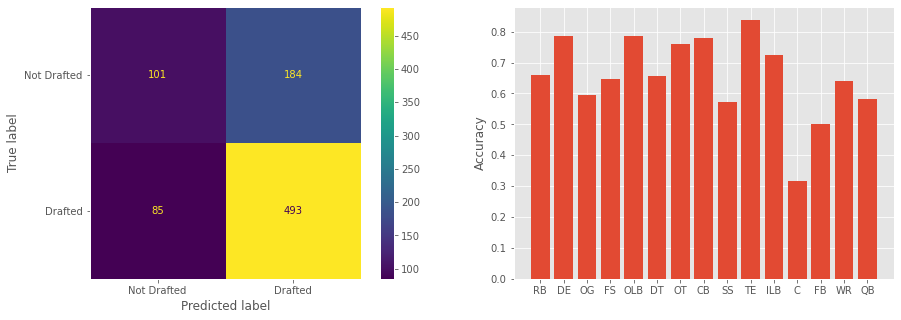

In [148]:
# Instantiate LogisticRegressionModel
logreg = LogisticRegression(C=1e12, random_state=42, solver='lbfgs', max_iter=5000, fit_intercept=False)

# Fit model
logreg.fit(X_train, y_train)

# Get predictions
y_train_pred = logreg.predict(X_train)
y_test_pred = logreg.predict(X_test)

display_model_results(y_train, y_train_pred, y_test, y_test_pred, df_combine)

I knew that creating lots of interaction terms might lead to overfitting and it feels like that is what happened. The accuracy on the test data was 7 percentage points lower than the training accuracy (69% vs 76%). Also, the overall accuracy of this model is lower than the previous, simpler models.

AUC: 0.6683724883142111


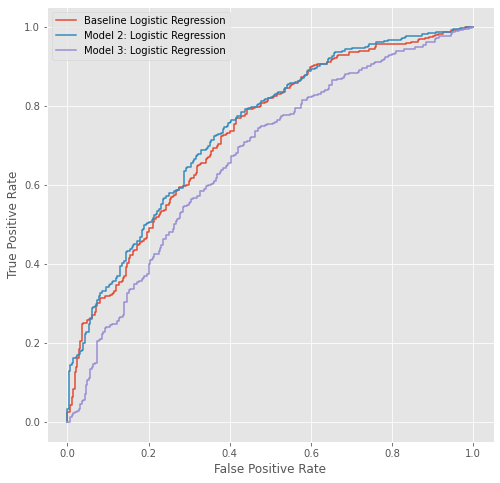

In [149]:
# Update ROC Curve
y_test_pred_prob = logreg.predict_proba(X_test)

fpr, tpr, thresh = roc_curve(y_test, y_test_pred_prob[:,1])
print('AUC:',auc(fpr, tpr))

ax_roc.plot(fpr, tpr, label='Model 3: Logistic Regression')
ax_roc.legend()

fig_roc

**Model 4: Regularization**
One way to reduce overfitting is by using regularization. I have been using the lbfgs solver which uses Lasso regularization, but I have been using a very high C value so that there is essentially no regularization. Below, I will loop through some different values of C to see which works best.

This model still uses the interaction terms from model 3. If regularization does not improve the fit, then I will revert back to the model that does not use interaction terms (model 2).

In [150]:
# Define X and y
X = df_combine[['Age','Height','Weight','Sprint_40yd','Vertical_Jump','Bench_Press_Reps','Broad_Jump','Agility_3cone',
             'Shuttle','BMI','Position','school_group']]
y = df_combine['Drafted']

# Split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=rand_seed, test_size=0.25)

# Apply imputer and scaler
X_train = ImputeAndScaleByPosition(X_train)
X_test = ImputeAndScaleByPosition(X_test)

# Create interaction terms
list1 = ['Height','Weight','Sprint_40yd','Vertical_Jump','Bench_Press_Reps','Broad_Jump','Agility_3cone','Shuttle','BMI']

X_train = create_interaction_terms(X_train, list1)
X_test = create_interaction_terms(X_test, list1)

# Apply get_dummies to separate categorical data into columns
X_train = pd.get_dummies(X_train, columns=['Position','school_group'])
X_test = pd.get_dummies(X_test, columns=['Position','school_group'])

1 0.7195828505214369
10 0.7195828505214369
100 0.7056778679026651
1000 0.6952491309385863
10000 0.6894553881807648
1000000.0 0.6882966396292005
10000000.0 0.6882966396292005
100000000.0 0.6882966396292005
1000000000.0 0.6882966396292005
10000000000.0 0.6882966396292005
Training:
              precision    recall  f1-score   support

           0       0.67      0.43      0.52       808
           1       0.78      0.90      0.83      1780

    accuracy                           0.75      2588
   macro avg       0.72      0.67      0.68      2588
weighted avg       0.74      0.75      0.74      2588

Test:
              precision    recall  f1-score   support

           0       0.63      0.36      0.46       285
           1       0.74      0.89      0.81       578

    accuracy                           0.72       863
   macro avg       0.69      0.63      0.64       863
weighted avg       0.70      0.72      0.70       863



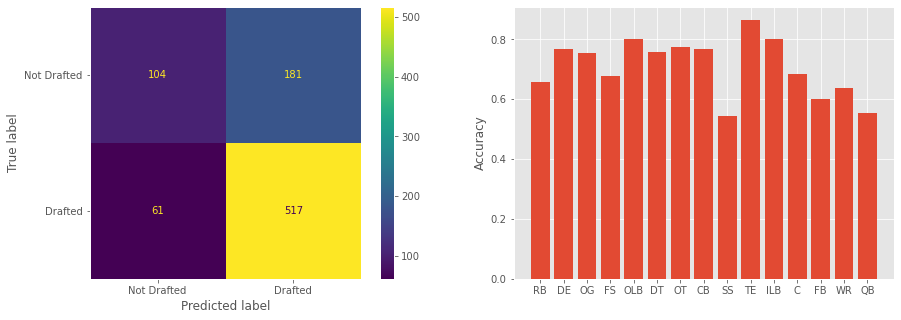

In [151]:
C_vals = [1, 10, 100, 1000, 10000, 1e6, 1e7, 1e8, 1e9, 1e10]

best_C = 0
best_acc = 0.0

for C in C_vals:
    # Instantiate LogisticRegressionModel
    logreg = LogisticRegression(C=C, random_state=42, solver='lbfgs', max_iter=5000, fit_intercept=False)

    # Fit model
    logreg.fit(X_train, y_train)

    # Get predictions
    y_train_pred = logreg.predict(X_train)
    y_test_pred = logreg.predict(X_test)
    
    acc = accuracy_score(y_test, y_test_pred)
    
    print(C, acc)
    
    if acc > best_acc:
        best_C = C
        best_acc = acc
        logreg_best = logreg

# Get predictions from best model
y_train_pred = logreg_best.predict(X_train)
y_test_pred = logreg_best.predict(X_test)

display_model_results(y_train, y_train_pred, y_test, y_test_pred, df_combine)

Based on the accuracy of the training data, the best C value was 1 (the most stringent regularization tested). The overfitting was reduced and the accuracy of the training data did improve. The overall accuracy was slightly lower than the best model without interaction terms.

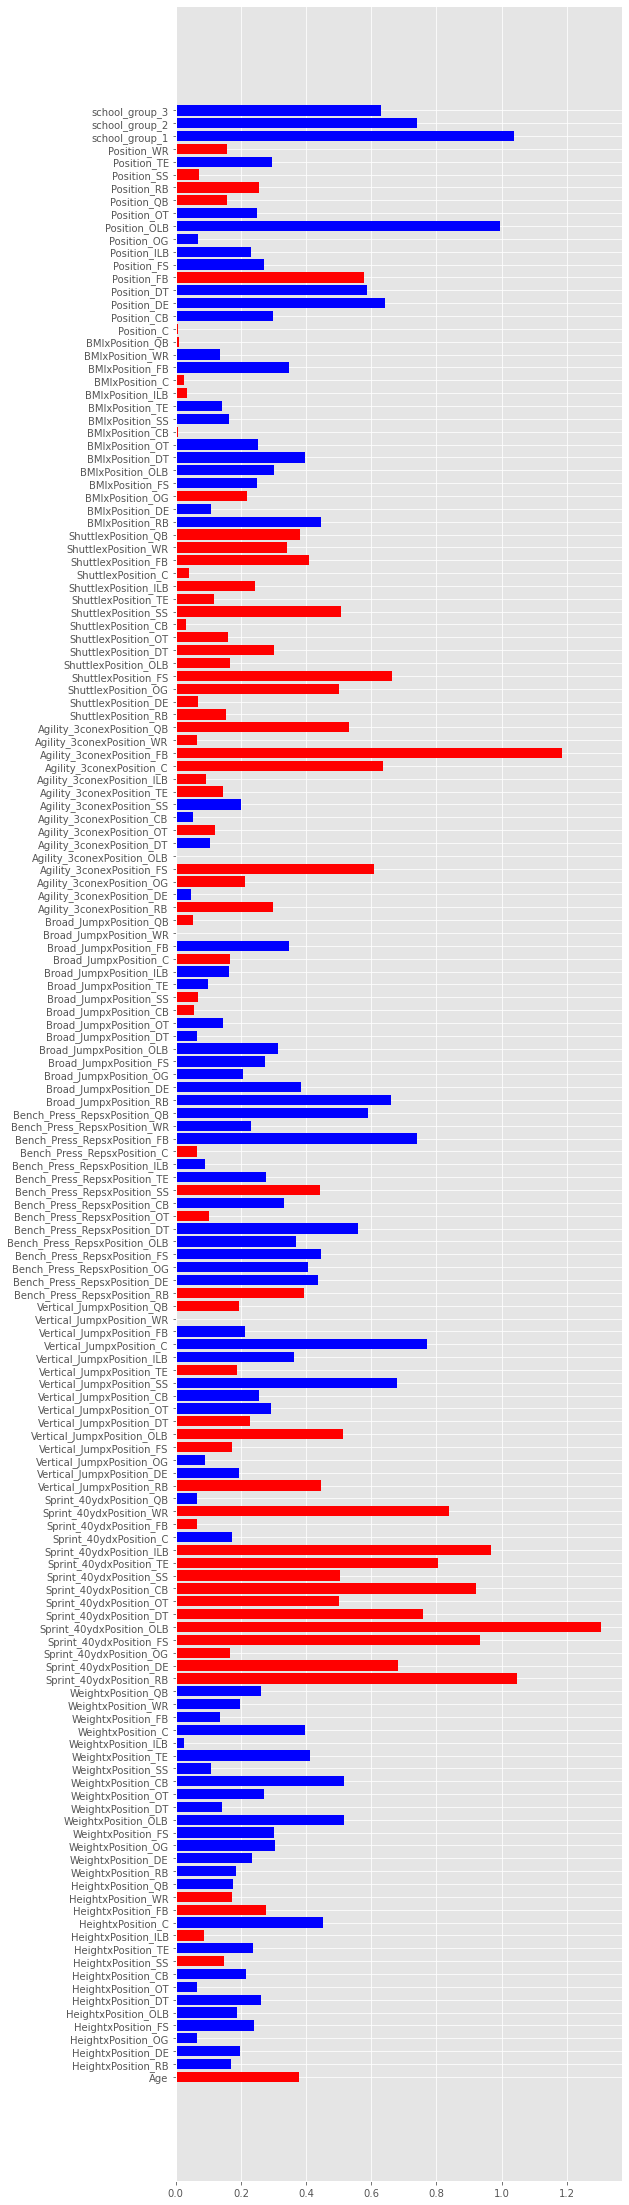

In [152]:
# Plot coefficient values for last model
coefs = logreg_best.coef_[0]
cols = X_train.columns

fig, ax = plt.subplots(figsize=(8,40))

ax.barh(np.arange(len(cols)), np.abs(coefs), color=['blue' if x>0 else 'red' for x in coefs])
ax.set_yticks(np.arange(len(cols)))
ax.set_yticklabels(cols);

The last model has a lot of parameters, but the number of parameters that applies to a given player is much lower. For example, a QB will only use Age, the school_group parameters, and any parameter that ends with Position_QB.<br>

There is some evidence for overfitting since certain values are expected to be positive (whenever bigger values are preferred) and others are expected to be negative (whenever smaller values are preferred), but the coefficients don't always reflect this. One example is the 40-yard sprint where lower times should be preferred, so we expect these to be red in the plot above. However, the values are actually blue for QB and C. What this means to me is not that teams actually value having slower quarterbacks and centers, but that random noise or possible correlations with other features might lead to these values in the fit. Maybe the model thinks that slower centers are more likely to get drafted because larger, stronger centers are preferred and they just happen to be slower on average. This does harm the model slightly because the model would predict that a slower quarterback or center would be drafted over a faster one if everything else is equal, but that would not be true in reality.

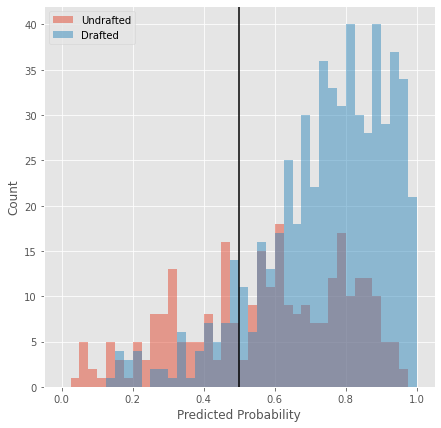

In [153]:
# Plot histograms of predicted probability
y_test_pred_prob = logreg_best.predict_proba(X_test)

fig, ax = plt.subplots(figsize=(7,7))

keep = y_test==0

ax.hist(np.sort(y_test_pred_prob[keep][:,1]),bins=np.arange(41)/40,alpha=0.5,label='Undrafted',density=False)

keep = y_test==1

ax.hist(np.sort(y_test_pred_prob[keep][:,1]),bins=np.arange(41)/40,alpha=0.5,label='Drafted',density=False)

ax.axvline(0.5, color='black')

ax.set_xlabel('Predicted Probability')
ax.set_ylabel('Count')

ax.legend()

AUC: 0.6690038244399927


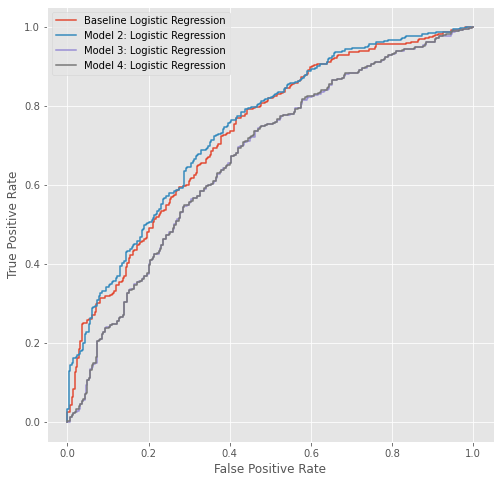

In [154]:
# Update ROC Curve
y_test_pred_prob = logreg.predict_proba(X_test)

fpr, tpr, thresh = roc_curve(y_test, y_test_pred_prob[:,1])
print('AUC:',auc(fpr, tpr))

ax_roc.plot(fpr, tpr, label='Model 4: Logistic Regression')
ax_roc.legend()

fig_roc

The ROC curve also indicates that this was the worst performing model so far.

**Model 5: Only keep useful interaction terms**
The previous two models that used interaction terms both had a problem with overfitting. This is not surprising since there were lots of columns fed to the model and we already know that some of those attribute-position combinations don't achieve very high accuracy on their own.<br>

To help fix this, I will try another fit, but I will only keep interaction terms that achieved a certain accuracy. This way, I will get rid of some of the weaker terms.

In [155]:
# Define X and y
X = df_combine[['Age','Height','Weight','Sprint_40yd','Vertical_Jump','Bench_Press_Reps','Broad_Jump','Agility_3cone',
             'Shuttle','BMI','Position','school_group']]
y = df_combine['Drafted']

# Split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=rand_seed, test_size=0.25)

# Apply imputer and scaler
X_train = ImputeAndScaleByPosition(X_train)
X_test = ImputeAndScaleByPosition(X_test)

# Create interaction terms
list1 = ['Height','Weight','Sprint_40yd','Vertical_Jump','Bench_Press_Reps','Broad_Jump','Agility_3cone','Shuttle','BMI']

X_train = create_interaction_terms(X_train, list1)
X_test = create_interaction_terms(X_test, list1)

# Apply get_dummies to separate categorical data into columns
X_train = pd.get_dummies(X_train, columns=['Position','school_group'])
X_test = pd.get_dummies(X_test, columns=['Position','school_group'])

# Drop any interaction terms that did not achieve high enough accuracy
cut = 0.65

list2 = list(df_combine['Position'].unique())
    
len1 = len(list1)
len2 = len(list2)
    
n = 0
while n < len1*len2:
    i = n // len2
    j = n % len2
    if accuracy[i,j] < cut:
        X_train.drop(columns=f"{list1[i]}xPosition_{list2[j]}", inplace=True)
        X_test.drop(columns=f"{list1[i]}xPosition_{list2[j]}", inplace=True)
        
    n += 1

1 0.7068366164542295
10 0.7045191193511008
100 0.694090382387022
1000 0.6859791425260718
10000 0.6836616454229433
1000000.0 0.6825028968713789
10000000.0 0.6825028968713789
100000000.0 0.6825028968713789
1000000000.0 0.6836616454229433
10000000000.0 0.6825028968713789
Training:
              precision    recall  f1-score   support

           0       0.63      0.35      0.45       808
           1       0.75      0.91      0.82      1780

    accuracy                           0.73      2588
   macro avg       0.69      0.63      0.64      2588
weighted avg       0.72      0.73      0.71      2588

Test:
              precision    recall  f1-score   support

           0       0.62      0.29      0.39       285
           1       0.72      0.91      0.81       578

    accuracy                           0.71       863
   macro avg       0.67      0.60      0.60       863
weighted avg       0.69      0.71      0.67       863



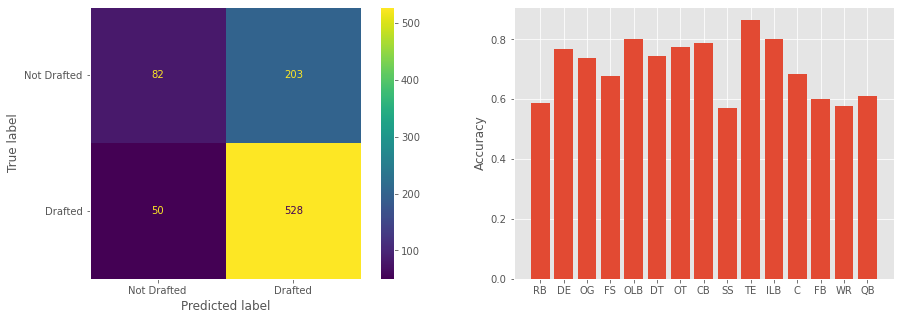

In [156]:
C_vals = [1, 10, 100, 1000, 10000, 1e6, 1e7, 1e8, 1e9, 1e10]

best_C = 0
best_acc = 0.0

for C in C_vals:
    # Instantiate LogisticRegressionModel
    logreg = LogisticRegression(C=C, random_state=42, solver='lbfgs', max_iter=5000, fit_intercept=False)

    # Fit model
    logreg.fit(X_train, y_train)

    # Get predictions
    y_train_pred = logreg.predict(X_train)
    y_test_pred = logreg.predict(X_test)
    
    acc = accuracy_score(y_test, y_test_pred)
    
    print(C, acc)
    
    if acc > best_acc:
        best_C = C
        best_acc = acc
        logreg_best = logreg

# Get predictions from best model
y_train_pred = logreg_best.predict(X_train)
y_test_pred = logreg_best.predict(X_test)
        
display_model_results(y_train, y_train_pred, y_test, y_test_pred, df_combine)

This effect of cutting some of the interaction terms is that the overall accuracy decreased a small amount.

AUC: 0.6762975778546713


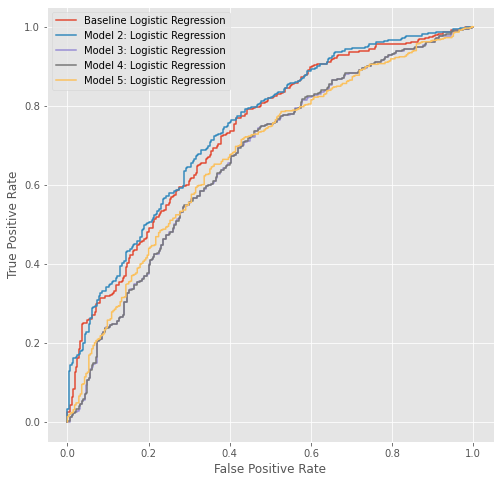

In [157]:
# Update ROC Curve
y_test_pred_prob = logreg.predict_proba(X_test)

fpr, tpr, thresh = roc_curve(y_test, y_test_pred_prob[:,1])
print('AUC:',auc(fpr, tpr))

ax_roc.plot(fpr, tpr, label='Model 5: Logistic Regression')
ax_roc.legend()

fig_roc

The AUC is actually slightly better than the previous model, but this model still performed worse than the models without interaction terms.

**Model 6: Regularization and NO interaction terms**

The best performing model so far was model 2 which did not have interaction terms and did not employ strong regularization.
This model will use GridSearchCV to test different values of C and class_weight. It will not employ the interaction terms.

Grid Search found the following optimal parameters: 
logreg__C: 100
logreg__class_weight: None
Training:
              precision    recall  f1-score   support

           0       0.63      0.36      0.46       808
           1       0.76      0.90      0.82      1780

    accuracy                           0.73      2588
   macro avg       0.69      0.63      0.64      2588
weighted avg       0.72      0.73      0.71      2588

Test:
              precision    recall  f1-score   support

           0       0.72      0.33      0.46       285
           1       0.74      0.94      0.83       578

    accuracy                           0.74       863
   macro avg       0.73      0.63      0.64       863
weighted avg       0.73      0.74      0.70       863



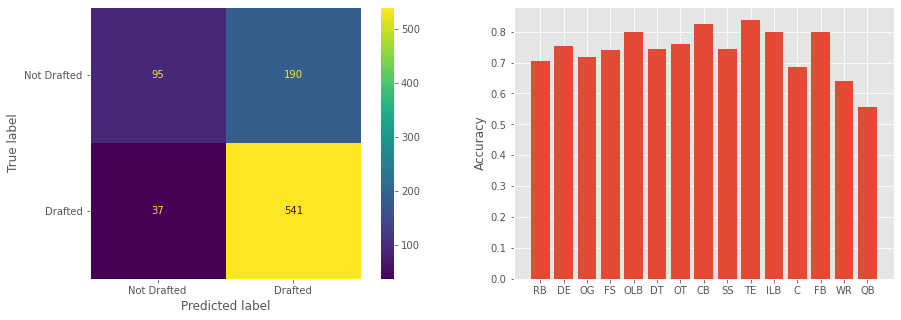

In [158]:
# Logistic regression pipeline with GridSearchCV
logreg = LogisticRegression(random_state=42, solver='lbfgs',max_iter=5000, fit_intercept=False)

param_grid_logreg = {
    'logreg__C': [1,10,100,1000,1e4,1e5,1e6,1e7,1e8,1e9,1e10],
    'logreg__class_weight': [None,{0:3, 1:2},{0:2, 1:1}]
}

pipe = Pipeline(steps=[
    ('impute_scale',FunctionTransformer(ImputeAndScaleByPosition)),
    ('dummies',FunctionTransformer(pd.get_dummies,kw_args={'columns':['Position','school_group']})),
    ('logreg',logreg)
])

logreg_gridcv = GridSearchCV(pipe, param_grid=param_grid_logreg, cv=3)

X = df_combine[['Age','Height','Weight','Sprint_40yd','Vertical_Jump','Bench_Press_Reps','Broad_Jump','Agility_3cone',
             'Shuttle','BMI','Position','school_group']]
y = df_combine['Drafted']

# Split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=rand_seed, test_size=0.25)

logreg_gridcv.fit(X_train, y_train)

best_parameters = logreg_gridcv.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

y_train_pred = logreg_gridcv.predict(X_train)
y_test_pred = logreg_gridcv.predict(X_test)

display_model_results(y_train, y_train_pred, y_test, y_test_pred, df_combine)

The best result was achieved using a regularization of 100. However, the results are very similar to the model with no regularization (very high C).

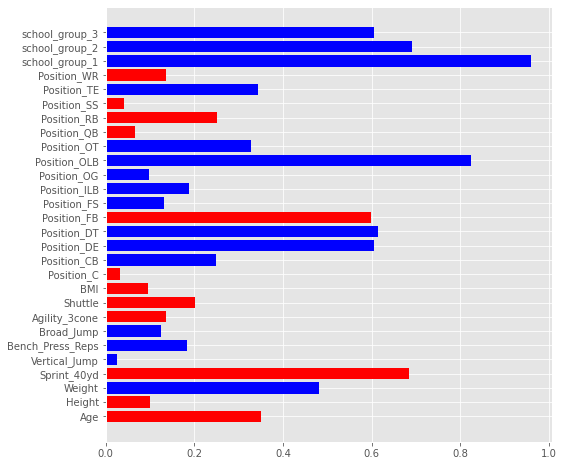

In [159]:
coefs = logreg_gridcv.best_estimator_['logreg'].coef_[0]
cols = pd.get_dummies(X_train, columns=['Position','school_group']).columns

fig, ax = plt.subplots(figsize=(8,8))

ax.barh(np.arange(len(cols)), np.abs(coefs), color=['blue' if x>0 else 'red' for x in coefs])
ax.set_yticks(np.arange(len(cols)))
ax.set_yticklabels(cols);

The coefficient values are very similar to model 2.

**Logistic Regression Result**
The best model was model 6 which used C=100, no interaction terms, and imputed and scaled each position separately. The effect of the regularization was quite small.

AUC: 0.7414375037940872


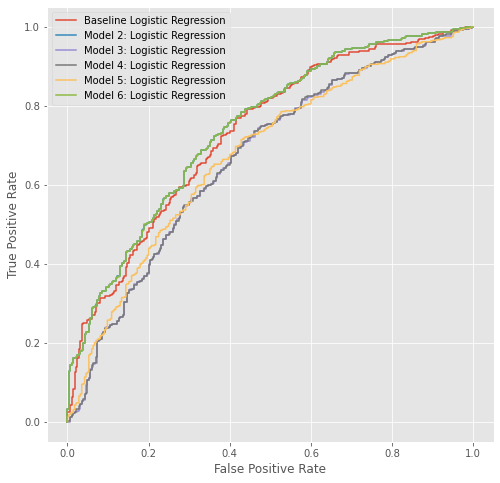

In [160]:
# Update ROC Curve
y_test_pred_prob = logreg_gridcv.predict_proba(X_test)

fpr, tpr, thresh = roc_curve(y_test, y_test_pred_prob[:,1])
print('AUC:',auc(fpr, tpr))

ax_roc.plot(fpr, tpr, label='Model 6: Logistic Regression')
ax_roc.legend()

fig_roc

# Decision Tree Classifier

For the decision tree classifier, it is necessary to replace missing values. It is also important to rescale the data based on position.

One limitation of the decision tree classifier is that it might struggle to treat different positions separately. Hypothetically, it could start by splitting based on position, but since it is a greedy algorithm and each position gets drafted at a similar rate, it probably will not do that.

**Model 1: Default hyperparameters**

First, I will create a decision tree model using the default hyperparameters.

The model will impute and scale positions separately.

In [168]:
# Define X and y
X = df_combine[['Age','Height','Weight','Sprint_40yd','Vertical_Jump','Bench_Press_Reps','Broad_Jump','Agility_3cone',
             'Shuttle','BMI','Position','school_group']]
y = df_combine['Drafted']

# Split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=rand_seed, test_size=0.25)

# Apply imputer and scaler
X_train = ImputeAndScaleByPosition(X_train)
X_test = ImputeAndScaleByPosition(X_test)

# Apply get_dummies to separate categorical data into columns
X_train = pd.get_dummies(X_train, columns=['Position','school_group'])
X_test = pd.get_dummies(X_test, columns=['Position','school_group'])

Training:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       808
           1       1.00      1.00      1.00      1780

    accuracy                           1.00      2588
   macro avg       1.00      1.00      1.00      2588
weighted avg       1.00      1.00      1.00      2588

Test:
              precision    recall  f1-score   support

           0       0.44      0.43      0.43       285
           1       0.72      0.73      0.72       578

    accuracy                           0.63       863
   macro avg       0.58      0.58      0.58       863
weighted avg       0.63      0.63      0.63       863



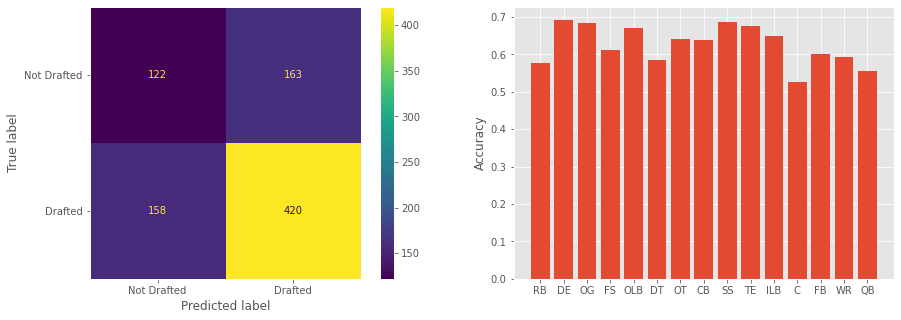

In [169]:
# Instantiate DecisionTreeClassifier
dtc = DecisionTreeClassifier(random_state=42)

# Fit model
dtc.fit(X_train, y_train)

# Get predictions
y_train_pred = dtc.predict(X_train)
y_test_pred = dtc.predict(X_test)

display_model_results(y_train, y_train_pred, y_test, y_test_pred, df_combine)

This model is severely overfitting. This is not surprising because the default parameters don't limit the tree from splitting as many times as it needs to in order to get a "perfect" fit. The model needs some hyperparameters to help keep it from overfitting.

AUC: 0.5773568870272567


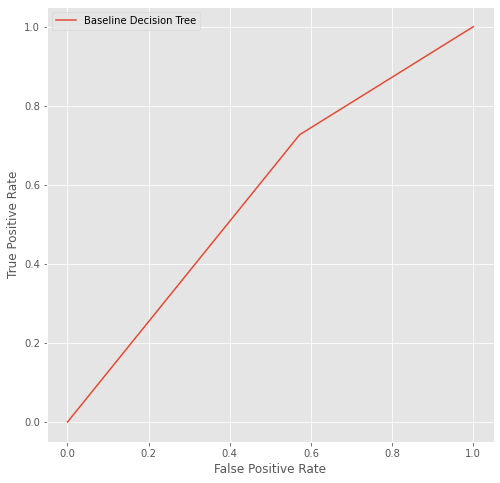

In [170]:
# Plot ROC curve
y_test_pred_prob = dtc.predict_proba(X_test)
fig_roc, ax_roc = plt.subplots(figsize=(8,8))

fpr, tpr, thresh = roc_curve(y_test, y_test_pred_prob[:,1])
print('AUC:',auc(fpr, tpr))

ax_roc.plot(fpr, tpr, label='Baseline Decision Tree')

ax_roc.set_xlabel('False Positive Rate')
ax_roc.set_ylabel('True Positive Rate')
ax_roc.legend()

The ROC curve for the baseline model is not very interesting because of the overfitting. The effect of overfitting the model is that the model will always produce either a 0 or 1 for the probability and never anything in between.

**Model 2: Grid Search Cross Validation**
The second model makes the following changes compared to the first:<br>
1. The model will use some hyperparameters built in to the DecisionTreeClassifier class:<br>
criterion, max_depth, min_samples_leaf, and class_weight.<br>
2. GridSearchCV is used to both test out different values of these parameters, but do 3-way cross validation at the same time.
3. In order to avoid data leakage, I use a pipeline that performs all the preprocessing prior to each cross validation. This does make the process take quite a bit longer because every step of the process is done for every model.

Grid Search found the following optimal parameters: 
dtc__class_weight: None
dtc__criterion: 'gini'
dtc__max_depth: 5
dtc__min_samples_leaf: 3
Training:
              precision    recall  f1-score   support

           0       0.63      0.48      0.55       808
           1       0.79      0.87      0.83      1780

    accuracy                           0.75      2588
   macro avg       0.71      0.68      0.69      2588
weighted avg       0.74      0.75      0.74      2588

Test:
              precision    recall  f1-score   support

           0       0.48      0.35      0.41       285
           1       0.72      0.81      0.76       578

    accuracy                           0.66       863
   macro avg       0.60      0.58      0.58       863
weighted avg       0.64      0.66      0.64       863



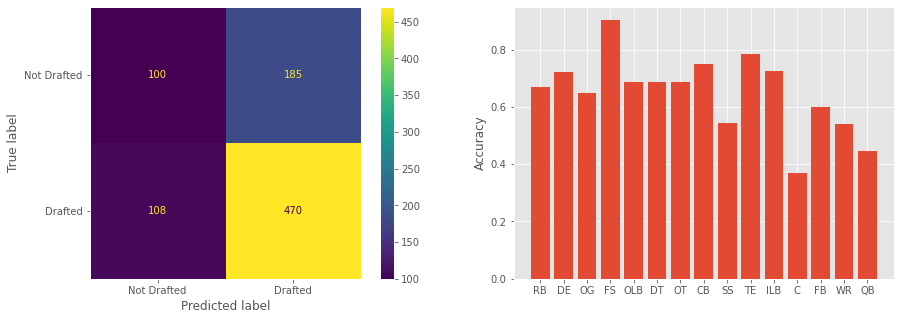

In [178]:
# Decision tree pipeline with GridSearchCV
dtc = DecisionTreeClassifier()

param_grid_dtc = {
    'dtc__criterion': ['gini','entropy'],
    'dtc__max_depth': [3, 4, 5, None],
    'dtc__min_samples_leaf': [1, 2, 3, 4],
    'dtc__class_weight': [None, {0: 2, 1: 1}, {0: 3, 1: 2}]
}

pipe = Pipeline(steps=[
    ('impute_scale',FunctionTransformer(ImputeAndScaleByPosition)),
    ('dummies',FunctionTransformer(pd.get_dummies,kw_args={'columns':['Position','school_group']})),
    ('dtc',dtc)
])

dtc_gridcv = GridSearchCV(pipe, param_grid=param_grid_dtc, cv=3)

X = df_combine[['Age','Height','Weight','Sprint_40yd','Vertical_Jump','Bench_Press_Reps','Broad_Jump','Agility_3cone',
             'Shuttle','BMI','Position','school_group']]
y = df_combine['Drafted']

# Split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=rand_seed, test_size=0.25)

dtc_gridcv.fit(X_train, y_train)

best_parameters = dtc_gridcv.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

y_train_pred = dtc_gridcv.predict(X_train)
y_test_pred = dtc_gridcv.predict(X_test)

display_model_results(y_train, y_train_pred, y_test, y_test_pred, df_combine)

The overfitting issue has been greatly alleviated, though not entirely eliminated.<br>

The overall accuracy on the test data was only 66%, not quite as good as the other types of models I have tried. It also struggles with recall of undrafted players, just like the other models.

AUC: 0.6575851393188854


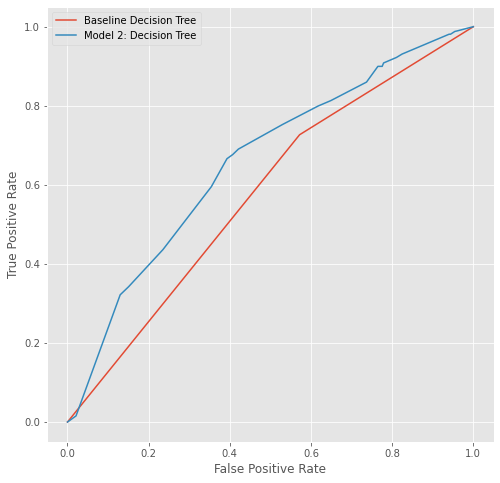

In [179]:
# Update ROC Curve
y_test_pred_prob = dtc_gridcv.predict_proba(X_test)

fpr, tpr, thresh = roc_curve(y_test, y_test_pred_prob[:,1])
print('AUC:',auc(fpr, tpr))

ax_roc.plot(fpr, tpr, label='Model 2: Decision Tree')
ax_roc.legend()

fig_roc

**Model 3: Interaction Terms**

Next, I try using the interaction terms like I did with logistic regression.

Grid Search found the following optimal parameters: 
dtc__class_weight: None
dtc__criterion: 'gini'
dtc__max_depth: 4
dtc__min_samples_leaf: 4
Training:
              precision    recall  f1-score   support

           0       0.71      0.15      0.25       808
           1       0.72      0.97      0.82      1780

    accuracy                           0.72      2588
   macro avg       0.71      0.56      0.54      2588
weighted avg       0.71      0.72      0.64      2588

Test:
              precision    recall  f1-score   support

           0       0.59      0.11      0.19       285
           1       0.69      0.96      0.80       578

    accuracy                           0.68       863
   macro avg       0.64      0.54      0.50       863
weighted avg       0.66      0.68      0.60       863



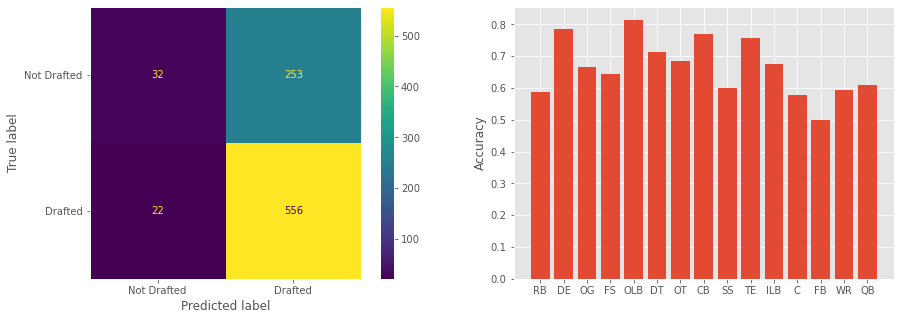

In [180]:
# Decision tree pipeline with GridSearchCV
dtc = DecisionTreeClassifier()

param_grid_dtc = {
    'dtc__criterion': ['gini','entropy'],
    'dtc__max_depth': [3, 4, 5, None],
    'dtc__min_samples_leaf': [1, 2, 3, 4],
    'dtc__class_weight': [None, {0: 2, 1: 1}, {0: 3, 1: 2}]
}

list1 = ['Height','Weight','Sprint_40yd','Vertical_Jump','Bench_Press_Reps','Broad_Jump','Agility_3cone','Shuttle','BMI']

pipe = Pipeline(steps=[
    ('impute_scale',FunctionTransformer(ImputeAndScaleByPosition)),
    ('interterms',FunctionTransformer(create_interaction_terms, kw_args={'list1':list1})),
    ('dummies',FunctionTransformer(pd.get_dummies,kw_args={'columns':['Position','school_group']})),
    ('dtc',dtc)
])

dtc_gridcv = GridSearchCV(pipe, param_grid=param_grid_dtc, cv=3)

X = df_combine[['Age','Height','Weight','Sprint_40yd','Vertical_Jump','Bench_Press_Reps','Broad_Jump','Agility_3cone',
             'Shuttle','BMI','Position','school_group']]
y = df_combine['Drafted']

# Split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=rand_seed, test_size=0.25)

dtc_gridcv.fit(X_train, y_train)

best_parameters = dtc_gridcv.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

y_train_pred = dtc_gridcv.predict(X_train)
y_test_pred = dtc_gridcv.predict(X_test)

display_model_results(y_train, y_train_pred, y_test, y_test_pred, df_combine)

This time around, adding interaction terms seems to have improved the fit and reduced overfitting. However, the performance is still worse than the best logistic regression model.

AUC: 0.6466490621016209


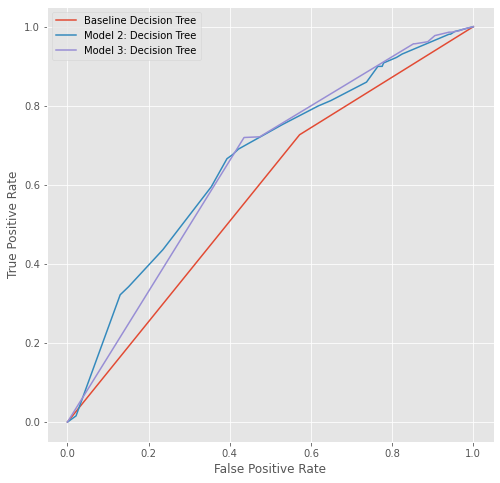

In [181]:
# Update ROC Curve
y_test_pred_prob = dtc_gridcv.predict_proba(X_test)

fpr, tpr, thresh = roc_curve(y_test, y_test_pred_prob[:,1])
print('AUC:',auc(fpr, tpr))

ax_roc.plot(fpr, tpr, label='Model 3: Decision Tree')
ax_roc.legend()

fig_roc

The AUC is a little worse than the last model.

# K Nearest Neighbors Classifier

**Model 1: Baseline K Nearest Neighbors Classifier**

K nearest neighbors needs missing values replaced and scaling of parameters.<br>

The first model uses the default hyperparameters.

In [182]:
# Define X and y
X = df_combine[['Age','Height','Weight','Sprint_40yd','Vertical_Jump','Bench_Press_Reps','Broad_Jump','Agility_3cone',
             'Shuttle','BMI','Position','school_group']]
y = df_combine['Drafted']

# Split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=rand_seed, test_size=0.25)

# Apply imputer and scaler
X_train = ImputeAndScaleByPosition(X_train)
X_test = ImputeAndScaleByPosition(X_test)

# Apply get_dummies to separate categorical data into columns
X_train = pd.get_dummies(X_train, columns=['Position','school_group'])
X_test = pd.get_dummies(X_test, columns=['Position','school_group'])

Training:
              precision    recall  f1-score   support

           0       0.72      0.49      0.58       808
           1       0.80      0.91      0.85      1780

    accuracy                           0.78      2588
   macro avg       0.76      0.70      0.72      2588
weighted avg       0.77      0.78      0.77      2588

Test:
              precision    recall  f1-score   support

           0       0.53      0.32      0.40       285
           1       0.72      0.86      0.78       578

    accuracy                           0.68       863
   macro avg       0.62      0.59      0.59       863
weighted avg       0.66      0.68      0.66       863



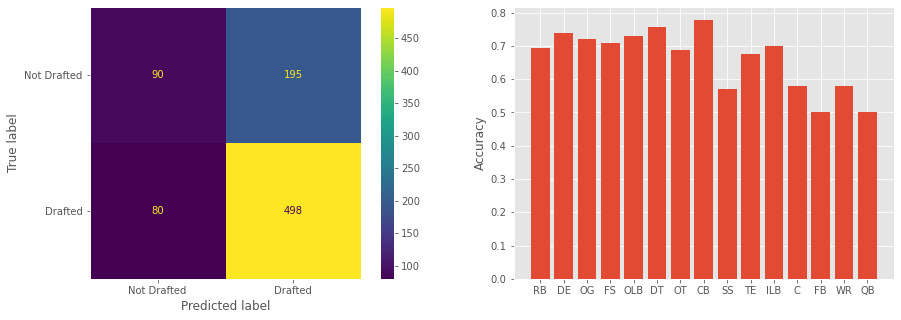

In [183]:
# Instantiate KNeighborsClassifier
knn = KNeighborsClassifier()

# Fit model
knn.fit(X_train, y_train)

# Get predictions
y_train_pred = knn.predict(X_train)
y_test_pred = knn.predict(X_test)

display_model_results(y_train, y_train_pred, y_test, y_test_pred, df_combine)

The baseline model achieves a 68% accuracy on the test data.

AUC: 0.6387603957991865


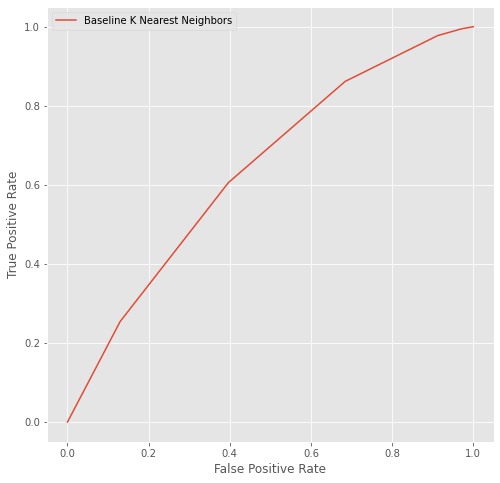

In [184]:
# Plot ROC curve
y_test_pred_prob = knn.predict_proba(X_test)
fig_roc, ax_roc = plt.subplots(figsize=(8,8))

fpr, tpr, thresh = roc_curve(y_test, y_test_pred_prob[:,1])
print('AUC:',auc(fpr, tpr))

ax_roc.plot(fpr, tpr, label='Baseline K Nearest Neighbors')

ax_roc.set_xlabel('False Positive Rate')
ax_roc.set_ylabel('True Positive Rate')
ax_roc.legend()

The baseline model is not very impressive. Let's try tweaking some things about the model.

**Model 2: Separating the Positions**

One of the things I have tried to achieve with other models is separating the different positions. I can do that with a K nearest neighbors model by increasing the values of the one-hot-encoded position columns. Below, I multiply those columns by 10 so that the model should not consider players of different positions to be neighbors (unless there are fewer than n_neighbors of a given position). I do not actually expect this to make a huge difference, but it is worth trying.

In [185]:
# Define X and y
X = df_combine[['Age','Height','Weight','Sprint_40yd','Vertical_Jump','Bench_Press_Reps','Broad_Jump','Agility_3cone',
             'Shuttle','BMI','Position','school_group']]
y = df_combine['Drafted']

# Split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=rand_seed, test_size=0.25)

# Apply imputer and scaler
X_train = ImputeAndScaleByPosition(X_train)
X_test = ImputeAndScaleByPosition(X_test)

# Apply get_dummies to separate categorical data into columns
X_train = pd.get_dummies(X_train, columns=['Position','school_group'])
X_test = pd.get_dummies(X_test, columns=['Position','school_group'])

# Separate positions further so they won't be neighbors
for col in X_train.columns:
    if 'Position' in col:
        X_train[col] = X_train[col].apply(lambda x: 10*x)
        X_test[col] = X_test[col].apply(lambda x: 10*x)

Training:
              precision    recall  f1-score   support

           0       0.72      0.47      0.57       808
           1       0.79      0.92      0.85      1780

    accuracy                           0.78      2588
   macro avg       0.76      0.69      0.71      2588
weighted avg       0.77      0.78      0.76      2588

Test:
              precision    recall  f1-score   support

           0       0.51      0.28      0.36       285
           1       0.71      0.87      0.78       578

    accuracy                           0.67       863
   macro avg       0.61      0.57      0.57       863
weighted avg       0.64      0.67      0.64       863



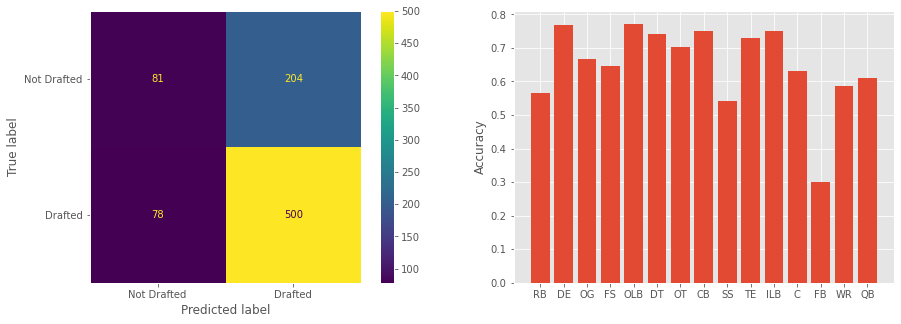

In [186]:
# Instantiate KNeighborsClassifier
knn = KNeighborsClassifier()

# Fit model
knn.fit(X_train, y_train)

# Get predictions
y_train_pred = knn.predict(X_train)
y_test_pred = knn.predict(X_test)

display_model_results(y_train, y_train_pred, y_test, y_test_pred, df_combine)

This model is slightly worse than the first. It seems that separating the positions did not improve the fit.

AUC: 0.6415619498573423


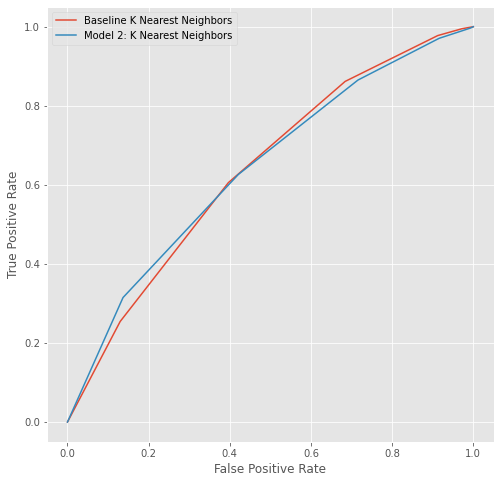

In [187]:
# Update ROC Curve
y_test_pred_prob = knn.predict_proba(X_test)

fpr, tpr, thresh = roc_curve(y_test, y_test_pred_prob[:,1])
print('AUC:',auc(fpr, tpr))

ax_roc.plot(fpr, tpr, label='Model 2: K Nearest Neighbors')
ax_roc.legend()

fig_roc

**Model 3: GridSearchCV**

The model below adjusts two hyperparameters:<br>
1. n_neighbors: number of neighbors to use when making predictions
2. p: exponent of the Minkowski metric to use.

Once again, I use a pipeline to make sure that there is no data leakage.

Grid Search found the following optimal parameters: 
knn__n_neighbors: 49
knn__p: 3
Training:
              precision    recall  f1-score   support

           0       0.75      0.21      0.33       808
           1       0.73      0.97      0.83      1780

    accuracy                           0.73      2588
   macro avg       0.74      0.59      0.58      2588
weighted avg       0.74      0.73      0.68      2588

Test:
              precision    recall  f1-score   support

           0       0.67      0.15      0.25       285
           1       0.70      0.96      0.81       578

    accuracy                           0.70       863
   macro avg       0.68      0.56      0.53       863
weighted avg       0.69      0.70      0.62       863



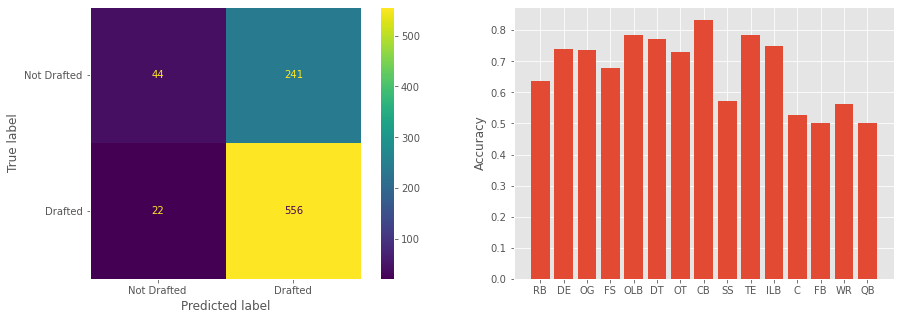

In [188]:
# K Nearest neighbors classifier pipeline with GridSearchCV
knn = KNeighborsClassifier()

param_grid_knn = {
    'knn__n_neighbors': [9,25,49,81],
    'knn__p': [1, 1.5, 2, 2.5, 3]
}

pipe = Pipeline(steps=[
    ('impute_scale',FunctionTransformer(ImputeAndScaleByPosition)),
    ('dummies',FunctionTransformer(pd.get_dummies,kw_args={'columns':['Position','school_group']})),
    ('knn',knn)
])

knn_gridcv = GridSearchCV(pipe, param_grid=param_grid_knn, cv=3)

X = df_combine[['Age','Height','Weight','Sprint_40yd','Vertical_Jump','Bench_Press_Reps','Broad_Jump','Agility_3cone',
             'Shuttle','BMI','Position','school_group']]
y = df_combine['Drafted']

# Split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=rand_seed, test_size=0.25)

knn_gridcv.fit(X_train, y_train)

best_parameters = knn_gridcv.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

y_train_pred = knn_gridcv.predict(X_train)
y_test_pred = knn_gridcv.predict(X_test)

display_model_results(y_train, y_train_pred, y_test, y_test_pred, df_combine)

The best result used the 49 nearest neighbors and p=3.<br>

The result was not as good as previous models and really struggled with recall of undrafted players.

AUC: 0.7079645480483215


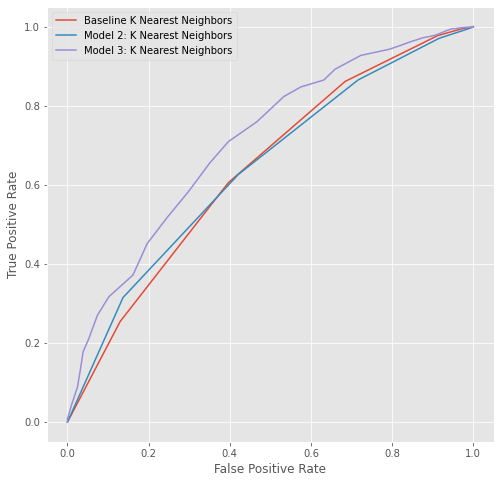

In [189]:
# Update ROC Curve
y_test_pred_prob = knn_gridcv.predict_proba(X_test)

fpr, tpr, thresh = roc_curve(y_test, y_test_pred_prob[:,1])
print('AUC:',auc(fpr, tpr))

ax_roc.plot(fpr, tpr, label='Model 3: K Nearest Neighbors')
ax_roc.legend()

fig_roc

This model was a clear improvement over the other K Nearest Neighbors models, but it still did not perform as well as the logistic regression models.

# Naive Bayes Classifier

Scikit Learn does have a class for Naive Bayes models, but I decided to write my own from scratch for three reasons:<br>
1. It would be significantly easier getting the model to treat positions the way I want it to.
2. Technically, a Naive Bayes model shouldn't mind missing data, but online searches indicate that sklearn's Naive Bayes does.
3. It is good practice.

The "Naive" in Naive Bayes refers to the assumption that all of the independent columns are independent of one another. In reality, that tends to not actually be true and, realistically, it is not true in this case either. Players with faster 40-yard sprints tend to also have higher vertical jumps, but a lower number of bench press reps. However, the model should still be able to work reasonably well without taking into account these correlations.<br>

The one way in which I do not want the model to be naive is by assuming everything is independent of a player's position. I have written my classifier so that that the distributions depend on the position. This is part of the reason why I chose to write my own classifier since I wanted it to incorporate dependence on something other than the target variable.<br>

Below is the class that I wrote. It can actually be run without taking position into account (if you want) and you can specify which columns are categorical (those columns don't even need to be turned into numbers).<br>

This model does not require imputing or scaling of data. It is fine with missing values (it just likely won't perform as well on input that is missing data).

The predict method has one parameter called "bias". This bias indicates how much the model will lean towards predicting 1 rather than 0 (the model only works with binary classes as written). A bias of 1 means there is no bias, above 1 means it will predict 1 more often, and below 1 means it will predict 1 less often. It has an option called 'proportional' which automatically accounts for the class imbalance in the training data.

In [190]:
class NaiveBayes:
    def __init__(self, split_by_position=None, categorical_cols=None):
        """
        Arguments:
        split_by_position: List of column names where the probabilities should be calculated
        for each position separately.
        
        categorical_thresh: Indicates which columns are categorical.
        """
        self.split_by_position = split_by_position
        self.categorical_cols = categorical_cols
        
    def fit(self, X, y):
        """
        Inputs:
        X: pandas dataframe of independent variables
        y: target variable
        """
        self.X = X
        self.y = y
        
    def predict_proba(self, X):
        """
        Calculates the probability that a player will be drafted (or not).
        Input: 
        X: pandas DataFrame that matches the format of DataFrame used for fitting.
        """
        
        proba = []
        for i in X.index:
            logprob0 = np.log(sum(self.y==0)/len(self.y))
            logprob1 = np.log(sum(self.y==1)/len(self.y))
            
            for col in self.X.columns:
                
                if pd.isna(X.loc[i,col])==False:
                    
                    if col in self.categorical_cols:
                        
                        if col in self.split_by_position:
                            count0 = sum(self.y[(self.X[col]==X.loc[i,col]) & (self.X['Position']==X.loc[i,'Position'])]==0)
                            count1 = sum(self.y[(self.X[col]==X.loc[i,col]) & (self.X['Position']==X.loc[i,'Position'])]==1)
                            logprob0 += np.log(count0/(count0+count1))
                            logprob1 += np.log(count1/(count0+count1))
                            
                        else:
                            count0 = sum(self.y[self.X[col]==X.loc[i,col]]==0)
                            count1 = sum(self.y[self.X[col]==X.loc[i,col]]==1)
                            logprob0 += np.log(count0/(count0+count1))
                            logprob1 += np.log(count1/(count0+count1))
                        
                    else:
                    
                        if col in self.split_by_position:
                            mean0 = np.mean(self.X[(self.X['Position']==X.loc[i,'Position']) & (self.y==0)][col])
                            mean1 = np.mean(self.X[(self.X['Position']==X.loc[i,'Position']) & (self.y==1)][col])
                            std0 = np.std(self.X[(self.X['Position']==X.loc[i,'Position']) & (self.y==0)][col], ddof=1)
                            std1 = np.std(self.X[(self.X['Position']==X.loc[i,'Position']) & (self.y==1)][col], ddof=1)
                        
                        else:
                            mean0 = np.mean(self.X[self.y==0][col])
                            mean1 = np.mean(self.X[self.y==1][col])
                            std0 = np.std(self.X[self.y==0][col], ddof=1)
                            std1 = np.std(self.X[self.y==1][col], ddof=1)
                        
                        logprob0 += np.log(st.norm.pdf(X.loc[i,col], mean0, std0))
                        logprob1 += np.log(st.norm.pdf(X.loc[i,col], mean1, std1))
                        
            proba.append([np.exp(logprob0)/(np.exp(logprob0)+np.exp(logprob1)),
                         np.exp(logprob1)/(np.exp(logprob0)+np.exp(logprob1))])
                
        return np.array(proba)
    
    def predict(self, X, bias=1.0):
        """
        Predict whether a player will be drafted or not.
        Input: 
        X: pandas DataFrame that matches the format of DataFrame used for fitting.
        bias: Number that indicates by how much to bias towards a positive prediction. Default is 1.0 (no bias).
        If bias is set to 'proportional', then the relative proportion of the target class is used
        """
        if bias == 'proportional': bias = sum(self.y==0)/sum(self.y==1)
        
        proba = self.predict_proba(X)
        
        pred = [1 if x[0]/x[1] < bias else 0 for x in proba]
        
        return pd.Series(pred, index=X.index)

**Model 1: Baseline Model with no bias**
The data fed to the Naive Bayes will not be imputed (missing values will remain missing) and it will not be rescaled (it does not need to be because it accounts for position).<br>

The baseline model will use the default bias (1, meaning no bias).

Training:
              precision    recall  f1-score   support

           0       0.77      0.22      0.34       808
           1       0.73      0.97      0.83      1780

    accuracy                           0.74      2588
   macro avg       0.75      0.59      0.59      2588
weighted avg       0.74      0.74      0.68      2588

Test:
              precision    recall  f1-score   support

           0       0.74      0.17      0.27       285
           1       0.70      0.97      0.82       578

    accuracy                           0.71       863
   macro avg       0.72      0.57      0.54       863
weighted avg       0.71      0.71      0.64       863



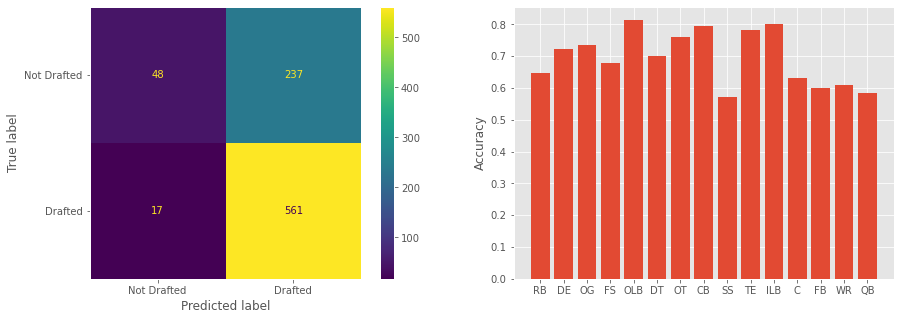

In [191]:
# Define X and y
X = df_combine[['Age','Height','Weight','Sprint_40yd','Vertical_Jump','Bench_Press_Reps','Broad_Jump','Agility_3cone',
             'Shuttle','BMI','Position','school_group']]
y = df_combine['Drafted']

# Split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=rand_seed, test_size=0.25)

split_cols = ['Height','Weight','Sprint_40yd','Vertical_Jump','Bench_Press_Reps','Broad_Jump','Agility_3cone',
             'Shuttle','BMI']
cat_cols = ['Position','school_group']

nb = NaiveBayes(split_by_position=split_cols, categorical_cols=cat_cols)

nb.fit(X_train, y_train)

# Bias is 1.0 by default
y_train_pred = nb.predict(X_train)
y_test_pred = nb.predict(X_test)

display_model_results(y_train, y_train_pred, y_test, y_test_pred, df_combine)

So far, all of the models have overpredicted the number of drafted players, leading to low values for the recall of undrafted players. This model is especially bad in this sense with just 17% recall of undrafted players. The next model should address this to some extent.

AUC: 0.714884963273235


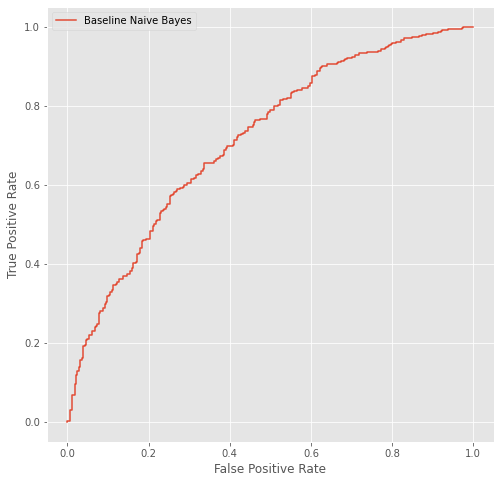

In [192]:
# Plot ROC curve
y_test_pred_prob = nb.predict_proba(X_test)
fig_roc, ax_roc = plt.subplots(figsize=(8,8))

fpr, tpr, thresh = roc_curve(y_test, y_test_pred_prob[:,1])
print('AUC:',auc(fpr, tpr))

ax_roc.plot(fpr, tpr, label='Baseline Naive Bayes')

ax_roc.set_xlabel('False Positive Rate')
ax_roc.set_ylabel('True Positive Rate')
ax_roc.legend()

I was curious to see what the histogram of predicted probabilities were for this model. Those histograms are below.<br>

The model tends to predict a lot of players will be drafted with high probability. Even the distribution of undrafted players is skewed towards very high probabilities.

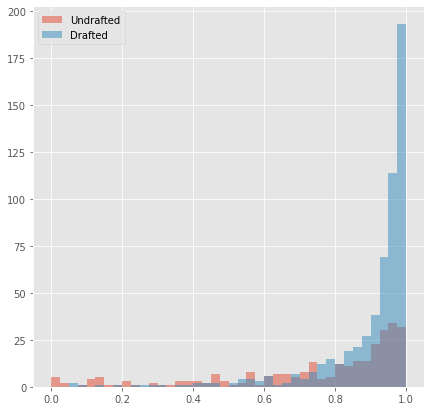

In [214]:
y_test_pred_prob = nb.predict_proba(X_test)

fig, ax = plt.subplots(figsize=(7,7))

keep = y_test==0

ax.hist(np.sort(y_test_pred_prob[keep][:,1]),bins=np.arange(41)/40,alpha=0.5,label='Undrafted',density=False)

keep = y_test==1

ax.hist(np.sort(y_test_pred_prob[keep][:,1]),bins=np.arange(41)/40,alpha=0.5,label='Drafted',density=False)

ax.legend()

**Model 2: Proportional bias**

The second model will be the same as the first, except now it will use the option of making the bias proportional. Because about 1/3 of players did not get drafted, the bias will be around (1/3)/(2/3) = 1/2. This should fix the problem of the model predicting so many players getting drafted.

Training:
              precision    recall  f1-score   support

           0       0.69      0.33      0.45       808
           1       0.76      0.93      0.83      1780

    accuracy                           0.75      2588
   macro avg       0.72      0.63      0.64      2588
weighted avg       0.74      0.75      0.72      2588

Test:
              precision    recall  f1-score   support

           0       0.66      0.28      0.40       285
           1       0.72      0.93      0.81       578

    accuracy                           0.71       863
   macro avg       0.69      0.61      0.61       863
weighted avg       0.70      0.71      0.68       863



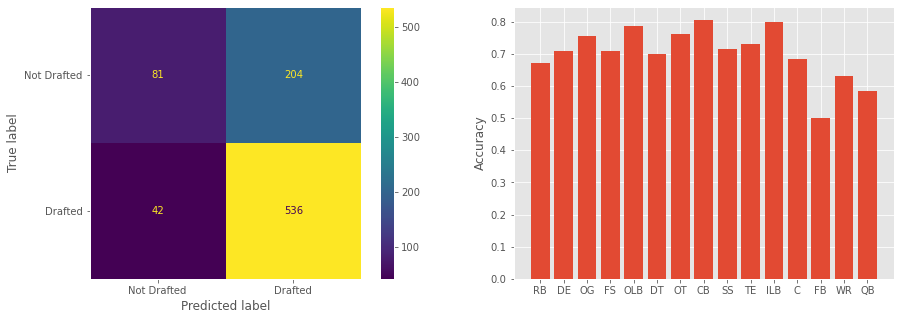

In [193]:
# Define X and y
X = df_combine[['Age','Height','Weight','Sprint_40yd','Vertical_Jump','Bench_Press_Reps','Broad_Jump','Agility_3cone',
             'Shuttle','BMI','Position','school_group']]
y = df_combine['Drafted']

# Split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=rand_seed, test_size=0.25)

split_cols = ['Height','Weight','Sprint_40yd','Vertical_Jump','Bench_Press_Reps','Broad_Jump','Agility_3cone',
             'Shuttle','BMI']
cat_cols = ['Position','school_group']

nb = NaiveBayes(split_by_position=split_cols, categorical_cols=cat_cols)

nb.fit(X_train, y_train)

# Using proportional bias
y_train_pred = nb.predict(X_train, bias='proportional')
y_test_pred = nb.predict(X_test, bias='proportional')

display_model_results(y_train, y_train_pred, y_test, y_test_pred, df_combine)

As predicted, the recall of undrafted players did improve (17% --> 28%), bringing it closer to the best logistic regression models (though still worse). The overall accuracy is actually the same as the previous Naive Bayes model.

**Naive Bayes result**
I could continue tweaking the bias parameter to see if it helps, but the precision and recall values are all at or below those of the best logistic regression model. This means that the Naive Bayes model will not outperform the logistic regression no matter what bias I use.

AUC: 0.714884963273235


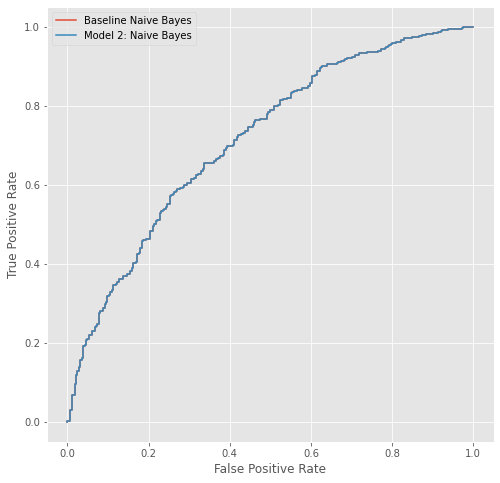

In [194]:
# Update ROC Curve
y_test_pred_prob = nb.predict_proba(X_test)

fpr, tpr, thresh = roc_curve(y_test, y_test_pred_prob[:,1])
print('AUC:',auc(fpr, tpr))

ax_roc.plot(fpr, tpr, label='Model 2: Naive Bayes')
ax_roc.legend()

fig_roc

The curve is precisely the same as the last model. This is because all I changed is the value that I use to make the cutoff between predicting 0 or 1, but the actual calculation of the probabilities was not changed at all.

# Random Forest Classifier

**Model 1: Baseline Model**
The baseline random forest classifier will use the default hyperparameter values and it will use the same preprocessing as the decision tree models.

In [195]:
# Define X and y
X = df_combine[['Age','Height','Weight','Sprint_40yd','Vertical_Jump','Bench_Press_Reps','Broad_Jump','Agility_3cone',
             'Shuttle','BMI','Position','school_group']]
y = df_combine['Drafted']

# Split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=rand_seed, test_size=0.25)

# Apply imputer and scaler
X_train = ImputeAndScaleByPosition(X_train)
X_test = ImputeAndScaleByPosition(X_test)

# Apply get_dummies to separate categorical data into columns
X_train = pd.get_dummies(X_train, columns=['Position','school_group'])
X_test = pd.get_dummies(X_test, columns=['Position','school_group'])

Training:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       808
           1       1.00      1.00      1.00      1780

    accuracy                           1.00      2588
   macro avg       1.00      1.00      1.00      2588
weighted avg       1.00      1.00      1.00      2588

Test:
              precision    recall  f1-score   support

           0       0.61      0.29      0.40       285
           1       0.72      0.91      0.81       578

    accuracy                           0.71       863
   macro avg       0.67      0.60      0.60       863
weighted avg       0.69      0.71      0.67       863



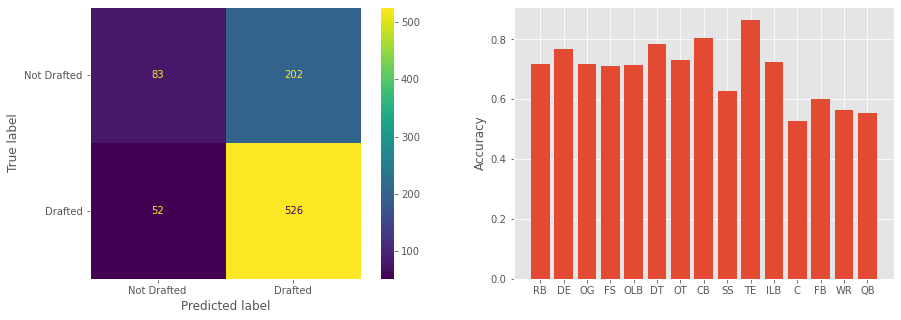

In [196]:
# Instantiate RandomForestClassifier
rfc = RandomForestClassifier(random_state=42)

# Fit model
rfc.fit(X_train, y_train)

# Get predictions
y_train_pred = rfc.predict(X_train)
y_test_pred = rfc.predict(X_test)

display_model_results(y_train, y_train_pred, y_test, y_test_pred, df_combine)

The fit to the training data is "perfect", indicating overfitting. We need to adjust some hyperparameters.

The fit to the test data was not that bad considering the overfitting. Let's see if it improves if we adjust the model.

AUC: 0.7020488071389546


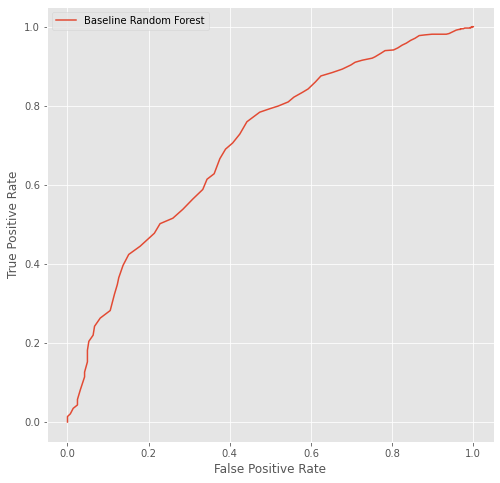

In [197]:
# Plot ROC curve
y_test_pred_prob = rfc.predict_proba(X_test)
fig_roc, ax_roc = plt.subplots(figsize=(8,8))

fpr, tpr, thresh = roc_curve(y_test, y_test_pred_prob[:,1])
print('AUC:',auc(fpr, tpr))

ax_roc.plot(fpr, tpr, label='Baseline Random Forest')

ax_roc.set_xlabel('False Positive Rate')
ax_roc.set_ylabel('True Positive Rate')
ax_roc.legend()

**Model 2: GridSearchCV**

The second model varies some hyperparameters to reduce the overfitting.

Grid Search found the following optimal parameters: 
rfc__class_weight: {0: 3, 1: 2}
rfc__criterion: 'gini'
rfc__max_depth: 6
rfc__min_samples_leaf: 3
rfc__n_estimators: 100
Training:
              precision    recall  f1-score   support

           0       0.74      0.48      0.58       808
           1       0.80      0.92      0.85      1780

    accuracy                           0.78      2588
   macro avg       0.77      0.70      0.72      2588
weighted avg       0.78      0.78      0.77      2588

Test:
              precision    recall  f1-score   support

           0       0.58      0.33      0.42       285
           1       0.73      0.88      0.80       578

    accuracy                           0.70       863
   macro avg       0.65      0.61      0.61       863
weighted avg       0.68      0.70      0.67       863



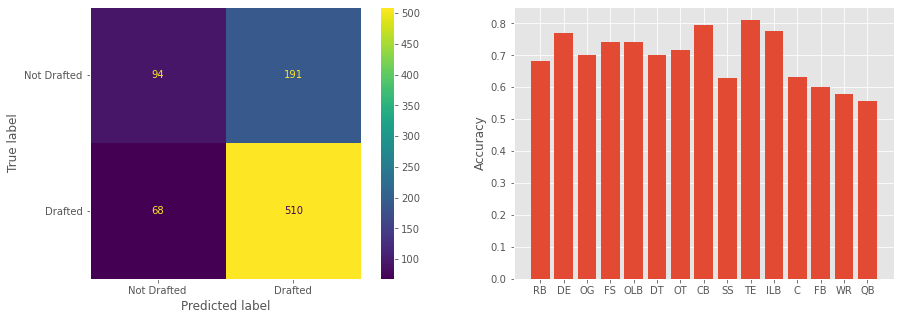

In [198]:
# Random forest classifier pipeline with GridSearchCV
rfc = RandomForestClassifier(random_state=42)

param_grid_rfc = {
    'rfc__n_estimators': [100, 150, 200],
    'rfc__max_depth':[4,6,8],
    'rfc__criterion': ['gini','entropy'],
    'rfc__min_samples_leaf': [1,2,3,4],
    'rfc__class_weight': [None, {0:3, 1:2}, {0:2, 1:1}]
}

pipe = Pipeline(steps=[
    ('impute_scale',FunctionTransformer(ImputeAndScaleByPosition)),
    ('dummies',FunctionTransformer(pd.get_dummies,kw_args={'columns':['Position','school_group']})),
    ('rfc',rfc)
])

rfc_gridcv = GridSearchCV(pipe, param_grid=param_grid_rfc, cv=3)

X = df_combine[['Age','Height','Weight','Sprint_40yd','Vertical_Jump','Bench_Press_Reps','Broad_Jump','Agility_3cone',
             'Shuttle','BMI','Position','school_group']]
y = df_combine['Drafted']

# Split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=rand_seed, test_size=0.25)

rfc_gridcv.fit(X_train, y_train)

best_parameters = rfc_gridcv.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

y_train_pred = rfc_gridcv.predict(X_train)
y_test_pred = rfc_gridcv.predict(X_test)

display_model_results(y_train, y_train_pred, y_test, y_test_pred, df_combine)

The model achieves an accuracy of 70%. The overfitting has been reduced, but not eliminated.

AUC: 0.7066654525587325


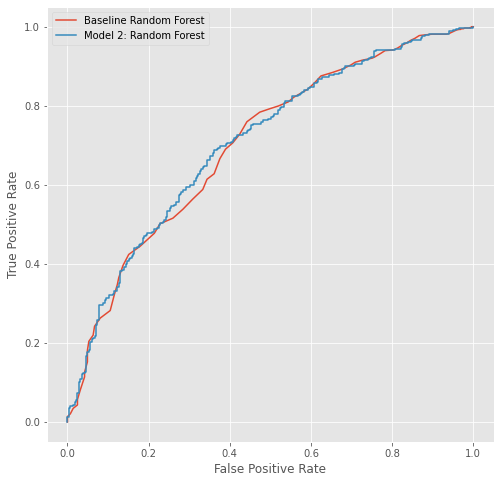

In [199]:
# Update ROC Curve
y_test_pred_prob = rfc_gridcv.predict_proba(X_test)

fpr, tpr, thresh = roc_curve(y_test, y_test_pred_prob[:,1])
print('AUC:',auc(fpr, tpr))

ax_roc.plot(fpr, tpr, label='Model 2: Random Forest')
ax_roc.legend()

fig_roc

**Model 3: Interaction Terms**

Interaction terms did not improve the fit for logistic regression, but did improve it slightly for the decision tree classifier. Since the random forest is made of decision trees, there is some reason to be hopeful that interaction terms could improve the fit here, too.

Grid Search found the following optimal parameters: 
rfc__class_weight: {0: 3, 1: 2}
rfc__criterion: 'gini'
rfc__max_depth: 8
rfc__min_samples_leaf: 3
rfc__n_estimators: 100
Training:
              precision    recall  f1-score   support

           0       0.89      0.22      0.35       808
           1       0.74      0.99      0.84      1780

    accuracy                           0.75      2588
   macro avg       0.81      0.60      0.60      2588
weighted avg       0.78      0.75      0.69      2588

Test:
              precision    recall  f1-score   support

           0       0.68      0.17      0.27       285
           1       0.70      0.96      0.81       578

    accuracy                           0.70       863
   macro avg       0.69      0.57      0.54       863
weighted avg       0.69      0.70      0.63       863



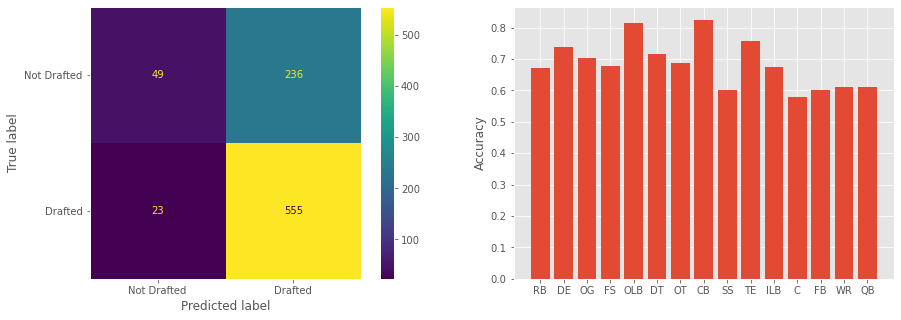

In [200]:
# Random forest classifier pipeline with GridSearchCV
rfc = RandomForestClassifier(random_state=42)

param_grid_rfc = {
    'rfc__n_estimators': [100, 150, 200],
    'rfc__max_depth':[4,6,8],
    'rfc__criterion': ['gini','entropy'],
    'rfc__min_samples_leaf': [1,2,3,4],
    'rfc__class_weight': [None, {0:3, 1:2}, {0:2, 1:1}]
}

list1 = ['Height','Weight','Sprint_40yd','Vertical_Jump','Bench_Press_Reps','Broad_Jump','Agility_3cone','Shuttle','BMI']

pipe = Pipeline(steps=[
    ('impute_scale',FunctionTransformer(ImputeAndScaleByPosition)),
    ('interterms',FunctionTransformer(create_interaction_terms, kw_args={'list1':list1})),
    ('dummies',FunctionTransformer(pd.get_dummies,kw_args={'columns':['Position','school_group']})),
    ('rfc',rfc)
])

rfc_gridcv = GridSearchCV(pipe, param_grid=param_grid_rfc, cv=3)

X = df_combine[['Age','Height','Weight','Sprint_40yd','Vertical_Jump','Bench_Press_Reps','Broad_Jump','Agility_3cone',
             'Shuttle','BMI','Position','school_group']]
y = df_combine['Drafted']

# Split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=rand_seed, test_size=0.25)

rfc_gridcv.fit(X_train, y_train)

best_parameters = rfc_gridcv.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

y_train_pred = rfc_gridcv.predict(X_train)
y_test_pred = rfc_gridcv.predict(X_test)

display_model_results(y_train, y_train_pred, y_test, y_test_pred, df_combine)

The introduction of interaction terms did not significantly change the success of the model. It still does not match the logistic regression models.

AUC: 0.7164633035876888


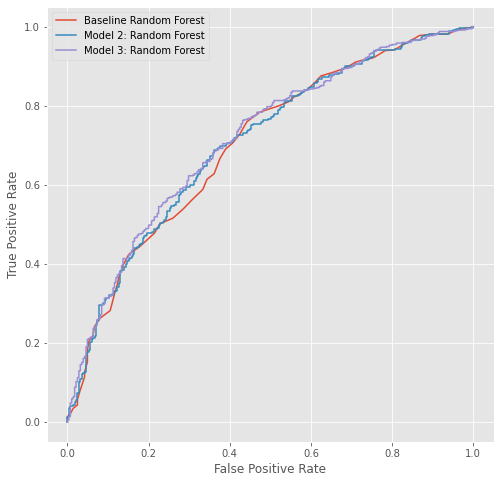

In [201]:
# Update ROC Curve
y_test_pred_prob = rfc_gridcv.predict_proba(X_test)

fpr, tpr, thresh = roc_curve(y_test, y_test_pred_prob[:,1])
print('AUC:',auc(fpr, tpr))

ax_roc.plot(fpr, tpr, label='Model 3: Random Forest')
ax_roc.legend()

fig_roc

# XGBoost Classifier

**Model 1: Baseline**
Since XGBoost can handle missing data, I will not impute anything for the missing data. I will still rescale values for each position separately.

In [211]:
# Define X and y
X = df_combine[['Age','Height','Weight','Sprint_40yd','Vertical_Jump','Bench_Press_Reps','Broad_Jump','Agility_3cone',
             'Shuttle','BMI','Position','school_group']]
y = df_combine['Drafted']

# Split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=rand_seed, test_size=0.25)

# Rescale, but don't impute
X_train = ImputeAndScaleByPosition(X_train, fill_missing=False)
X_test = ImputeAndScaleByPosition(X_test, fill_missing=False)

# Apply get_dummies to separate categorical data into columns
X_train = pd.get_dummies(X_train, columns=['Position','school_group'])
X_test = pd.get_dummies(X_test, columns=['Position','school_group'])

Training:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       808
           1       0.99      1.00      1.00      1780

    accuracy                           0.99      2588
   macro avg       1.00      0.99      0.99      2588
weighted avg       0.99      0.99      0.99      2588

Test:
              precision    recall  f1-score   support

           0       0.57      0.35      0.43       285
           1       0.73      0.87      0.79       578

    accuracy                           0.70       863
   macro avg       0.65      0.61      0.61       863
weighted avg       0.68      0.70      0.68       863



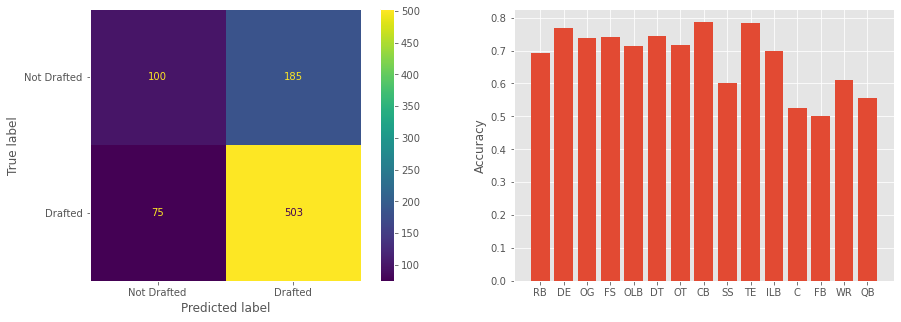

In [212]:
# Instantiate XGBClassifier
xgb = XGBClassifier()

# Fit model
xgb.fit(X_train, y_train)

# Get predictions
y_train_pred = xgb.predict(X_train)
y_test_pred = xgb.predict(X_test)

display_model_results(y_train, y_train_pred, y_test, y_test_pred, df_combine)

The baseline model is severely overfitting. Below, I do a grid search to tune hyperparameters which should help fix this problem.

AUC: 0.6750257997936016


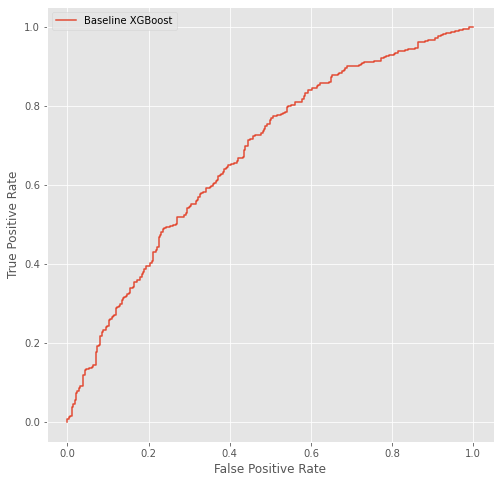

In [213]:
# Plot ROC curve
y_test_pred_prob = xgb.predict_proba(X_test)
fig_roc, ax_roc = plt.subplots(figsize=(8,8))

fpr, tpr, thresh = roc_curve(y_test, y_test_pred_prob[:,1])
print('AUC:',auc(fpr, tpr))

ax_roc.plot(fpr, tpr, label='Baseline XGBoost')

ax_roc.set_xlabel('False Positive Rate')
ax_roc.set_ylabel('True Positive Rate')
ax_roc.legend()

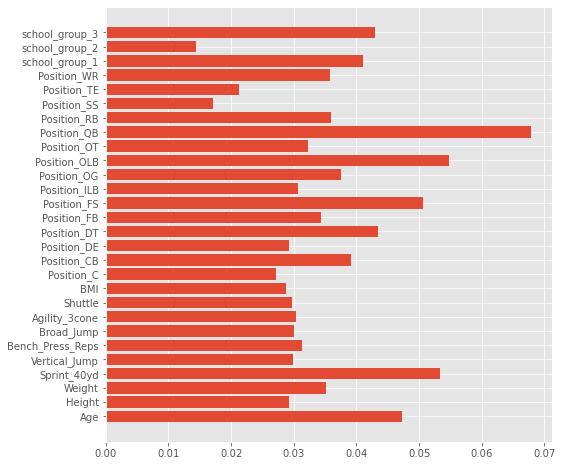

In [214]:
# Plot feature importances
fig, ax = plt.subplots(figsize=(8,8))

ax.barh(np.arange(len(xgb.feature_importances_)),xgb.feature_importances_)
ax.set_yticks(np.arange(len(xgb.feature_importances_)))
ax.set_yticklabels(X_train.columns);

**Model 2: GridSearchCV**

This model varies some of the hyperparameters to find the optimal combination.<br>
I utilize a pipeline to avoid data leakage.

Grid Search found the following optimal parameters: 
xgb__booster: 'gbtree'
xgb__learning_rate: 0.05
xgb__max_depth: 3
xgb__min_child_weight: 2
xgb__n_estimators: 200
xgb__scale_pos_weight: 1
xgb__subsample: 0.9
Training:
              precision    recall  f1-score   support

           0       0.79      0.46      0.58       808
           1       0.80      0.94      0.86      1780

    accuracy                           0.79      2588
   macro avg       0.79      0.70      0.72      2588
weighted avg       0.79      0.79      0.78      2588

Test:
              precision    recall  f1-score   support

           0       0.60      0.31      0.41       285
           1       0.72      0.90      0.80       578

    accuracy                           0.70       863
   macro avg       0.66      0.60      0.60       863
weighted avg       0.68      0.70      0.67       863



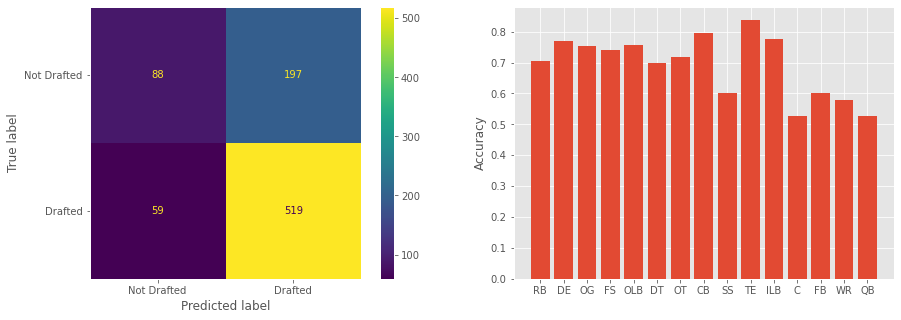

In [215]:
# XGBClassifier pipeline with GridSearchCV
xgb = XGBClassifier()

param_grid_xgb = {
    'xgb__learning_rate': [0.05, 0.02],
    'xgb__max_depth': [3,4,5],
    'xgb__min_child_weight': [1, 2, 3],
    'xgb__subsample': [0.7, 0.9],
    'xgb__n_estimators': [100, 150, 200],
    'xgb__scale_pos_weight':[0.5, 1],
    'xgb__booster': ['gbtree']
}

pipe = Pipeline(steps=[
    ('impute_scale',FunctionTransformer(ImputeAndScaleByPosition, kw_args={'fill_missing':False})),
    ('dummies',FunctionTransformer(pd.get_dummies,kw_args={'columns':['Position','school_group']})),
    ('xgb',xgb)
])

xgb_gridcv = GridSearchCV(pipe, param_grid=param_grid_xgb, cv=3)

X = df_combine[['Age','Height','Weight','Sprint_40yd','Vertical_Jump','Bench_Press_Reps','Broad_Jump','Agility_3cone',
             'Shuttle','BMI','Position','school_group']]
y = df_combine['Drafted']

# Split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=rand_seed, test_size=0.25)

xgb_gridcv.fit(X_train, y_train)

best_parameters = xgb_gridcv.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

y_train_pred = xgb_gridcv.predict(X_train)
y_test_pred = xgb_gridcv.predict(X_test)

display_model_results(y_train, y_train_pred, y_test, y_test_pred, df_combine)

The model still appears to be overfitting slightly. The accuracy of the test data did improve, but it is still a bit lower than the best logistic regression model.

AUC: 0.7142172039094274


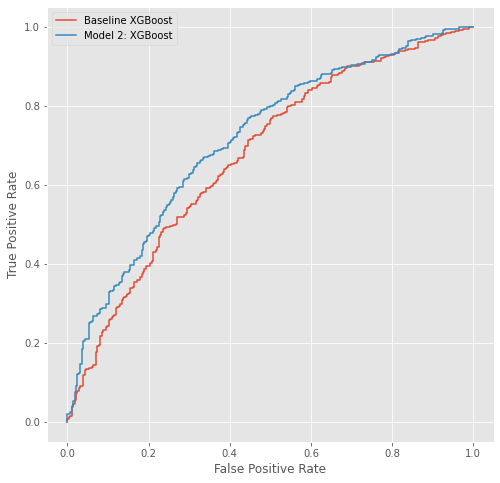

In [216]:
# Update ROC Curve
y_test_pred_prob = xgb_gridcv.predict_proba(X_test)

fpr, tpr, thresh = roc_curve(y_test, y_test_pred_prob[:,1])
print('AUC:',auc(fpr, tpr))

ax_roc.plot(fpr, tpr, label='Model 2: XGBoost')
ax_roc.legend()

fig_roc

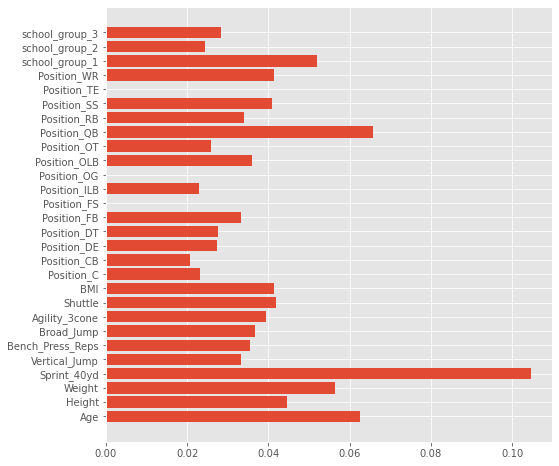

In [217]:
# Plot feature importance for last model
fig, ax = plt.subplots(figsize=(8,8))

ax.barh(np.arange(len(xgb_gridcv.best_estimator_['xgb'].feature_importances_)),xgb_gridcv.best_estimator_['xgb'].feature_importances_)
ax.set_yticks(np.arange(len(xgb_gridcv.best_estimator_['xgb'].feature_importances_)))
ax.set_yticklabels(pd.get_dummies(X_train,columns=['Position','school_group']).columns);

**Model 3: Interaction terms**

Like the last model, I use GridSearchCV to test out different combinations of hyperparameters, but I also create interaction terms.

Grid Search found the following optimal parameters: 
xgb__booster: 'gbtree'
xgb__learning_rate: 0.05
xgb__max_depth: 6
xgb__min_child_weight: 1
xgb__n_estimators: 150
xgb__scale_pos_weight: 1
xgb__subsample: 0.5
Training:
              precision    recall  f1-score   support

           0       0.87      0.43      0.58       808
           1       0.79      0.97      0.87      1780

    accuracy                           0.80      2588
   macro avg       0.83      0.70      0.73      2588
weighted avg       0.82      0.80      0.78      2588

Test:
              precision    recall  f1-score   support

           0       0.65      0.27      0.38       285
           1       0.72      0.93      0.81       578

    accuracy                           0.71       863
   macro avg       0.69      0.60      0.60       863
weighted avg       0.70      0.71      0.67       863



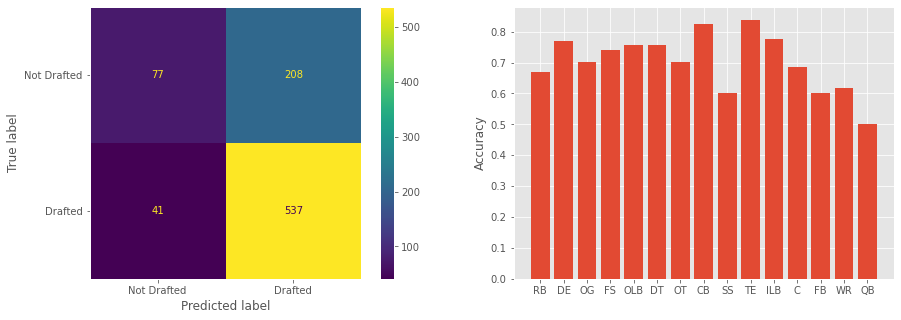

In [218]:
# XGBClassifier pipeline with GridSearchCV
xgb = XGBClassifier()

param_grid_xgb = {
    'xgb__learning_rate': [0.05, 0.02],
    'xgb__max_depth': [5,6,7],
    'xgb__min_child_weight':[1,2],
    'xgb__subsample': [0.5, 0.7, 0.9],
    'xgb__n_estimators': [150, 200],
    'xgb__scale_pos_weight':[0.5,1],
    'xgb__booster': ['gbtree']
}

list1 = ['Height','Weight','Sprint_40yd','Vertical_Jump','Bench_Press_Reps','Broad_Jump','Agility_3cone','Shuttle','BMI']

pipe = Pipeline(steps=[
    ('impute_scale',FunctionTransformer(ImputeAndScaleByPosition, kw_args={'fill_missing':False})),
    ('interterms',FunctionTransformer(create_interaction_terms, kw_args={'list1':list1})),
    ('dummies',FunctionTransformer(pd.get_dummies,kw_args={'columns':['Position','school_group']})),
    ('xgb',xgb)
])

xgb_gridcv = GridSearchCV(pipe, param_grid=param_grid_xgb, cv=3)

X = df_combine[['Age','Height','Weight','Sprint_40yd','Vertical_Jump','Bench_Press_Reps','Broad_Jump','Agility_3cone',
             'Shuttle','BMI','Position','school_group']]
y = df_combine['Drafted']

# Split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=rand_seed, test_size=0.25)

xgb_gridcv.fit(X_train, y_train)

best_parameters = xgb_gridcv.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

y_train_pred = xgb_gridcv.predict(X_train)
y_test_pred = xgb_gridcv.predict(X_test)

display_model_results(y_train, y_train_pred, y_test, y_test_pred, df_combine)

The model is barely achieving a better accuracy than the last one. It also achieved a higher AUC (as seen below). This is the best XGBoost Classifier model, but it still is outperformed by the logistic regression.

AUC: 0.7324348934620288


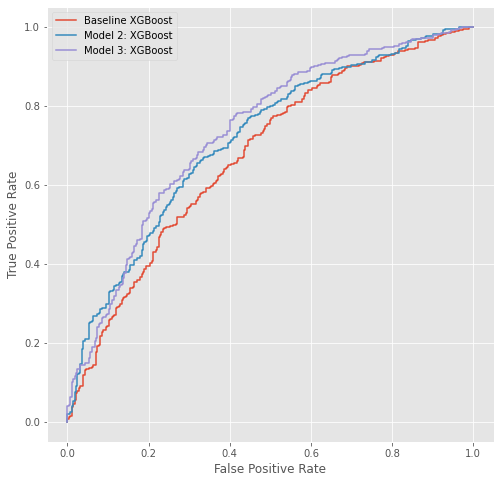

In [219]:
# Update ROC Curve
y_test_pred_prob = xgb_gridcv.predict_proba(X_test)

fpr, tpr, thresh = roc_curve(y_test, y_test_pred_prob[:,1])
print('AUC:',auc(fpr, tpr))

ax_roc.plot(fpr, tpr, label='Model 3: XGBoost')
ax_roc.legend()

fig_roc

<ipython-input-115-fdf88b5a8623>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[f"{list1[i]}xPosition_{list2[j]}"] = X[list1[i]]*X['Position'].\
C:\Users\david\anaconda3\envs\learn-env\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


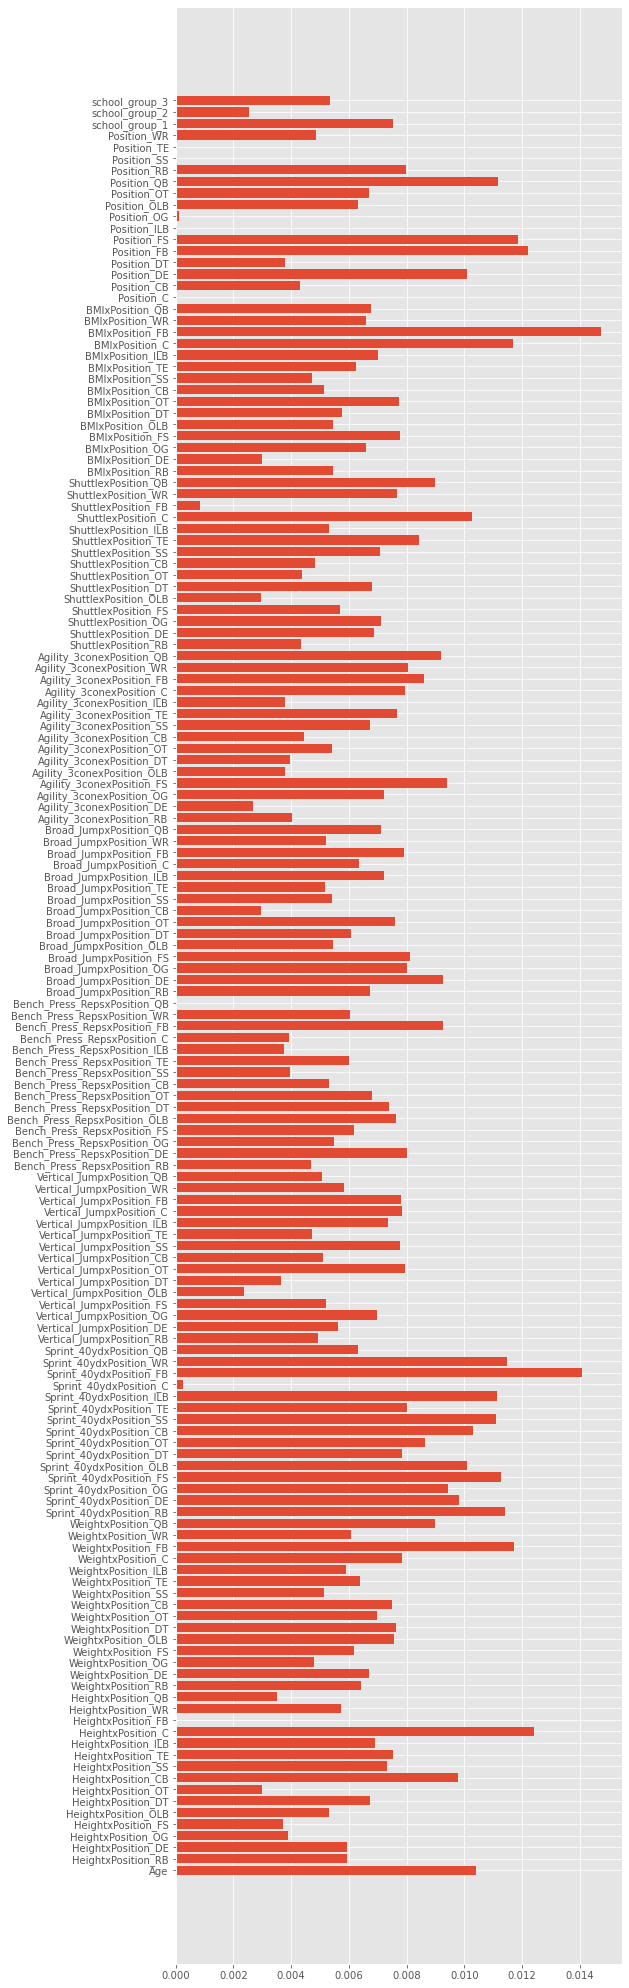

In [177]:
# Plot feature importance for last model
fig, ax = plt.subplots(figsize=(8,36))

ax.barh(np.arange(len(xgb_gridcv.best_estimator_['xgb'].feature_importances_)),xgb_gridcv.best_estimator_['xgb'].feature_importances_)
ax.set_yticks(np.arange(len(xgb_gridcv.best_estimator_['xgb'].feature_importances_)))
ax.set_yticklabels(pd.get_dummies(create_interaction_terms(X_train,list1),columns=['Position','school_group']).columns);

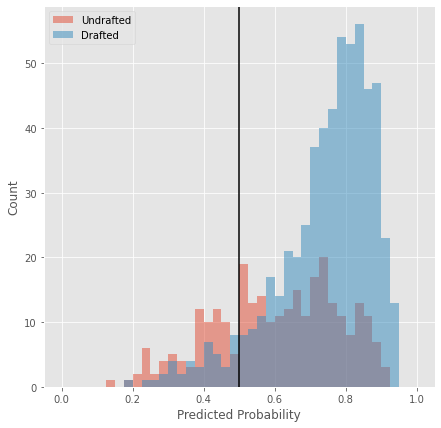

In [221]:
y_test_pred_prob = xgb_gridcv.predict_proba(X_test)

fig, ax = plt.subplots(figsize=(7,7))

keep = y_test==0

ax.hist(np.sort(y_test_pred_prob[keep][:,1]),bins=np.arange(41)/40,alpha=0.5,label='Undrafted',density=False)

keep = y_test==1

ax.hist(np.sort(y_test_pred_prob[keep][:,1]),bins=np.arange(41)/40,alpha=0.5,label='Drafted',density=False)

ax.axvline(0.5, color='black')

ax.set_xlabel('Predicted Probability')
ax.set_ylabel('Count')

ax.legend()

### Summary of Model Fitting Results

**How good are the models?**

First, the overall performance of the models was not that strong. The accuracy achieved by the models ranged from 67% to 74%. Also, the models tended to overpredict the number of drafted players and had values below 35% for the recall of undrafted players. The 74% accuracy is even less impressive given that 67% of players in the dataset were drafted, so a 67% accuracy could be achieved by simply predicting that all players will get drafted.

It is not surprising that the model was not achieving very high accuracy. The data used here only told us about a player's athleticism, such as how fast they run or how high they jump, and their basic physical characteristics, like age, height, weight, and BMI. While athleticism and physicality are important in the sport of football, they do not reflect any skills specific to football in any way. NFL teams need to use other means to evaluate a player's football ability and understanding such as watching their college game film, talking to them about strategy, or running more football specific drills. The NFL Combine does actually have position-specific drills, but those drills are not in the data, mostly because they do not boil down to a few simple numbers.

**So are the models useless?**

Even if the models do not achieve a high accuracy, they are still useful. For one, the best models can be used to identify the players who have a very strong chance of being drafted. Looking at the probability of being drafted rather than just the binary prediction, we can see that the players with very high probabilities are drafted at a very high rate.

Also, we can see some other trends in the data, such as which positions tend to get drafted more often and which criteria tend to get used when evaluating Combine performance. It is pretty clear that the most important thing that happens at the Combine is the 40-yard sprint. Not every position cares about top speed, but for the ones that do, the 40-yard sprint time is a major factor in determining who will get drafted.

It also appears that a player's age and the school they attended also matters. Players that attended the bigger football programs tended to get drafted more often and younger players also tended to get drafted more often.

**Which type of model worked best?**

The best performing model was a logistic regression model that did not use interaction terms and used a value of C=100 for regularization (though it was not very sensitive to the value of C).

**Decision Tree Classifier**

In [447]:
# Instantiate DecisionTreeClassifier
dtc = DecisionTreeClassifier(random_state=42)

# Fit model
dtc.fit(X_train, y_train)

# Get predictions
y_train_pred = dtc.predict(X_train)
y_test_pred = dtc.predict(X_test)

print(classification_report(y_train, y_train_pred))
print(classification_report(y_test, y_test_pred))

ValueError: could not convert string to float: 'CB'

In [ ]:
# Try dtreeviz at some point
from sklearn.tree import plot_tree, export_text

fig, ax = plt.subplots(figsize=(15,15), dpi=200)

plot_tree(dtc, max_depth=3, feature_names=X_train.columns ,ax=ax);

In [ ]:
X_train.columns

In [ ]:
r = export_text(dtc, feature_names=list(X_train.columns))
print(r)

In [ ]:
df_combine[(df_combine['Sprint_40yd']>4.6) & (df_combine['Position']=='WR')]['Drafted'].describe()